In [1]:
# ONLY RUN THIS CELL ONCE AS IT WILL RESET THE SURROGATE MODELS
sur_model_dict ={}

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Input #, activations
from keras.layers import Conv2D
import random
import matplotlib.style
import matplotlib.pyplot as plt
import os
from datetime import datetime
import json
import copy
import pickle
import math

sss= ['Buckling_Load_Factor', 'Utilization', 'Interstorey_Drift_Ratios']

In [312]:
# =======================================================================================
#                                               VAE
# =======================================================================================


###################################################################################################
############################################  INPUTS    ###########################################
###################################################################################################

datasets = ['DATASET_24']
test_indices_no = 50

# main path
main_path_vae = os.path.join(os.getcwd(),'DATASETS',datasets[0],'cvae_results')
# Create a results folder in the main directory if it doesn't exist
os.makedirs(main_path_vae, exist_ok=True)


# parent path
parent_path = os.path.abspath(os.path.join(os.getcwd(),'..'))     # parent directory
parent_path = os.path.join(parent_path,'DATASETS/') 

# DEFINE DATASET PATH
dataset_file_path_vae = os.path.join(parent_path,datasets[0],'00_geometry_generation/dataset')

# DEFINE LOAD PATH FD
load_file_path = 'f___d-64-relu________d-64-relu___d-28-sigmoid________ld-2___β-0.2___epochs-600___batch-64___val-0.2___mse___lr-0.0001________thick-separate-feature___1HOT'
# DEFINE LOAD PATH MNIST
# load_file_path = 'f___d-32-relu___d-32-relu________d-32-relu___d-32-relu___d-784-sigmoid________ld-2___β-0.2___epochs-600___batch-256___val-0.2___bce___lr-0.0005________thick-separate-feature___MNIST'
# To load, type 'True'
BOOLEAN_load_file_vae = True

# To generate plots, type 'True'
BOOLEAN_plot_vae = True

# Is thickness a 'feature', a 'label', or 'off'?
BOOLEAN_thickness_vae = 'feature'

# To determine whether the dataset is MNIST or not. If mnist is to be selected type 'MNIST' or else type anything
BOOLEAN_dataset = 'FD'

# To determine whether the convolutional layers will be used
BOOLEAN_convolution = False

# To determine whether the label is one_hot_encoded or not
BOOLEAN_cvae_label = 'one_hot_encoded'
####################################################### label parameters

# decimal places for height
height_tolerance = 1
# height to sample (in metres) 
c_height = 1.5 

####################################################### hyperparameters

# latent dimension
latent_dim = 2
# KL-loss weight
b = 100 
# loss_type: choose 'mce' or 'bce'
loss_type_name = 'mse'
# epochs
epoch_number_vae = 600
# batch size
batch_size_number_vae = 64
# validation split
val_split = 0.2
# learning rate
learn_rate_vae = 1e-5

# IMPORTANT: The architecture of the VAE is not changed here like 
    # number of layers 
    # dense/convolutional layers
    # activation function for layers
    # optimizer (Adam etx)

# DONOT CHANGE

if BOOLEAN_thickness_vae in ['feature']:
    i_shape_vae = (28,1,1)
    i_shape_vae = (28,)
    i_shape_flat_vae =28*1*1
else:
    i_shape_vae = (27,1,1)
    i_shape_vae = (27,)
    i_shape_flat_vae =27*1*1    

condition_dim = (1,)
c_height = np.array(c_height)
c_height = c_height.reshape(1,1)

In [313]:
# VAE: AUTOMATICALLY LOADING THE HYPERPARAMETERS FROM LOAD FILE IF FILE IS TO BE LOADED
 
import ast

if BOOLEAN_load_file_vae == True:

    description_file_path_vae = os.path.join(main_path_vae,load_file_path, 'description.txt')
    with open(description_file_path_vae) as f:
        content = f.read()
        description_file_vae = ast.literal_eval(content)
    print(description_file_vae)

    ####################################################### hyperparameters
    
    print('--------------------------------------------------')
    print(('-------------------hyperparameters---------------'))

    for string_list in description_file_vae['hyperparameters']:

        if 'epochs' in string_list:
            _, value = string_list.split("=")
            epoch_number_vae = int(value.strip())  # Convert to an integer (if needed)
            print(f'epochs = {epoch_number_vae}')

        if 'batch_size' in string_list:
            _, value = string_list.split("=")
            batch_size_number_vae = int(value.strip())  # Convert to an integer (if needed)
            print(f'batch_size = {batch_size_number_vae}')

        if 'validation_split' in string_list:
            _, value = string_list.split("=")
            val_split = float(value.strip())  # Convert to an integer (if needed)
            print(f'validation_split = {val_split}')

        if 'learning_rate' in string_list:
            if 'lr' in string_list:
                _,value = string_list.split('-')
                learn_rate_vae = float(value.strip())  # Convert to an integer (if needed)
                print(f'learning_rate = {learn_rate_vae}')
            else:   
                _, value = string_list.split("=")
                learn_rate_vae = float(value.strip())  # Convert to an integer (if needed)
                print(f'learning_rate = {learn_rate_vae}')

        if 'latent_dimension' in string_list:
            _, value = string_list.split("=")
            latent_dim = int(value.strip())  # Convert to an integer (if needed)
            print(f'latent_dimension = {latent_dim}')
                  
        if 'beta' in string_list:
            _, value = string_list.split("=")
            b = float(value.strip())  # Convert to an integer (if needed)
            print(f'beta = {b}')

        if 'loss_type' in string_list:
            _, value = string_list.split("= ")
            loss_type_name = str(value.strip())  # Convert to an integer (if needed)
            print(f'loss_type = {loss_type_name}')


    print('---------------------------------------------------')
    print(('-------------------other parameters---------------'))


    for string_list in description_file_vae['other_parameters']:


        if 'thickness = normalized in x_test and x_train independantly from the force densities. It is a feature' in string_list:
            BOOLEAN_thickness_vae = 'feature'  # Convert to an integer (if needed)
            print(f'BOOLEAN_thickness_vae = {BOOLEAN_thickness_vae}')
            BOOLEAN_thickness_normalization = 'separate'
            print(f'BOOLEAN_thickness_normalization = {BOOLEAN_thickness_normalization}')


        if 'normalized in x_test and x_train along with the force densities. It is a feature' in string_list:
            BOOLEAN_thickness_vae = 'feature'  # Convert to an integer (if needed)
            print(f'BOOLEAN_thickness_vae = {BOOLEAN_thickness_vae}')
            BOOLEAN_thickness_normalization = 'together'
            print(f'BOOLEAN_thickness_normalization = {BOOLEAN_thickness_normalization}')

        elif 'not included' in string_list:
            BOOLEAN_thickness_vae = 'feature'  # Convert to an integer (if needed)
            print(f'BOOLEAN_thickness_vae = {BOOLEAN_thickness_vae}')
        
        if 'MNIST' in string_list:
            BOOLEAN_dataset = 'MNIST'  # Convert to an integer (if needed)
            print(f'BOOLEAN_dataset = {BOOLEAN_dataset}')
        else:
            BOOLEAN_dataset = 'FD'  # Convert to an integer (if needed)
            print(f'BOOLEAN_dataset = {BOOLEAN_dataset}')            

{'encoder': ['flatten_layer', 'dense_layer = 64-relu'], 'decoder': ['dense_layer = 64-relu', 'dense_layer = 28-sigmoid'], 'hyperparameters': ['latent_dimension = 2', 'beta = 0.2', 'epochs = 600', 'batch_size = 64', 'validation_split = 0.2', 'loss_type = mse', 'learning_rate = lr-0.0001'], 'other_parameters': ['thickness = normalized in x_test and x_train independantly from the force densities. It is a feature', 'dataset = one_hot_encoded']}
--------------------------------------------------
-------------------hyperparameters---------------
latent_dimension = 2
beta = 0.2
epochs = 600
batch_size = 64
validation_split = 0.2
loss_type = mse
learning_rate = 0.0001
---------------------------------------------------
-------------------other parameters---------------
BOOLEAN_thickness_vae = feature
BOOLEAN_thickness_normalization = separate
BOOLEAN_dataset = FD
BOOLEAN_dataset = FD


In [404]:
# =======================================================================================
#                                               SURROGATE MODEL
# =======================================================================================


####################################################################################################################
####################################################----INPUTS----###################################################
#####################################################################################################################


# main path
main_path_sur = os.path.join(os.getcwd(),'DATASETS',datasets[0],'surr_results')
# Create a results folder in the main directory if it doesn't exist
os.makedirs(main_path_sur, exist_ok=True)

# DEFINE DATASET PATH
dataset_file_path_sur = os.path.join(parent_path,datasets[0],'00_geometry_generation/dataset')

# DEFINE LOAD PATH
load_file_path_sur = {}
load_file_path_sur['Buckling_Load_Factor'] = 'f___d-256-relu___d-128-relu___d-1-relu________epochs-2000___batch-256___val-0.2___lr-5e-06________BUCK___thick-separate'
load_file_path_sur['Utilization'] = 'f___d-512-relu___d-256-relu___d-128-relu___d-1-relu________epochs-3000___batch-256___val-0.2___lr-5e-06________UTIL___thick-separate'
load_file_path_sur['Interstorey_Drift_Ratios'] = 'f___d-512-relu___d-256-relu___d-1-relu________epochs-3000___batch-128___val-0.2___lr-5e-06________DRIFT___thick-separate'
load_file_path_sur['Height'] = 'f___d-256-relu___d-128-relu___d-1-relu________epochs-3000___batch-128___val-0.2___lr-5e-06________HEIGHT___thick-separate'
load_file_path_sur['Mass'] = 'f___d-512-relu___d-256-relu___d-128-relu___d-1-relu________epochs-3000___batch-256___val-0.2___lr-5e-06________MASS___thick-separate'


# To load, type 'True'
BOOLEAN_load_file_sur = True

# To generate plots, type 'True'
BOOLEAN_plot_sur = True

# chosen combination method for seismic load
xy_combining_method = 'max'

# surrogate model to run -  'Buckling_Load_Factor', 'Utilization' , 'Interstorey_Drift_Ratios', 'all', 'Height', 'Mass'
BOOLEAN_model_type = 'Height'

# To determine whether the thickness is normalized along with the force densities ('together') or independantly ('separate')
BOOLEAN_thickness_normalization = 'separate'



####################################################### hyperparameters

# epochs
epoch_number_sur = 10000
# batch size
batch_size_number_sur = 128
# validation split
val_split = 0.2
# learning rate
learn_rate_sur = 5E-6

# IMPORTANT: The architecture of the VAE is not changed here like 
    # number of layers 
    # dense/convolutional layers
    # activation function for layers
    # optimizer (Adam etx)


In [405]:
# SUR: AUTOMATICALLY LOADING THE HYPERPARAMETERS FROM LOAD FILE IF FILE IS TO BE LOADED
 
import ast

if BOOLEAN_load_file_sur == True:

    description_file_path_sur = os.path.join(main_path_sur,load_file_path_sur[BOOLEAN_model_type], 'description.txt')
    with open(description_file_path_sur) as f:
        content = f.read()
        description_file_sur = ast.literal_eval(content)
    print(description_file_sur)

    ####################################################### hyperparameters
    
    print('--------------------------------------------------')
    print(('-------------------hyperparameters---------------'))

    for string_list in description_file_sur['hyperparameters']:

        if 'epochs' in string_list:
            _, value = string_list.split("=")
            epoch_number_sur = int(value.strip())  # Convert to an integer (if needed)
            print(f'epochs = {epoch_number_sur}')

        if 'batch_size ' in string_list:
            _, value = string_list.split("=")
            batch_size_number_sur = int(value.strip())  # Convert to an integer (if needed)
            print(f'batch_size = {batch_size_number_sur}')

        if 'validation_split' in string_list:
            _, value = string_list.split("=")
            val_split = float(value.strip())  # Convert to an integer (if needed)
            print(f'validation_split = {val_split}')

        if 'learning_rate ' in string_list:
            _, value = string_list.split("=")
            learn_rate_sur = float(value.strip())  # Convert to an integer (if needed)
            print(f'learning_rate = {learn_rate_sur}')

    print('---------------------------------------------------')
    print(('-------------------other parameters---------------'))

    counter = 0
    for string_list in description_file_sur['other_parameters']:
        
        if 'Buckling_Load_Factor' in string_list or 'Utilization' in string_list or 'Interstorey_Drift_Ratios' in string_list or 'Height' in string_list or 'Mass' in string_list:
            _, value = string_list.split("= ")
            BOOLEAN_model_type = str(value.strip())  # Convert to an integer (if needed)
            print(f'BOOLEAN_model_type = {BOOLEAN_model_type}')
            counter=1

        if 'normalized in x_test and x_train independantly from the force densities' in string_list:
            BOOLEAN_thickness_normalization = 'separate'  # Convert to an integer (if needed)
            print(f'BOOLEAN_thickness_normalization = {BOOLEAN_thickness_normalization}')

        elif 'thickness = normalized in x_test and x_train along with the force densities' in string_list:
            BOOLEAN_thickness_normalization = 'together'  # Convert to an integer (if needed)
            print(f'BOOLEAN_thickness_normalization = {BOOLEAN_thickness_normalization}')

    if counter == 0:
        BOOLEAN_model_type = 'all'

{'surrogate_model': ['flatten_layer', 'dense_layer = 256-relu', 'dense_layer = 128-relu', 'dense_layer = 1-relu'], 'hyperparameters': ['epochs = 3000', 'batch_size = 128', 'validation_split = 0.2', 'learning_rate = 5e-06'], 'other_parameters': ['model = Height', 'thickness = normalized in x_test and x_train independantly from the force densities']}
--------------------------------------------------
-------------------hyperparameters---------------
epochs = 3000
batch_size = 128
validation_split = 0.2
learning_rate = 5e-06
---------------------------------------------------
-------------------other parameters---------------
BOOLEAN_model_type = Height
BOOLEAN_thickness_normalization = separate


In [406]:
# Colours

# Define custom color
colour_dark_blue = (11/255, 58/255, 64/255)  # Normalize RGB values to range [0, 1]
colour_teal = (15/255, 117/255, 118/255)  # Normalize RGB values to range [0, 1]
colour_maroon = (170/255, 80/255, 38/255)  # Normalize RGB values to range [0, 1]
colour_gold = (190/255, 181/255, 111/255)  # Normalize RGB values to range [0, 1]
colour_orange= (241/255, 118/255, 34/255)  # Normalize RGB values to range [0, 1]
colour_light_blue= (173/255, 216/255, 230/255)
colour_olive_green = (128/255, 128/255, 0/255)
colour_plum = (221/255, 160/255, 221/255)
colour_slate_gray = (112/255, 128/255, 144/255)
colour_coral = (255/255, 127/255, 80/255)

colour_list = [colour_teal, colour_orange, colour_maroon]
colour_list_5 = [colour_dark_blue,colour_teal,colour_gold,colour_orange,colour_maroon]
colour_list_10 = [colour_dark_blue,colour_teal,colour_light_blue,colour_olive_green,colour_slate_gray,colour_gold,colour_coral,colour_orange,colour_plum,colour_maroon]
colour_list_10 = [colour_dark_blue,colour_teal,colour_gold,colour_orange,colour_maroon,colour_orange, colour_gold,colour_teal,colour_dark_blue ]
colour_list_13 = [colour_dark_blue, colour_dark_blue, colour_teal,colour_teal ,colour_gold,colour_orange,colour_maroon,colour_orange, colour_gold,colour_teal,colour_teal, colour_dark_blue, colour_dark_blue ]

In [407]:
# SUR: Load the train labels
train_labels_path = os.path.join(main_path_sur, f"train_labels_{xy_combining_method}.txt")
train_labels_dict_path = os.path.join(main_path_sur, f"train_labels_dict_{xy_combining_method}.json")

if os.path.exists(train_labels_dict_path):
    train_labels_np = np.loadtxt(os.path.join(main_path_sur, f"train_labels_{xy_combining_method}.txt"), delimiter=',')
    BOOLEAN_generate_train_labels =  False

    pa_dict_sorted = {}
    pa_dict_sorted = {}
    with open(train_labels_dict_path, 'r') as file:
        pa_dict_sorted= json.load(file)

else:
    BOOLEAN_generate_train_labels = True

print(f"Generate training labels?: {BOOLEAN_generate_train_labels}")

Generate training labels?: False


In [408]:
# VAE/SUR: GETTING THE DATASET FOR X_TRAIN_SUR AND X_TRAIN_VAE

'''
this part of code is copied from vae_tz_4.ipynb
'''


# converting csv into array
dataset = pd.read_csv(os.path.join(dataset_file_path_sur,'dataset.csv'))
dataset = dataset.values
dataset = dataset.transpose()


###################################################################################################
############################ GENERATE INDICES FOR TEST AND TRAIN DATA #############################
###################################################################################################

'''ONLY GENERATE THIS ONCE FOR A PARTICULAR DATASET SO THE TEST MESHES REMAIN THE SAME!'''

if not (os.path.exists(os.path.join(main_path_sur,'indices_best.json')) or os.path.exists(os.path.join(main_path_sur,f'indices_test_{test_indices_no}.npy')) or os.path.exists(os.path.join(main_path_sur,f'indices_train_{test_indices_no}.npy'))): 
    
    BOOLEAN_generate_indices = True
    print('RUN performance_preprocessing.ipynb to generate indices_test.npy, indices_best.json, and indices_train.npy')

else:    
    BOOLEAN_generate_indices = False

    # Load remaining indices
    remaining_indices = np.load(os.path.join(main_path_sur,f'indices_test_{test_indices_no}.npy'))
    # Load random indices
    random_indices = np.load(os.path.join(main_path_sur,f'indices_train_{test_indices_no}.npy'))
    
    # Load best indices
    with open(os.path.join(main_path_sur,'indices_best_test.json')) as file:
        best_indices = json.load(file)
    # Converting best indices into dictionary for each SSS   
    best_indices_arr = np.array([best_indices['Buckling_Load_Factor'],best_indices['Utilization'],best_indices['Interstorey_Drift_Ratios']])
    best_indices_dict = {}
    best_indices_dict['Buckling_Load_Factor'] = best_indices_arr[0]
    best_indices_dict['Utilization'] = best_indices_arr[1]
    best_indices_dict['Interstorey_Drift_Ratios'] = best_indices_arr[2]


    # best test data
    if BOOLEAN_model_type == 'Buckling_Load_Factor':
        best_indices_arr_chosen = best_indices_arr[0,:]
    elif BOOLEAN_model_type == 'Utilization':
        best_indices_arr_chosen = best_indices_arr[1,:]
    elif BOOLEAN_model_type == 'Interstorey_Drift_Ratios':
        best_indices_arr_chosen = best_indices_arr[2,:]
    elif BOOLEAN_model_type == 'all':
        best_indices_arr_chosen = best_indices_arr


print(f"Generate indices for train/test data?: {BOOLEAN_generate_indices}")
print(f'test_indices: {remaining_indices.shape}')
if BOOLEAN_model_type not in ['Height', 'Mass']:
    print(f'best_indices: {best_indices_arr.shape}')
    print(f'best_indices_chosen: {best_indices_arr_chosen.shape}')
print(f'train_indices: {random_indices.shape}')

Generate indices for train/test data?: False
test_indices: (50,)
train_indices: (9925,)


In [409]:
# CHECK THICKNESS WISE TRENDS

thickness_path = os.path.join(parent_path,'thickness_dataset.json')
with open(thickness_path, 'r') as file:
    thickness_dataset = json.load(file)
thickness_dataset =  [i/1000 for i in thickness_dataset]


thickness_dict = copy.deepcopy(pa_dict_sorted['without_failure'])
for i, mesh in enumerate(thickness_dict.keys()):
    thickness_dict[mesh].append(thickness_dataset[i])

thickness_dataset = np.array(thickness_dataset)
thickness_dataset = thickness_dataset.reshape(-1,1)

# dataset_th = np.hstack((dataset,thickness_dataset))
# print(dataset_th.shape)

if BOOLEAN_thickness_normalization == 'together':
    train_th = thickness_dataset[random_indices]
    test_th = thickness_dataset[remaining_indices]
    if BOOLEAN_model_type not in ['Height', 'Mass']:
        best_th = thickness_dataset[best_indices_arr_chosen]

if BOOLEAN_thickness_normalization == 'separate':
    train_th = thickness_dataset[random_indices]/np.max(thickness_dataset)
    test_th = thickness_dataset[remaining_indices]/np.max(thickness_dataset)
    if BOOLEAN_model_type not in ['Height', 'Mass']:
        best_th = thickness_dataset[best_indices_arr_chosen]//np.max(thickness_dataset)

print(f'train_th_shape: {train_th.shape}')
print(f'test_th_shape: {test_th.shape}')
print(f'np.max(thickness_dataset): {np.max(thickness_dataset)}')

train_th_shape: (9925, 1)
test_th_shape: (50, 1)
np.max(thickness_dataset): 0.095


In [410]:
# VAE/ SUR: Load the height labels and weight labels

with open(os.path.join(dataset_file_path_vae, 'gg_dict.pkl'), 'rb') as file:
    gg_dict = pickle.load(file)

# height array
height_dataset = list(gg_dict['height'].values())
height_dataset = [round(i[0], height_tolerance) for i in height_dataset]
height_dataset = np.array(height_dataset)
height_dataset = height_dataset.reshape(-1,1)

# mass array
mass_dataset = list(gg_dict['mass'].values())
mass_dataset = [i[0] for i in mass_dataset]
mass_dataset = np.array(mass_dataset)
mass_dataset = mass_dataset.reshape(-1,1)

# train, test, and best performing height labels
train_hgt = height_dataset[random_indices]
test_hgt = height_dataset[remaining_indices]
if BOOLEAN_model_type not in ['Height', 'Mass']:
    best_hgt = height_dataset[best_indices_arr_chosen]

# train, test, and best performing mass labels
train_mass = mass_dataset[random_indices]
test_mass = mass_dataset[remaining_indices]
if BOOLEAN_model_type not in ['Height', 'Mass']:
    best_mass = mass_dataset[best_indices_arr_chosen]

# y_train_vae is the height label
y_train_vae = train_hgt
y_test_vae = test_hgt

print(f'y_train_vae shape: {y_train_vae.shape}')
print(f'y_test_vae shape: {y_test_vae.shape}')
print(f'np.max(mass_dataset): {np.max(mass_dataset)} kg')
print(f'np.max(height_dataset): {np.max(height_dataset)} m')
print(f'np.min(mass_dataset): {np.min(mass_dataset)} kg')
print(f'np.min(height_dataset): {np.min(height_dataset)} m')

y_train_vae shape: (9925, 1)
y_test_vae shape: (50, 1)
np.max(mass_dataset): 121937.46048 kg
np.max(height_dataset): 26.7 m
np.min(mass_dataset): 27430.8535 kg
np.min(height_dataset): 0.5 m


In [411]:
# VAE: SPLIT INTO TEST AND TRAIN, NORMALIZE AND RESHAPE.

###################################################################################################
##################################### SPLIT INTO TEST AND TRAIN DATA ##############################
###################################################################################################

# train data
x_train_vae = dataset[random_indices]
# test data
x_test_vae = dataset[remaining_indices]


###################################################################################################
##################################### NORMALIZE AND RESHAPE ######################################
###################################################################################################

# adding the thickness if togther normalization

if BOOLEAN_thickness_vae == 'feature':
    if BOOLEAN_thickness_normalization == 'together':
        x_train_vae = np.hstack((x_train_vae,train_th))
        x_test_vae = np.hstack((x_test_vae,test_th))
    


#Norm.
x_train_vae = x_train_vae.astype('float32')
x_test_vae = x_test_vae.astype('float32')
x_train_vae = x_train_vae / np.max(dataset)
x_test_vae = x_test_vae / np.max(dataset)


# adding the thickness if separate normalization
if BOOLEAN_thickness_vae == 'feature':
    if BOOLEAN_thickness_normalization == 'separate':
        x_train_vae = np.hstack((x_train_vae,train_th))
        x_test_vae = np.hstack((x_test_vae,test_th))

    
# Reshape 
'''
shape of x_train_vae = 7500, 27
shape of y_train_vae = 7500,
shape of x_test_vae = 2500, 27,
shape of y_test_vae = 2500,
'''
img_height = x_train_vae.shape[1]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train_vae = x_train_vae.reshape(x_train_vae.shape[0], img_height) #, 1, num_channels
x_test_vae = x_test_vae.reshape(x_test_vae.shape[0], img_height) #, 1, num_channels

print(f'x_train shape: {x_train_vae.shape}')
print(f'x_test shape: {x_test_vae.shape}')

x_train shape: (9925, 28)
x_test shape: (50, 28)


In [412]:
# VAE: MNIST DATASET FOR VAE 

from keras.datasets import mnist

if BOOLEAN_dataset == 'MNIST':

    # Load MNIST
    (x_train_vae, y_train_vae), (x_test_vae, y_test_vae) = mnist.load_data()

    #Normalize and reshape ============

    #Norm.
    x_train_vae = x_train_vae.astype('float32')
    x_test_vae = x_test_vae.astype('float32')
    x_train_vae = x_train_vae / 255
    x_test_vae = x_test_vae / 255


    i_shape_flat_vae = 784
    i_shape_vae = (784,)
    condition_dim = (1,)

    # redefining hyperparameters
    epoch_number_vae = 600
    batch_size_number_vae = 256
    learn_rate_vae = 5E-4
    loss_type_name = 'bce'


    c_height = 3
    c_height = np.array(c_height)
    c_height = c_height.reshape(None,)


    x_train_vae = x_train_vae.reshape(x_train_vae.shape[0], i_shape_flat_vae)
    x_test_vae = x_test_vae.reshape(x_test_vae.shape[0], i_shape_flat_vae)


In [413]:
# VAE: 1 HOT ENCODER

if BOOLEAN_cvae_label == 'one_hot_encoded':
    # Step 1: Import the necessary module
    from sklearn.preprocessing import OneHotEncoder
    # Step 2: Create your labels list
    if BOOLEAN_dataset == 'MNIST':
        labels_cvae = range(10) # number of values
    else:
        labels_cvae = list(np.unique(height_dataset))
    # Step 3: Reshape the data
    labels_cvae_array = np.array(labels_cvae).reshape(-1, 1)
    # Step 4: Fit and transform the labels
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoded = one_hot_encoder.fit_transform(labels_cvae_array)
    # Step 5: Make the dictionary for calling out the labels
    labels_cvae_dict = {}
    for i, val in enumerate(list(labels_cvae)):
        labels_cvae_dict[val] =  one_hot_encoded[i]

    # converting y_train vae into one hot encoded
    y_train_vae = y_train_vae.reshape(-1,1)
    y_train_vae = np.array([labels_cvae_dict[i[0]] for i in y_train_vae])
    # converting y_test_vae into one hot encoded
    y_test_vae = y_test_vae.reshape(-1,1)
    y_test_vae = np.array([labels_cvae_dict[i[0]] for i in y_test_vae])

    condition_dim = (len(labels_cvae),)



print(f'x_train shape: {x_train_vae.shape}')
print(f'x_test shape: {x_test_vae.shape}')
print(f'y_train shape: {y_train_vae.shape}')
print(f'y_test shape: {y_test_vae.shape}')
print(f'number of labels: {len(labels_cvae)}')
print(f'condition_dim: {condition_dim}')

x_train shape: (9925, 28)
x_test shape: (50, 28)
y_train shape: (9925, 58)
y_test shape: (50, 58)
number of labels: 58
condition_dim: (58,)


d:\OneDrive - Delft University of Technology\Thesis\python_others\my_code\02_vae\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [324]:
# VAE: CONSTRUCTING THE VAE CLASS (WITHOUT CONDITION LOSS)

# BCE (BINARY CROSS ENTROPY) - useful for binary data (1 or 0)
# MCE (BINARY CROSS ENTROPY) - useful for continuous data 
if loss_type_name == 'mse':
    loss_type = keras.losses.mean_squared_error
elif loss_type_name =='bce':
    loss_type = keras.losses.binary_crossentropy


###################################################################################################
############################################ VAE CLASS    #########################################
###################################################################################################
    

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data, condition = data[0]   # unpack data and condition
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([data, condition])  # pass condition to encoder
            reconstruction = self.decoder([z, condition])
            
            # GROUND TRUTH DATA = data
            # PREDICTED DATA = reconstruction

            # RECONSTRUCTION LOSS
            reconstruction_loss = tf.reduce_mean(loss_type(data, reconstruction))
            reconstruction_loss *= i_shape_flat_vae

            # EQUATION FOR KL_LOSS >>>>  -0.5*Σ(1 + log(σ**2)-(µ**2)-(σ**2)) 
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -b
           
            


            total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data, condition = data[0]  # unpack data and condition
        z_mean, z_log_var, z = self.encoder([data, condition])  # pass condition to encoder
        reconstruction = self.decoder([z, condition]) # pass condition to decoder
        reconstruction_loss = tf.reduce_mean(loss_type(data, reconstruction))
        reconstruction_loss *= i_shape_flat_vae
        
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -b
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [325]:
# # VAE: CONSTRUCTING THE VAE CLASS (WITH CONDITION LOSS)

# # BCE (BINARY CROSS ENTROPY) - useful for binary data (1 or 0)
# # MCE (BINARY CROSS ENTROPY) - useful for continuous data 
# if loss_type_name == 'mse':
#     loss_type = keras.losses.mean_squared_error
# elif loss_type_name =='bce':
#     loss_type = keras.losses.binary_crossentropy


# ###################################################################################################
# ############################################ VAE CLASS    #########################################
# ###################################################################################################
    

# class VAE(keras.Model):
#     def __init__(self, encoder, decoder, **kwargs):
#         super(VAE, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder

#     def train_step(self, data):
#         if isinstance(data, tuple):
#             data, condition = data[0]   # unpack data and condition
#         with tf.GradientTape() as tape:
#             z_mean, z_log_var, z = self.encoder([data, condition])  # pass condition to encoder
#             reconstruction = self.decoder([z, condition])
            
#             # GROUND TRUTH DATA = data
#             # PREDICTED DATA = reconstruction

#             # RECONSTRUCTION LOSS
#             reconstruction_loss = tf.reduce_mean(loss_type(data, reconstruction))
#             reconstruction_loss *= i_shape_flat_vae

#             # EQUATION FOR KL_LOSS >>>>  -0.5*Σ(1 + log(σ**2)-(µ**2)-(σ**2)) 
#             kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
#             kl_loss = tf.reduce_mean(kl_loss)
#             kl_loss *= -b
           
#             # Condition loss
#             condition_loss = self.compute_condition_loss(z, condition)

#             total_loss = reconstruction_loss + kl_loss + gamma * condition_loss  # Added condition loss to total loss

#             grads = tape.gradient(total_loss, self.trainable_weights)
#             self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
#         return {
#             "loss": total_loss,
#             "reconstruction_loss": reconstruction_loss,
#             "kl_loss": kl_loss,
#             "condition_loss": condition_loss
#         }

#     def test_step(self, data):
#         if isinstance(data, tuple):
#             data, condition = data[0]  # unpack data and condition
#         z_mean, z_log_var, z = self.encoder([data, condition])  # pass condition to encoder
#         reconstruction = self.decoder([z, condition]) # pass condition to decoder
#         reconstruction_loss = tf.reduce_mean(loss_type(data, reconstruction))
#         reconstruction_loss *= i_shape_flat_vae
        
#         kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
#         kl_loss = tf.reduce_mean(kl_loss)
#         kl_loss *= -b

#         # Condition loss
#         condition_loss = self.compute_condition_loss(z, condition)

#         total_loss = reconstruction_loss + kl_loss + gamma * condition_loss  # Added condition loss to total loss

#         return {
#             "loss": total_loss,
#             "reconstruction_loss": reconstruction_loss,
#             "kl_loss": kl_loss,
#             "condition_loss": condition_loss            
#         }


#     def compute_condition_loss(self, z, condition):
#         condition_loss = 0.0
#         for i in range(batch_size_number_vae):
#             for j in range(i + 1, batch_size_number_vae):
#                 condition_match = tf.reduce_all(tf.equal(condition[i], condition[j]))
#                 condition_loss += tf.reduce_sum(tf.square(z[i] - z[j])) * tf.cast(condition_match, tf.float32)
#         return condition_loss

# class Sampling(layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [326]:
# VAE: ENCODER

###################################################################################################
############################################  ENCODER    ##########################################
###################################################################################################


encoder_inputs = keras.Input(shape=i_shape_vae)
condition_inputs = keras.Input(shape=condition_dim)  # additional input for condition

# concatenate inputs with condition
x = layers.Concatenate()([encoder_inputs, condition_inputs])

if BOOLEAN_convolution == False:

    # this flatten layer has been introduced as amy's dataset was already flattened. you need flattened encoder inputs for dense layers. if you don't want to flatten, you can use convolution. 
    x = layers.Flatten()(x)

    ############################################################################# Dense layers
    # neurons of each dense layer [layer1, layer2...]
    neurons_encoder = [64]
    # activation function of each dense layer [layer1, layer2...]
    act_func_encoder = ["relu"]

    x = layers.Dense(neurons_encoder[0], activation=act_func_encoder[0])(x)
    # x = layers.Dense(neurons_encoder[1], activation=act_func_encoder[1])(x)

elif BOOLEAN_convolution == True:
#     #Conv2D is a CNN layer. 
    ''''Conv2D(32,3, padding...) 32 is number of filters. 3 is the filter/kernel size (3x3)'''
    x = Conv2D(32, 3, padding='same', activation='relu')(x)         # n' = 28
    ''' second convolutional layer uses 2,2 strides so input image is downsampled from 28x28 to 14x14'''
    x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)  # n' = 14.5
    x = Conv2D(64, 3, padding='same', activation='relu')(x)                 # n' = 14.5
    x = Conv2D(64, 3, padding='same', activation='relu')(x)                 # n' = 14.5
    conv_shape = x.shape
    #Flatten
    x = layers.Flatten()(x)
    # fully connected part (dense layers)
    x = layers.Dense(32, activation='relu')(x)
    '''
    32 = (flattened) output dimension 
    '''

############################################################################# z layer
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

############################################################################# Assemble encoder
encoder = keras.Model([encoder_inputs, condition_inputs], [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

In [327]:
# VAE: DECODER

###################################################################################################
############################################  DECODER    ##########################################
###################################################################################################


latent_inputs = keras.Input(shape=(latent_dim,))

condition_inputs_dec = keras.Input(shape=condition_dim)  # additional input for condition
# concatenate latent inputs with condition
x = layers.Concatenate()([latent_inputs, condition_inputs_dec])


if BOOLEAN_convolution == False:
    ############################################################################# Dense layers
    # neurons of each dense layer [layer1, layer2...]
    neurons_decoder = [64, i_shape_flat_vae]
    # activation function of each dense layer [layer1, layer2...]
    act_func_decoder = ["relu","sigmoid"]

    x = layers.Dense(neurons_decoder[0], activation=act_func_decoder[0])(x)
    x = layers.Dense(neurons_decoder[1], activation=act_func_decoder[1])(x)
    # x = layers.Dense(neurons_decoder[2], activation=act_func_decoder[2])(x)

elif BOOLEAN_convolution == True:
    # Need to start with a shape that can be remapped to original image shape as
    #we want our final utput to be same shape original input.
    #So, add dense layer with dimensions that can be reshaped to desired output shape
    x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
    # reshape to the shape of last conv. layer in the encoder, so we can upscale (conv2D transpose) back to original shape 
    x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    # use Conv2DTranspose to reverse the conv layers defined in the encoder
    x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
    #Can add more conv2DTranspose layers, if desired. 
    #Using sigmoid activation
    x = layers.Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

############################################################################# Reshape
decoder_outputs = layers.Reshape(i_shape_vae)(x)
# decoder_outputs = layers.Reshape((28,))(x)
############################################################################# Assemble decoder
decoder = keras.Model([latent_inputs, condition_inputs_dec], decoder_outputs, name="decoder")
# decoder.summary()

In [328]:
# VAE: COMPILING OF VAE
###################################################################################################
############################################  TRAINING    #########################################
###################################################################################################

print("Starting Training of Variational Autoencoder!")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learn_rate_vae), metrics=['accuracy'])

Starting Training of Variational Autoencoder!


In [331]:
# VAE: Load VAE model
###################################################################################################
########################################  LOAD VAE MODEL ####################################
###################################################################################################

load_location_vae = os.path.join(main_path_vae, load_file_path)
vae_weights_path = os.path.join(load_location_vae,'weights_vae.h5')
vae_history_path = os.path.join(load_location_vae,'trainHistoryDict_vae.pkl')



if BOOLEAN_load_file_vae == True:


    # # Run with commenting this. then uncomment it and run. then comment it and run again to load.
    # x_train_vae_sample = x_train_vae[1]
    # vae(x_train_vae_sample)

    vae.load_weights(vae_weights_path)
    print("Weights have been loaded")

    with open(vae_history_path, 'rb') as file_pi:
        history_vae = pickle.load(file_pi)
    print("History_vae have been loaded")
    
else:
    print("No weights loaded. Training will be done now")
    


Weights have been loaded
History_vae have been loaded


In [332]:
# VAE: TRAINING OF VAE

if BOOLEAN_load_file_vae == False:
    history_vae = vae.fit((x_train_vae,y_train_vae), epochs=epoch_number_vae, batch_size=batch_size_number_vae, validation_split=val_split, verbose=2)
    print("Training Of Variational Autoencoder is Finished")

    history_vae = history_vae.history
else:
    print('VAE ALREADY trained')

VAE ALREADY trained


In [333]:
# VAE: GETTING THE SUMMARY / DESCRIPTION 

###################################################################################################
########################  GETTING THE SUMMARY / DESCRIPTION / HYPERPARAMETERS    ##################
###################################################################################################


import re


################################### converting encoder summary into list
stringlist = []
encoder.summary(print_fn=lambda x: stringlist.append(x))
summ_string = "\n".join(stringlist)

table = stringlist[1:-4][3::] # take every other element and remove appendix
table = [i for i in table if 'flatten' in i or 'dense' in i]


new_table = []
for entry in table:
    entry = re.split(r'\s{2,}', entry)[:-1] # remove whitespace
    new_table.append(entry)

df = pd.DataFrame(new_table, columns=new_table[0])
# desc_enc = df[' Layer (type)'].tolist()
desc_enc = df.iloc[:,0].tolist()
# desc_enc = desc_enc[1:-4]

desc_enc = desc_enc[:-2]
# desc_enc = [i for i in desc_enc if i!=' z_mean (Dense)' or if i!=' z_log_var (Dense)']

desc_enc = [re.search(r'\((.*?)\)', item).group(1) for item in desc_enc]
counter = 0
for i,val in enumerate(desc_enc):
    if val == 'Dense':
        desc_enc[i]=f"d-{neurons_encoder[counter]}-{act_func_encoder[counter]}"
        counter+=1
    if val == 'Flatten':
        desc_enc[i]='f'


################################### converting decoder summary into list
stringlist = []
decoder.summary(print_fn=lambda x: stringlist.append(x))
summ_string = "\n".join(stringlist)

table = stringlist[1:-4][3::] # take every other element and remove appendix
table = [i for i in table if 'flatten' in i or 'dense' in i]

new_table = []
for entry in table:
    entry = re.split(r'\s{2,}', entry)[:-1] # remove whitespace
    new_table.append(entry)

df = pd.DataFrame(new_table, columns=new_table[0])
desc_dec = df.iloc[:,0].tolist()
desc_dec = desc_dec[:-1]

desc_dec = [re.search(r'\((.*?)\)', item).group(1) for item in desc_dec]
counter = 0
for i,val in enumerate(desc_dec):
    if val == 'Dense':
        desc_dec[i]=f"d-{neurons_decoder[counter]}-{act_func_decoder[counter]}"
        counter+=1
    if val == 'Flatten':
        desc_dec[i]='f'


################################### adding other parameters
desc_enc.append('__')
desc_enc.extend(desc_dec)
desc=desc_enc
desc.append('__')

# latent dimensions
desc.append(f"ld-{latent_dim}")
# beta term on KL divergence
desc.append(f"β-{b}")
# number of epochs
desc.append(f"epochs-{epoch_number_vae}")
# batch size
desc.append(f"batch-{batch_size_number_vae}")
# validation split
desc.append(f"val-{val_split}")
# loss type
desc.append(loss_type_name)
# learning rate
desc.append(f"lr-{learn_rate_vae}")

desc.append('__')
# thickness added in train data or not?
if BOOLEAN_thickness_vae == 'feature':
    if BOOLEAN_thickness_normalization == 'separate':
        desc.append('thick-separate-feature')
    if BOOLEAN_thickness_normalization == 'together':
        desc.append('thick-together-feature')
if BOOLEAN_thickness_vae == 'off':
        desc.append('thick-off')
if BOOLEAN_dataset == 'MNIST':
    desc.append('MNIST')
if BOOLEAN_cvae_label == 'one_hot_encoded':
    desc.append('1HOT')    

desc = '___'.join(desc) # format of description for folder (save_location_vae)
print(desc)


################################### editing format of description for text file


components = [part.strip() for part in desc.split("___") if part.strip()]

# print(components)

components_new = []
sublist = []
for i, val in enumerate(components):
    if '__' not in val:
        sublist.append(val)
    else:
        components_new.append(sublist)
        sublist=[]
        sublist.append(val)
    
components_new.append(sublist)

# print(f"components_new: {components_new}")


components_new  = [[item.replace('__', '') for item in sublist] for sublist in components_new]

for index,l in enumerate(components_new):
    for i,val in enumerate(components_new[index]):
        if 'f' in val:
            components_new[index][i] = 'flatten_layer'
        if 'd' in val and len(val)>4:
            components_new[index][i] = f"dense_layer = {val[2:]}"    
        if 'ld' in val:
            components_new[index][i] = f"latent_dimension = {val[3:]}"
        if 'batch' in val:
            components_new[index][i] = f"batch_size = {val[6:]}"
        if 'β' in val:
            components_new[index][i] = f"beta = {val[2:]}"
        if 'val' in val:
            components_new[index][i] = f"validation_split = {val[4:]}"          
        if 'epochs' in val:
            components_new[index][i] = f"epochs = {val[7:]}"    
        if 'mse'in val or 'bce' in val:
            components_new[index][i] = f"loss_type = {val}" 
        if 'lr' in val:
            components_new[index][i] = f"learning_rate = {val}" 
        if 'thick-separate-feature' in val:
            components_new[index][i] = f"thickness = normalized in x_test and x_train independantly from the force densities. It is a feature"
        if 'thick-together-feature' in val:
            components_new[index][i] = f"thickness = normalized in x_test and x_train along with the force densities. It is a feature"
        if 'thick-off' in val:
            components_new[index][i] = f"thickness = not included"
        if 'MNIST' in val:
            components_new[index][i] = f"dataset = MNIST"
        if '1HOT' in val:
            components_new[index][i] = f"dataset = one_hot_encoded"

heading = ['encoder','decoder','hyperparameters', 'other_parameters']
desc_dict = {}
for index, sublist in enumerate(components_new):
    desc_dict[heading[index]]= sublist

print(desc_dict)

f___d-64-relu________d-64-relu___d-28-sigmoid________ld-2___β-0.2___epochs-600___batch-64___val-0.2___mse___lr-0.0001________thick-separate-feature___1HOT
{'encoder': ['flatten_layer', 'dense_layer = 64-relu'], 'decoder': ['dense_layer = 64-relu', 'dense_layer = 28-sigmoid'], 'hyperparameters': ['latent_dimension = 2', 'beta = 0.2', 'epochs = 600', 'batch_size = 64', 'validation_split = 0.2', 'loss_type = mse', 'learning_rate = lr-0.0001'], 'other_parameters': ['thickness = normalized in x_test and x_train independantly from the force densities. It is a feature', 'dataset = one_hot_encoded']}


In [334]:
# VAE: SAVING THE MODEL
# ##################################################################################################
#######################################  SAVING MODEL DATA    #####################################
###################################################################################################

save_location_vae = os.path.join(main_path_vae,desc)
os.makedirs(save_location_vae, exist_ok=True)



if BOOLEAN_load_file_vae == False:
    # SAVE description file
    loc_desc_dict = os.path.join(save_location_vae, "description.txt")
    with open(loc_desc_dict, 'w') as json_file:
        json.dump(desc_dict, json_file)

    # SAVE training loss and validation loss
    loc_history_loss = os.path.join(save_location_vae, "trn_loss.txt")
    loc_history_val_loss = os.path.join(save_location_vae, "val_loss.txt")
    np.savetxt(loc_history_loss, history_vae['loss'], delimiter=",")
    np.savetxt(loc_history_val_loss, history_vae['val_loss'], delimiter=",")

    # SAVE training loss 
    loc_kl = os.path.join(save_location_vae, "trn_loss_kl.txt")
    loc_rec = os.path.join(save_location_vae, "trn_loss_rec.txt")
    np.savetxt(loc_kl, history_vae['reconstruction_loss'], delimiter=",")
    np.savetxt(loc_rec, history_vae['kl_loss'], delimiter=",")

    # SAVE validation loss
    loc_kl_val = os.path.join(save_location_vae, "val_loss_kl.txt")
    loc_rec_val = os.path.join(save_location_vae, "val_loss_rec.txt")
    np.savetxt(loc_rec_val, history_vae['val_reconstruction_loss'], delimiter=",")
    np.savetxt(loc_kl_val, history_vae['val_kl_loss'], delimiter=",")

    # SAVE encoder and decoder weights 
    encoder.save_weights(os.path.join(save_location_vae, "weights_VAE_encoder.h5"))
    decoder.save_weights(os.path.join(save_location_vae, "weights_VAE_decoder.h5"))
    vae.save_weights(os.path.join(save_location_vae,'weights_VAE.h5'))

    # SAVE history
    with open(os.path.join(save_location_vae,'trainHistoryDict_vae.pkl'), 'wb') as file_pi:
        pickle.dump(history_vae, file_pi)
        print('History_vae has been saved')

print(save_location_vae)

d:\OneDrive - Delft University of Technology\Thesis\python_others\my_code\02_vae\DATASETS\DATASET_24\cvae_results\f___d-64-relu________d-64-relu___d-28-sigmoid________ld-2___β-0.2___epochs-600___batch-64___val-0.2___mse___lr-0.0001________thick-separate-feature___1HOT


In [335]:
# VAE: history
print(history_vae)

{'loss': [6.255423069000244, 5.3733439445495605, 3.7368955612182617, 2.8794703483581543, 2.5449471473693848, 2.056258201599121, 1.1789422035217285, 1.3177614212036133, 0.7888017892837524, 0.7520179748535156, 0.6314557194709778, 0.5187656283378601, 0.4790898561477661, 0.5342645645141602, 0.35355061292648315, 0.413651704788208, 0.3694673776626587, 0.25983554124832153, 0.3400556147098541, 0.49543923139572144, 0.18474233150482178, 0.4171467125415802, 0.14794012904167175, 0.24333032965660095, 0.16525070369243622, 0.11218000948429108, 0.14152339100837708, 0.17971879243850708, 0.21006062626838684, 0.13246086239814758, 0.031218914315104485, 0.09603409469127655, 0.11504252254962921, 0.0809694230556488, 0.0680287778377533, 0.11147390305995941, 0.05861625820398331, 0.10362549871206284, 0.07128696888685226, 0.05819129943847656, 0.08644071966409683, 0.08071485906839371, 0.028969228267669678, 0.055824898183345795, 0.06402997672557831, 0.08164793998003006, 0.05993184447288513, 0.10109303146600723, 0.

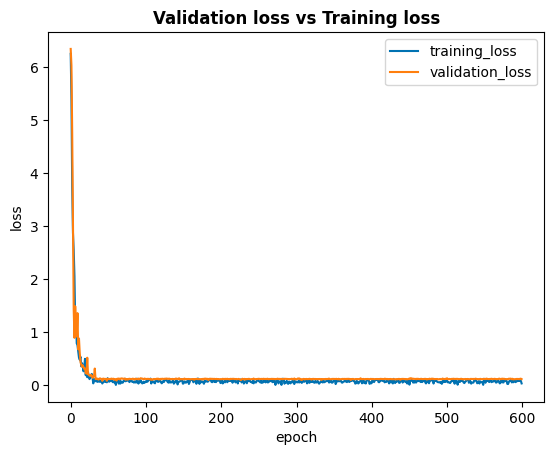

In [336]:
# VAE: PLOT AND SAVE LOSSES

###################################################################################################
########################################  PLOT AND SAVE LOSSES ####################################
###################################################################################################


# PLOT AND SAVE VALIDATION LOSS VS TRAINING LOSS

blue = (0.0, 0.4470588235294118, 0.6980392156862745)
orange = (1.0, 0.4980392156862745, 0.054901960784313725)

if BOOLEAN_plot_vae == True:

    plt.plot(history_vae['loss'],label='training_loss', color = blue)
    plt.plot(history_vae['val_loss'],label='validation_loss', color=orange)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.title('Validation loss vs Training loss', fontweight='bold')
    plt.savefig(os.path.join(save_location_vae,'plot_trn-val_loss.png'), dpi=300)

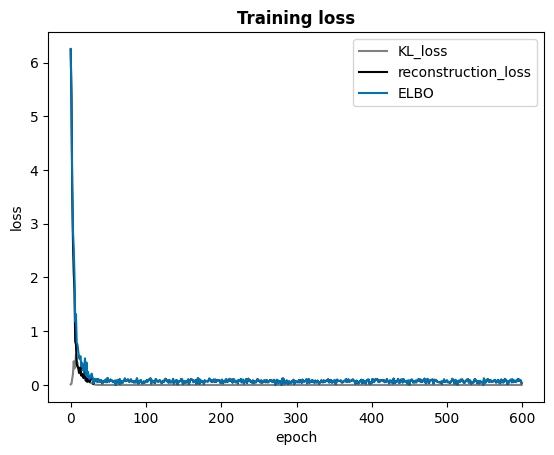

In [337]:
# VAE: PLOT TRAINING LOSS

if BOOLEAN_plot_vae == True:
    plt.plot(history_vae['kl_loss'],label='KL_loss', color= 'grey')
    plt.plot(history_vae['reconstruction_loss'],label='reconstruction_loss', color='black')
    plt.plot(history_vae['loss'],label='ELBO',color=blue)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.title('Training loss', fontweight='bold')
    plt.savefig(os.path.join(save_location_vae,'plot_trn_loss.png'), dpi=300)

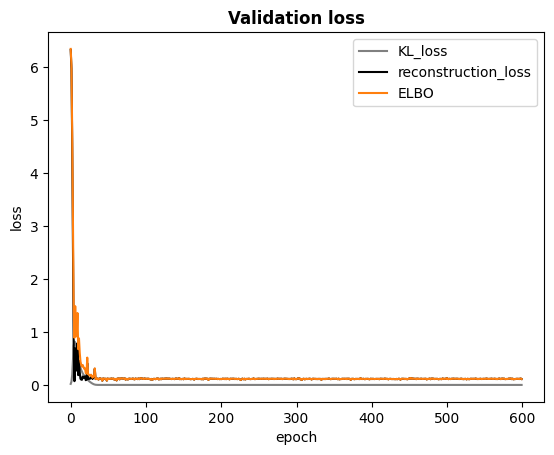

In [338]:
# VAE: PLOT VALIDATION LOSS

if BOOLEAN_plot_vae == True:
    plt.plot(history_vae['val_kl_loss'],label='KL_loss', color= 'grey')
    plt.plot(history_vae['val_reconstruction_loss'],label='reconstruction_loss', color='black')
    plt.plot(history_vae['val_loss'],label='ELBO',color=orange)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.title('Validation loss', fontweight='bold')
    plt.savefig(os.path.join(save_location_vae,'plot_val_loss.png'), dpi=300)

In [339]:
# # VAE: PLOT AND SAVE PREDICTIONS AND GROUND TRUTH

# ###################################################################################################
# ###########################  PLOT AND SAVE PREDICTIONS AND GROUND TRUTH ###########################
# ###################################################################################################

# if BOOLEAN_plot_vae == True:
#     samples_to_test = x_test_vae

#     # reshaping so it can be input inside the encoder with shape (number of items, shape to be input in encoder). here it is (n, 27, 1, 1)
#     sample_shape = (x_test_vae.shape[0],) + i_shape_vae
#     samples_to_test = samples_to_test.reshape(sample_shape)
#     print(samples_to_test.shape)

In [340]:
# # VAE: PLOT AND SAVE PREDICTIONS AND GROUND TRUTH encoder
# ############################################################################# ENCODER

# if BOOLEAN_plot_vae == True:
#     # INPUT TO ENCODER: input should have a shape of the previously trained training data that was previously fed into the encoder as mentioned earlier
#     predicted_scores_encoder = encoder.predict(samples_to_test)

#     # OUTPUT FROM ENCODER: z_mean, z_log_var, z are are the three list of arrays in the order
#     predicted_scores_encoder = np.asarray(predicted_scores_encoder[2])
#     print(predicted_scores_encoder.shape)

#     # Reshaping so shape is (number of items to test, latent dimension) before input into decoder
#     predicted_scores_encoder_shape = (x_test_vae.shape[0], (latent_dim))
#     predicted_scores_encoder = predicted_scores_encoder.reshape(predicted_scores_encoder_shape)
#     print(predicted_scores_encoder.shape)

In [341]:
# # VAE: PLOT AND SAVE PREDICTIONS AND GROUND TRUTH decoder
# ############################################################################# DECODER

# if BOOLEAN_plot_vae == True:

#     # INPUT TO DECODER
#     predicted_scores_decoder = decoder.predict(predicted_scores_encoder)
#     print(predicted_scores_decoder.shape)

#     # OUTPUT FROM DECODER: reshapes output to the form we need as ouptut. if it was a single MNIST image then shape = (image height, image )
#     predicted_scores_decoder_shape = (x_test_vae.shape[0] , i_shape_flat_vae)
#     predicted_scores_decoder = predicted_scores_decoder.reshape(predicted_scores_decoder_shape)

#     # SAVING PREDICTED SCORES FROM ENCODER AND DECODER - these are NOT the same as input. they have to be reshaped
#     predict_path = "predict"
#     loc_predicted_encoder = os.path.join(save_location_vae, "predicted_encoder_ID.csv")
#     loc_predicted_decoder = os.path.join(save_location_vae, "predicted_decoder_ID.csv")
#     np.savetxt(loc_predicted_encoder, predicted_scores_encoder, delimiter=",")
#     np.savetxt(loc_predicted_decoder, predicted_scores_decoder, delimiter=",")

In [342]:
# # VAE: PLOT AND SAVE PREDICTIONS AND GROUND TRUTH save
# if BOOLEAN_plot_vae == True:

#     # PREDICTION FROM DECODER VS GROUND TRUTH FOR x_test_vae
#     prediction = predicted_scores_decoder*np.max(dataset)
#     prediction = prediction.tolist()
#     # prediction = [round(float(i),1) for i in prediction]

#     ground_truth = x_test_vae.reshape(predicted_scores_decoder_shape)
#     ground_truth = ground_truth*np.max(dataset)
#     ground_truth = ground_truth.tolist()
#     # ground_truth = [round(i,1) for i in ground_truth]

#     prediction_dict = {}
#     ground_truth_dict = {}
#     for i, val in enumerate(remaining_indices):
#         prediction_dict[f"mesh_{val}"] = prediction[i]
#         ground_truth_dict[f"mesh_{val}"] = ground_truth[i]


#     # IF THICKNESS IS A FEATURE
#     if BOOLEAN_thickness_vae == 'feature':
#         prediction_thickness_dict = {}
#         prediction_fd_dict  = {}

#         for mesh in prediction_dict:
#             prediction_thickness_dict[mesh]= round(prediction_dict[mesh][-1],3)
#             prediction_fd_dict[mesh]= prediction_dict[mesh][:-1]

#         prediction_df = pd.DataFrame(prediction_fd_dict)

#         loc_prediction_thickness = os.path.join(save_location_vae, "TEST_prediction_thickness.csv")
#         with open(loc_prediction_thickness, 'w') as file:
#             json.dump(prediction_thickness_dict, file)
            
#         for mesh in ground_truth_dict:
#             ground_truth_dict[mesh] = ground_truth_dict[mesh][:-1]

#     else:
#         prediction_df = pd.DataFrame(prediction_dict)


#     prediction_df = prediction_df.round(decimals=1)
#     ground_truth_df = pd.DataFrame(ground_truth_dict)
#     ground_truth_df = ground_truth_df.round(decimals=1)

#     # SAVE ground_truth
#     loc_ground_truth = os.path.join(save_location_vae, "TEST_ground_truth.csv")
#     ground_truth_df.to_csv(loc_ground_truth, index=False)

#     # SAVE predictions
#     loc_prediction = os.path.join(save_location_vae, "TEST_prediction.csv")
#     prediction_df.to_csv(loc_prediction,index=False)


        

In [343]:
# # VAE: PLOT AND SAVE PREDICTION PATTERN

# if BOOLEAN_plot_vae == True:
#     if BOOLEAN_thickness_vae == 'feature':
#         dict_to_plot = prediction_fd_dict
#     else:
#         dict_to_plot = prediction_dict       
#     plt.figure(figsize=(8,3))
#     counter = 0
#     for i, key in enumerate(dict_to_plot.keys()):
#         value =dict_to_plot[key]
#         num = len(list(dict_to_plot.keys()))
#         num_per_colour = num/len(colour_list_5)
#         colour_chosen = colour_list_5[math.floor(i/num_per_colour)]
#         if counter >= num_per_colour:
#             counter = 0
#         counter+=1
#         alpha_chosen = counter/(num_per_colour)
#         plt.plot(value, label=f"{key}", color = colour_chosen, alpha = alpha_chosen)

#     # Customize the plot (add labels, title, etc.)
#     plt.xlabel("Polyedge_index")
#     plt.ylabel("Force_densities")
#     plt.title("Predicted force densities")
#     plt.xticks(range(27))
#     # plt.legend(loc = 'upper left')
#     # Show the plot
#     plt.savefig(os.path.join(save_location_vae, f'plot_prediction_pattern.png'), dpi=300, bbox_inches='tight')    

In [344]:
# # VAE: PLOT AND SAVE PREDICTIONS AND GROUND TRUTH plot

# #########################################  PLOTTING GROUND TRUTH AGAINST PREDICTIONS

# if BOOLEAN_plot_vae == True:

#     meshes_to_plot = 5

#     # these are the 10 randomly sampled x_test_vae meshes
#     chosen_meshes =  remaining_indices.tolist()
#     chosen_mesh_1 = chosen_meshes[:5]
#     chosen_mesh_2 = chosen_meshes[5:]

#     def plot_prediction_ground_truth(prediction_dictionary, ground_truth_dict, chosen_mesh, meshes_to_plot, save_location,fig_number):
#         counter = 0

#         fig, axs = plt.subplots(meshes_to_plot, 1, figsize=(8, meshes_to_plot*3))

#         for i, val in enumerate(chosen_mesh):
#             axs[i].plot(range(len(prediction_dictionary[f"mesh_{val}"])), prediction_dictionary[f"mesh_{val}"], color='red', label="prediction")
#             axs[i].plot(range(len(ground_truth_dict[f"mesh_{val}"])), ground_truth_dict[f"mesh_{val}"], color='green', linestyle='dashed', label="ground_truth")
#             axs[i].set_xlabel('Polyedge_index')
#             axs[i].set_xticks(range(0, 27))
#             axs[i].set_ylabel('Force_densities')
#             axs[i].set_title(f'mesh_{val}', fontweight='bold')
#             axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
#             counter += 1
#             if counter >= meshes_to_plot:
#                 break

#         plt.tight_layout()
#         plt.savefig(os.path.join(save_location_vae, f'plot_prediction_ground_truth_{fig_number}.png'), dpi=300)

#     if BOOLEAN_thickness_vae=='feature':
#         plot_prediction_ground_truth(prediction_fd_dict, ground_truth_dict, chosen_mesh_1, meshes_to_plot, save_location_vae, '1')
#         plot_prediction_ground_truth(prediction_fd_dict, ground_truth_dict, chosen_mesh_2, meshes_to_plot, save_location_vae, '2')
#     else:
#         plot_prediction_ground_truth(prediction_dict, ground_truth_dict, chosen_mesh_1, meshes_to_plot, save_location_vae, '1')
#         plot_prediction_ground_truth(prediction_dict, ground_truth_dict, chosen_mesh_2, meshes_to_plot, save_location_vae, '2')

311/311 [==============================] - 1s 1ms/step


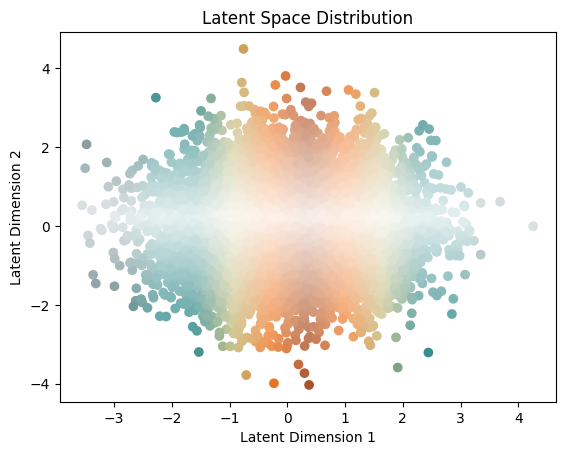

In [345]:
# VAE: PLOT AND SAVE LATENT DIMENSION SPACE


from matplotlib.colors import LinearSegmentedColormap

def plot_custom_colormap(x, y, colors):
    """
    Plots a scatter plot with a custom colormap and opacity gradient.
    
    Parameters:
    - x: array-like, the x-coordinates of the points.
    - y: array-like, the y-coordinates of the points.
    - colors: list of tuples, colors for the custom colormap.
    """
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    
    # Normalize x to range [0, 1] to map it to the colormap
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

    # Create an array to hold the RGBA values
    colors_rgba = cmap(x_norm)

    # Normalize y to range [0, 1] to map it to opacity
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    colors_rgba[:, 3] = 1 - y_norm  # Decrease opacity as y increases

    # Plot the data
    plt.scatter(x, y, color=colors_rgba)
    plt.title('Scatter Plot with Custom Colormap and Opacity Gradient')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


def plot_custom_colormap_lighten(x, y, colors, contrast=1.0):
    """
    Plots a scatter plot with a custom colormap and lightens the color based on the y-coordinate.
    
    Parameters:
    - x: array-like, the x-coordinates of the points.
    - y: array-like, the y-coordinates of the points.
    - colors: list of tuples, colors for the custom colormap.
    - contrast: float, a value between 0 and 1 that controls the contrast between dark and light colors.
    """
    if not 0 <= contrast <= 1:
        raise ValueError("Contrast must be between 0 and 1")
    
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    
    # Normalize x to range [0, 1] to map it to the colormap
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

    # Create an array to hold the RGBA values
    colors_rgba = cmap(x_norm)

    # Normalize y to range [0, 1] to map it to lightening
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

    # Lighten the color based on y and contrast
    for i in range(len(colors_rgba)):
        colors_rgba[i, :3] = colors_rgba[i, :3] + (1 - colors_rgba[i, :3]) * y_norm[i] * contrast

    # Plot the data
    plt.scatter(x, y, color=colors_rgba)
    plt.title('Latent Space Distribution')
    plt.xlabel(f'Latent Dimension 1')
    plt.ylabel(f'Latent Dimension 2')
    plt.savefig(os.path.join(save_location_vae,'plot_latent_space_distribution_z.png'), dpi=300)
    plt.show()

def plot_custom_colormap_lighten_centre(x, y, colors, contrast=1.0):
    """
    Plots a scatter plot with a custom colormap and lightens the color based on the y-coordinate.

    Parameters:
    - x: array-like, the x-coordinates of the points.
    - y: array-like, the y-coordinates of the points.
    - colors: list of tuples, colors for the custom colormap.
    - contrast: float, a value between 0 and 1 that controls the contrast between dark and light colors.
    - save_location_vae: string, the directory where the plot will be saved.
    """
    if not 0 <= contrast <= 1:
        raise ValueError("Contrast must be between 0 and 1")
    
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    
    # Normalize x to range [0, 1] to map it to the colormap
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

    # Create an array to hold the RGBA values
    colors_rgba = cmap(x_norm)

    # Normalize y to range [0, 1] to map it to lightening (center values darker, edges lighter)
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    y_centered = 1 - np.abs(y_norm - 0.5) * 2  # Center values darker, edges lighter

    # Lighten the color based on y and contrast
    for i in range(len(colors_rgba)):
        colors_rgba[i, :3] = colors_rgba[i, :3] + (1 - colors_rgba[i, :3]) * y_centered[i] * contrast

    # Plot the data
    plt.scatter(x, y, color=colors_rgba)
    plt.title('Latent Space Distribution')
    plt.xlabel(f'Latent Dimension 1')
    plt.ylabel(f'Latent Dimension 2')
    plt.savefig(os.path.join(save_location_vae, 'plot_latent_space_distribution_z.png'), dpi=300)
    plt.show()

###################################################################################################
###########################  PLOT AND SAVE LATENT DIMENSION SPACE  ################################
###################################################################################################
if BOOLEAN_plot_vae == True:

    import colorsys
    import itertools

    # Visualize inputs mapped to the Latent space
    # Remember that we have encoded inputs to latent space dimension = 2. 
    # Extract z_mu --> first parameter in the result of encoder prediction representing mean

    dim_list = list(range(latent_dim))
    combinations = list(itertools.combinations(range(latent_dim), 2))


    ###############################################################  COLOURS

    # Define the base hue and saturation
    base_hue = 0.3 # Hue value in range [0, 1]
    saturation_factor = 0.5  # Adjust saturation factor as needed

    # Define colors for each combination with adjusted saturation
    colors = []
    for idx in range(len(combinations)):
        hue = (base_hue + (idx * 0.3)) % 1  # Adjust hue slightly for each color
        saturation = saturation_factor
        value = 0.8  # Keep brightness at maximum
        rgb_color = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append(rgb_color)

    


    ###############################################################  PLOT
    from matplotlib.colors import LinearSegmentedColormap
    
    # Create a colormap from red to blue
    cmap = plt.get_cmap("PuOr")
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    if latent_dim ==2:
        mu, z_log_var, z = encoder.predict((x_train_vae, y_train_vae))
        x = z[:, 0]
        y=  z[:, 1]
        
        plot_custom_colormap_lighten_centre(x,y,colour_list_13,contrast =0.9)
        # # Normalize the data to [0, 1] for colormap mapping
        # norm = plt.Normalize(z[:, 1].min(), z[:, 1].max())

        # # Scatter plot of latent dimensions
        # plt.figure(figsize=(6, 6))
        # plt.scatter(z[:, 0], z[:, 1], alpha=0.5, c=cmap(norm(z[:, 1])), cmap="custom_cmap", edgecolor="k")
        # plt.title('Latent Space Distribution', fontweight='bold')
        # plt.xlabel('Latent Dimension 1')
        # plt.ylabel('Latent Dimension 2')
        # plt.grid(True)
        # plt.savefig(os.path.join(save_location_vae, 'plot_latent_space_distribution_z.png'), dpi=300)
        # plt.show()

    else:
        # Plot each pair of latent dimensions
        num_plots = len(combinations)
        num_rows = (num_plots + 1) // 2  # Calculate number of rows needed for the grid
        fig, axs = plt.subplots(num_rows, 2, figsize=(12, num_rows*6))


        for idx, (i, j) in enumerate(combinations):
            mu, z_log_var, z = encoder.predict((x_train_vae, y_train_vae))
            
            # Calculate subplot index
            row_idx = idx // 2
            col_idx = idx % 2

            # Plot the latent dimensions with specific color
            axs[row_idx, col_idx].scatter(z[:, i], z[:, j], color=colour_list[idx])
            axs[row_idx, col_idx].set_title('Latent Space Distribution')
            axs[row_idx, col_idx].set_xlabel(f'latent_dim_{i}')
            axs[row_idx, col_idx].set_ylabel(f'latent_dim_{j}')

        # Hide any unused subplots
        for idx in range(num_plots, num_rows * 2):
            row_idx = idx // 2
            col_idx = idx % 2
            fig.delaxes(axs[row_idx, col_idx])

        plt.tight_layout()
        plt.savefig(os.path.join(save_location_vae,'plot_latent_space_distribution_z.png'), dpi=300)

In [346]:
# # VAE: PLOT AND SAVE LATENT DIMENSION SPACE


# from matplotlib.colors import LinearSegmentedColormap

# def plot_custom_colormap(x, y, colors):
#     """
#     Plots a scatter plot with a custom colormap and opacity gradient.
    
#     Parameters:
#     - x: array-like, the x-coordinates of the points.
#     - y: array-like, the y-coordinates of the points.
#     - colors: list of tuples, colors for the custom colormap.
#     """
#     # Create a custom colormap
#     cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    
#     # Normalize x to range [0, 1] to map it to the colormap
#     x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

#     # Create an array to hold the RGBA values
#     colors_rgba = cmap(x_norm)

#     # Normalize y to range [0, 1] to map it to opacity
#     y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
#     colors_rgba[:, 3] = 1 - y_norm  # Decrease opacity as y increases

#     # Plot the data
#     plt.scatter(x, y, color=colors_rgba)
#     plt.title('Scatter Plot with Custom Colormap and Opacity Gradient')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.show()


# def plot_custom_colormap_lighten(x, y, colors, contrast=1.0):
#     """
#     Plots a scatter plot with a custom colormap and lightens the color based on the y-coordinate.
    
#     Parameters:
#     - x: array-like, the x-coordinates of the points.
#     - y: array-like, the y-coordinates of the points.
#     - colors: list of tuples, colors for the custom colormap.
#     - contrast: float, a value between 0 and 1 that controls the contrast between dark and light colors.
#     """
#     if not 0 <= contrast <= 1:
#         raise ValueError("Contrast must be between 0 and 1")
    
#     # Create a custom colormap
#     cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    
#     # Normalize x to range [0, 1] to map it to the colormap
#     x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

#     # Create an array to hold the RGBA values
#     colors_rgba = cmap(x_norm)

#     # Normalize y to range [0, 1] to map it to lightening
#     y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

#     # Lighten the color based on y and contrast
#     for i in range(len(colors_rgba)):
#         colors_rgba[i, :3] = colors_rgba[i, :3] + (1 - colors_rgba[i, :3]) * y_norm[i] * contrast

#     # Plot the data
#     plt.scatter(x, y, color=colors_rgba)
#     plt.title('Latent Space Distribution')
#     plt.xlabel(f'Latent Dimension 1')
#     plt.ylabel(f'Latent Dimension 2')
#     plt.savefig(os.path.join(save_location_vae,'plot_latent_space_distribution_z.png'), dpi=300)
#     plt.show()

# def plot_custom_colormap_lighten_centre(x, y, colors, contrast=1.0):
#     """
#     Plots a scatter plot with a custom colormap and lightens the color based on the y-coordinate.

#     Parameters:
#     - x: array-like, the x-coordinates of the points.
#     - y: array-like, the y-coordinates of the points.
#     - colors: list of tuples, colors for the custom colormap.
#     - contrast: float, a value between 0 and 1 that controls the contrast between dark and light colors.
#     - save_location_vae: string, the directory where the plot will be saved.
#     """
#     if not 0 <= contrast <= 1:
#         raise ValueError("Contrast must be between 0 and 1")
    
#     # Create a custom colormap
#     cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    
#     # Normalize x to range [0, 1] to map it to the colormap
#     x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))

#     # Create an array to hold the RGBA values
#     colors_rgba = cmap(x_norm)

#     # Normalize y to range [0, 1] to map it to lightening (center values darker, edges lighter)
#     y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
#     y_centered = 1 - np.abs(y_norm - 0.5) * 2  # Center values darker, edges lighter

#     # Lighten the color based on y and contrast
#     for i in range(len(colors_rgba)):
#         colors_rgba[i, :3] = colors_rgba[i, :3] + (1 - colors_rgba[i, :3]) * y_centered[i] * contrast

#     # Plot the data
#     plt.scatter(x, y, color=colors_rgba)
#     plt.title('Latent Space Distribution')
#     plt.xlabel(f'Latent Dimension 1')
#     plt.ylabel(f'Latent Dimension 2')
#     plt.savefig(os.path.join(save_location_vae, 'plot_latent_space_distribution_z.png'), dpi=300)
#     plt.show()

# ###################################################################################################
# ###########################  PLOT AND SAVE LATENT DIMENSION SPACE  ################################
# ###################################################################################################
# if BOOLEAN_plot_vae == True:

#     alpha_list = [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2]

#     import colorsys
#     import itertools

#     # Visualize inputs mapped to the Latent space
#     # Remember that we have encoded inputs to latent space dimension = 2. 
#     # Extract z_mu --> first parameter in the result of encoder prediction representing mean

#     dim_list = list(range(latent_dim))
#     combinations = list(itertools.combinations(range(latent_dim), 2))


#     ###############################################################  COLOURS

#     # Define the base hue and saturation
#     base_hue = 0.3 # Hue value in range [0, 1]
#     saturation_factor = 0.5  # Adjust saturation factor as needed

#     # Define colors for each combination with adjusted saturation
#     colors = []
#     for idx in range(len(combinations)):
#         hue = (base_hue + (idx * 0.3)) % 1  # Adjust hue slightly for each color
#         saturation = saturation_factor
#         value = 0.8  # Keep brightness at maximum
#         rgb_color = colorsys.hsv_to_rgb(hue, saturation, value)
#         colors.append(rgb_color)

    


#     ###############################################################  PLOT
#     from matplotlib.colors import LinearSegmentedColormap
    
#     # Create a colormap from red to blue
#     cmap = plt.get_cmap("PuOr")
#     cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

#     if latent_dim ==2:
#         mu, z_log_var, z = encoder.predict((x_train_vae, y_train_vae))
#         decoded  = decoder.predict(encoder.predict(x_train_vae)).reshape(-1,28)
#         x = z[:, 0]
#         y=  z[:, 1]
        
#         # plot_custom_colormap_lighten_centre(x,y,colour_list_13,contrast =0.9)
#         # # Normalize the data to [0, 1] for colormap mapping
#         # norm = plt.Normalize(z[:, 1].min(), z[:, 1].max())

#         # # Scatter plot of latent dimensions
#         # plt.figure(figsize=(6, 6))
#         # plt.scatter(z[:, 0], z[:, 1], alpha=0.5, c=cmap(norm(z[:, 1])), cmap="custom_cmap", edgecolor="k")
#         # plt.title('Latent Space Distribution', fontweight='bold')
#         # plt.xlabel('Latent Dimension 1')
#         # plt.ylabel('Latent Dimension 2')
#         # plt.grid(True)
#         # plt.savefig(os.path.join(save_location_vae, 'plot_latent_space_distribution_z.png'), dpi=300)
#         # plt.show()

   

In [347]:
# VAE: MNIST PLOT SAMPLES ACROSS DIMENSIONS

if BOOLEAN_dataset == 'MNIST':
    # SELECT THE LABEL TO BE SAMPLED
    labels_cvae_value = 9 

    #Let us automate this process by generating multiple images and plotting
    #Use decoder to generate images by tweaking latent variables from the latent space
    #Create a grid of defined size with zeros. 
    #Take sample from some defined linear space. In this example range [-4, 4]
    #Feed it to the decoder and update zeros in the figure with output.


    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([labels_cvae_value]).reshape(1,1)

    img_width=28
    img_height=28
    num_channels=1

    if BOOLEAN_dataset =='MNIST':
        n = 20  # generate 15x15 digits
        figure = np.zeros((img_width * n, img_height * n, num_channels))


        #Create a Grid of latent variables, to be provided as inputs to decoder.predict
        #Creating vectors within range -5 to 5 as that seems to be the range in latent space
        grid_x = np.linspace(-5, 5, n)
        grid_y = np.linspace(-5, 5, n)[::-1]

        # decoder for each square in the grid
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict([z_sample, c_height])
                digit = x_decoded[0].reshape(img_width, img_height, num_channels)
                figure[i * img_width: (i + 1) * img_width,
                    j * img_height: (j + 1) * img_height] = digit

        plt.figure(figsize=(10, 10))
        #Reshape for visualization
        fig_shape = np.shape(figure)
        figure = figure.reshape((fig_shape[0], fig_shape[1]))

        plt.imshow(figure, cmap='gnuplot2')
        plt.savefig(os.path.join(save_location_vae,f'plot_sampling_across_dimensions_{labels_cvae_value}.png'), dpi=300)
        plt.show()  


In [348]:
# VAE: MNIST PLOT SAMPLE

if BOOLEAN_dataset == 'MNIST':
    # SELECT THE LABEL TO BE SAMPLED
    labels_cvae_value = 1.5 

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)

    sample_vector = np.array([[0,2]])
    print(sample_vector.shape)
    decoded_example = decoder.predict([sample_vector,c_height])
    print(decoded_example.shape)
    decoded_example_reshaped = decoded_example.reshape(28, 28)
    print(decoded_example_reshaped.shape)
    plt.imshow(decoded_example_reshaped)

(1, 2)
(1, 58)
1/1 [==============================] - 0s 52ms/step
(1, 27)
[3.6773872 2.884586  3.5146532 3.5489926 3.7885277 3.5560796 3.6297233
 4.6792254 3.2735114 3.0603967 3.1329124 3.0275052 3.1673    3.328795
 3.4004805 2.9096806 3.60831   3.3829818 3.1198792 3.2773025 3.8374522
 3.3714023 3.063885  3.1618123 3.228295  3.1851985 3.0216188]


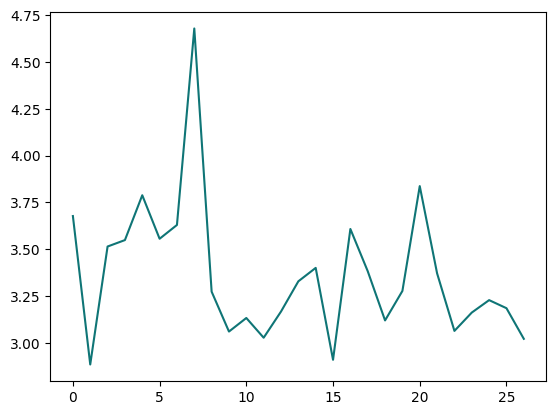

In [349]:
# VAE: Visualize single samples

if BOOLEAN_dataset != 'MNIST':
    # SELECT THE LABEL TO BE SAMPLED
    labels_cvae_value = 1.5 

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)

    if BOOLEAN_plot_vae == True:
        #Single decoded image with random input latent vector (of size 1x2)
        #Latent space range is about -5 to 5 so pick random values within this range
        #Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
        #one image to the other.
        sample_vector = np.array([[ 0.9502745 , -1.4800116 ]])
        print(sample_vector.shape)
        print(c_height.shape)
        
        # conditioned_vector = np.concatenate([sample_vector, c_height],axis=1) 
        # print(f'conditioned vector shape = {conditioned_vector.shape}')

        decoded_example = decoder.predict([sample_vector,c_height])[:,:-1]
        print(decoded_example.shape)
        decoded_example_reshaped = decoded_example.reshape(27)*np.max(dataset)
        print(decoded_example_reshaped)

        plt.plot( range(len(decoded_example_reshaped)), np. round(decoded_example_reshaped,5), color = colour_teal)
        plt.show()

In [350]:
# # VAE: SCROLLING ACROSS LATENT SPACE LINEAR 

# if BOOLEAN_plot_vae == True:
#     #Let us automate this process by generating multiple images and plotting
#     #Use decoder to generate images by tweaking latent variables from the latent space
#     #Create a grid of defined size with zeros. 
#     #Take sample from some defined linear space. In this example range [-4, 4]
#     #Feed it to the decoder and update zeros in the figure with output.

#     img_width = 28

#     n = 5  # generate 15x15 digits
#     # figure = np.zeros((img_width * n, 1 * n, num_channels))
#     #Create a Grid of latent variables, to be provided as inputs to decoder.predict
#     #Creating vectors within range -5 to 5 as that seems to be the range in latent space
#     grid_x = np.linspace(-2, 2, n)
#     grid_y = np.linspace(-2, 2, n)

#     #######################################################################################################

#     # ACROSS DIMENSION 1

#     # Create a 5x5 grid of subplots
#     fig, axs = plt.subplots(n, 1, figsize=(12, 12))


#     # decoder for each square in the grid
#     for i, yi in enumerate(grid_y):
#         for j, xi in enumerate(grid_x):
#             z_sample = np.array([[xi, yi]])
#             x_decoded = decoder.predict([z_sample, c_height])
#             mesh_sample = x_decoded[0].reshape(28)[:-1]*np.max(dataset)
#             thickness = x_decoded[0].reshape(28)[-1]

#             axs[i].plot(range(len(mesh_sample)), mesh_sample, label=f'Dimension {i+1}-{1}', color = colour_list_5[j], alpha=(i+1)/n)
#             axs[i].set_xlabel('Polyedge_index')
#             axs[i].set_ylabel('Force-densities')
#             axs[i].set_title(f'Dimension 2 = {yi}')
#             axs[i].grid(True)
#             axs[i].set_xticks(list(range(len(mesh_sample))))


#     # Add overall title and adjust layout
#     fig.suptitle('Dimension 1: Visualizing Force Densities across dimensions', fontsize=16)
#     plt.tight_layout()

#     # Save or display the plot
#     plt.savefig(os.path.join(save_location_vae,'plot_fd_across_dimension_1.png'), dpi=300)
#     plt.show()

#     #######################################################################################################


#     # ACROSS DIMENSION 2

#     # Create a 5x5 grid of subplots
#     fig, axs = plt.subplots(n, 1, figsize=(12, 12))

#     # decoder for each square in the grid
#     for i, xi in enumerate(grid_x):
#         for j, yi in enumerate(grid_y):
#             z_sample = np.array([[xi, yi]])
#             x_decoded = decoder.predict([z_sample, c_height])
#             mesh_sample = x_decoded[0].reshape(28)[:-1]*np.max(dataset)
#             thickness = x_decoded[0].reshape(28)[-1]

#             axs[i].plot(range(len(mesh_sample)), mesh_sample, label=f'Dimension {i+1}-{1}', color = colour_list_5[i], alpha=(j+1)/n)
#             axs[i].set_xlabel('Polyedge_index')
#             axs[i].set_ylabel('Force-densities')
#             axs[i].set_title(f'Dimension 1 = {xi}')
#             axs[i].grid(True)
#             axs[i].set_xticks(list(range(len(mesh_sample))))


#     # Add overall title and adjust layout
#     fig.suptitle('Dimension 2: Visualizing Force Densities across dimensions', fontsize=16)
#     plt.tight_layout()

#     # Save or display the plot
#     plt.savefig(os.path.join(save_location_vae,'plot_fd_across_dimension_2.png'), dpi=300)
#     plt.show()

In [351]:
# # VAE: VISUALIZING THICKNESS ACROSS DIMENSIONS: LINEAR

# #######################################################################################################

# if BOOLEAN_plot_vae == True:

#     n = 5
#     grid_x = np.linspace(-2, 2, n)
#     grid_y = np.linspace(-2, 2, n)
#     # Set the desired figure size (adjust as needed)
#     fig, ax = plt.subplots(figsize=(5, 4))  # Width: 10 inches, Height: 6 inches
#     # # ACROSS DIMENSION 2

#      # decoder for each square in the grid
#     for i, xi in enumerate(grid_x):
#         for j, yi in enumerate(grid_y):
#             z_sample = np.array([[xi, yi]])
#             x_decoded = decoder.predict([z_sample, c_height])
#             thickness = x_decoded[0].reshape(28)[-1]*np.max(thickness_dataset) if BOOLEAN_thickness_normalization == 'separate' else x_decoded[0].reshape(28)[-1]*np.max(dataset)

#             plt.scatter(xi, thickness, color = colour_list_5[i], alpha= (j+1)/n)
#     plt.xlabel(f'Dimension 1')
#     plt.ylabel('Thickness/m')
#     plt.title(f'Visualizing Thickness across dimensions')
#     plt.grid(True)
#     plt.xticks(list(grid_x))
#     custom_legend = [
#         plt.Line2D([0], [0], color= colour_dark_blue, linestyle='solid', label='Dimension 2: -2.0'),
#         plt.Line2D([0], [0], color= colour_teal, linestyle='solid', label='Dimension 2: -1.0'),
#         plt.Line2D([0], [0], color= colour_gold, linestyle='solid', label='Dimension 2: 0.0'),
#         plt.Line2D([0], [0], color= colour_orange, linestyle='solid', label='Dimension 2: 1.0'),
#         plt.Line2D([0], [0], color= colour_maroon, linestyle='solid', label='Dimension 2: 2.0')
#     ]
#     plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

#     # Add overall title and adjust layout
#     plt.tight_layout()

#     # Save or display the plot
#     plt.savefig(os.path.join(save_location_vae,'plot_thickness_across_dimension.png'), dpi=300, bbox_inches='tight')
#     plt.show()


In [414]:
# SUR: GETTING THE DATASET FOR X_TRAIN_SURR

'''
this part of code is copied from vae_tz_4.ipynb
'''


# converting csv into array
dataset = pd.read_csv(os.path.join(dataset_file_path_sur,'dataset.csv'))
dataset = dataset.values
dataset = dataset.transpose()


###################################################################################################
############################ GENERATE INDICES FOR TEST AND TRAIN DATA #############################
###################################################################################################

'''ONLY GENERATE THIS ONCE FOR A PARTICULAR DATASET SO THE TEST MESHES REMAIN THE SAME!'''

if not (os.path.exists(os.path.join(main_path_sur,'indices_best.json')) or os.path.exists(os.path.join(main_path_sur,f'indices_test_{test_indices_no}.npy')) or os.path.exists(os.path.join(main_path_sur,f'indices_train_{test_indices_no}.npy'))): 
    
    BOOLEAN_generate_indices = True
    print('RUN performance_preprocessing.ipynb to generate indices_test.npy, indices_best.json, and indices_train.npy')

else:    
    BOOLEAN_generate_indices = False

    # Load remaining indices
    remaining_indices = np.load(os.path.join(main_path_sur,f'indices_test_{test_indices_no}.npy'))
    # Load random indices
    random_indices = np.load(os.path.join(main_path_sur,f'indices_train_{test_indices_no}.npy'))
    
    # Load best indices
    with open(os.path.join(main_path_sur,'indices_best_test.json')) as file:
        best_indices = json.load(file)
    # Converting best indices into dictionary for each SSS   
    best_indices_arr = np.array([best_indices['Buckling_Load_Factor'],best_indices['Utilization'],best_indices['Interstorey_Drift_Ratios']])
    best_indices_dict = {}
    best_indices_dict['Buckling_Load_Factor'] = best_indices_arr[0]
    best_indices_dict['Utilization'] = best_indices_arr[1]
    best_indices_dict['Interstorey_Drift_Ratios'] = best_indices_arr[2]


     # best test data
    if BOOLEAN_model_type == 'Buckling_Load_Factor':
        best_indices_arr_chosen = best_indices_arr[0,:]
    elif BOOLEAN_model_type == 'Utilization':
        best_indices_arr_chosen = best_indices_arr[1,:]
    elif BOOLEAN_model_type == 'Interstorey_Drift_Ratios':
        best_indices_arr_chosen = best_indices_arr[2,:]



print(f"Generate indices for train/test data?: {BOOLEAN_generate_indices}")
print(f'test_indices: {remaining_indices.shape}')
print(f'best_indices: {best_indices_arr.shape}')
print(f'train_indices: {random_indices.shape}')

Generate indices for train/test data?: False
test_indices: (50,)
best_indices: (3, 10)
train_indices: (9925,)


In [415]:
# SUR: SPLIT INTO x_test_sur AND x_train_sur. THEN NORMALIZE AND RESHAPE

'''
this part of code is copied from vae_tz_4.ipynb
'''

###################################################################################################
##################################### SPLIT INTO TEST AND TRAIN DATA ##############################
###################################################################################################

# train data
x_train_sur = dataset[random_indices]                                                                  
# test data
x_test_sur = dataset[remaining_indices]
# best test data
if BOOLEAN_model_type not in ['Height', 'Mass']:
    if BOOLEAN_model_type == 'all':
        x_test_best_sur = {}
        x_test_best_sur['Buckling_Load_Factor'] = dataset[best_indices_arr_chosen][0,:,:]
        x_test_best_sur['Utilization'] = dataset[best_indices_arr_chosen][1,:,:]
        x_test_best_sur['Interstorey_Drift_Ratios'] = dataset[best_indices_arr_chosen][2,:,:]
    else:
        x_test_best_sur = dataset[best_indices_arr_chosen]


###################################################################################################
##################################### NORMALIZE AND RESHAPE ######################################
###################################################################################################

# adding the thickness if togther normalization
if BOOLEAN_thickness_normalization == 'together':
    x_train_sur = np.hstack((x_train_sur,train_th))
    x_test_sur = np.hstack((x_test_sur,test_th))
    # best test data
    if BOOLEAN_model_type not in ['Height', 'Mass']:
        if BOOLEAN_model_type == 'all':
            x_test_best_sur['Buckling_Load_Factor'] = np.hstack(( x_test_best_sur['Buckling_Load_Factor'], best_th[0,:,:]))
            x_test_best_sur['Utilization'] = np.hstack(( x_test_best_sur['Utilization'], best_th[1,:,:]))
            x_test_best_sur['Interstorey_Drift_Ratios'] = np.hstack(( x_test_best_sur['Interstorey_Drift_Ratios'], best_th[2,:,:]))
        else:
            x_test_best_sur = np.hstack((x_test_best_sur, best_th))
    
#Norm.
x_train_sur = x_train_sur.astype('float32')
x_test_sur = x_test_sur.astype('float32')
# x_test_best_sur = x_test_best_sur.astype('float32')
x_train_sur = x_train_sur / np.max(dataset)
x_test_sur = x_test_sur / np.max(dataset)

if BOOLEAN_model_type not in ['Height', 'Mass']:
    if BOOLEAN_model_type == 'all':
        x_test_best_sur['Buckling_Load_Factor'] = x_test_best_sur['Buckling_Load_Factor'] / np.max(dataset)
        x_test_best_sur['Utilization'] =  x_test_best_sur['Utilization'] / np.max(dataset) 
        x_test_best_sur['Interstorey_Drift_Ratios'] =  x_test_best_sur['Interstorey_Drift_Ratios'] / np.max(dataset) 
    else:
        x_test_best_sur = x_test_best_sur / np.max(dataset)

# adding the thickness if separate normalization
if BOOLEAN_thickness_normalization == 'separate':
    x_train_sur = np.hstack((x_train_sur,train_th))
    x_test_sur = np.hstack((x_test_sur,test_th))
    # best test data
    if BOOLEAN_model_type not in ['Height', 'Mass']:
        if BOOLEAN_model_type == 'all':
            x_test_best_sur['Buckling_Load_Factor'] = np.hstack(( x_test_best_sur['Buckling_Load_Factor'], best_th[0,:,:]))
            x_test_best_sur['Utilization'] = np.hstack(( x_test_best_sur['Utilization'], best_th[1,:,:]))
            x_test_best_sur['Interstorey_Drift_Ratios'] = np.hstack(( x_test_best_sur['Interstorey_Drift_Ratios'], best_th[2,:,:]))
        else:
            x_test_best_sur = np.hstack((x_test_best_sur, best_th))

# Reshape 
'''
shape of x_train_sur = 7500, 27
shape of y_train_sur = 7500,
shape of x_test_sur = 2500, 27,
shape of y_test_sur = 2500,
'''
img_height = x_train_sur.shape[1]
num_channels = 1 #MNIST --> grey scale so 1 channel
# x_train_sur = x_train_sur.reshape(x_train.shape[0], img_height, 1, num_channels)
# x_test_sur = x_test_sur.reshape(x_test_sur.shape[0], img_height, 1, num_channels)
# input_shape_sur = (img_height, 1, num_channels)
input_shape_sur = (img_height,)





print(f"x_train_sur:{x_train_sur.shape}")
print(input_shape_sur)

x_train_sur:(9925, 28)
(28,)


In [416]:
# SUR: PERFORMANCE DATA - LABELS FOR y_train_sur AND y_test_sur

if BOOLEAN_generate_train_labels == True:

    train_labels_sss = []
    for mesh in pa_dict_sorted['without_failure']:
        train_labels_sss.append(list(pa_dict_sorted['without_failure'][mesh]))

    train_labels_np = np.array(train_labels_sss)
    train_labels_np = train_labels_np.astype('float32')

In [417]:
# SUR: y_train_sur AND y_test_sur

if BOOLEAN_model_type == 'Height':
    train_labels_np = height_dataset
elif BOOLEAN_model_type == 'Mass':
    train_labels_np = mass_dataset

# y_train_sur
y_train_sur = train_labels_np[random_indices]
y_train_sur = y_train_sur.reshape(x_train_sur.shape[0], y_train_sur.shape[1])
# y_test_sur
y_test_sur = train_labels_np[remaining_indices]
y_test_sur = y_test_sur.reshape(x_test_sur.shape[0], y_test_sur.shape[1])
# y_test_best_sur

if BOOLEAN_model_type not in  ['Height', 'Mass']:
    if BOOLEAN_model_type=='all':
        y_test_best_sur = {}
        y_test_best_sur['Buckling_Load_Factor'] = train_labels_np[best_indices_arr_chosen[0,:]]
        y_test_best_sur['Utilization'] = train_labels_np[best_indices_arr_chosen[1,:]]
        y_test_best_sur['Interstorey_Drift_Ratios'] = train_labels_np[best_indices_arr_chosen[2,:]]
        
        y_test_best_sur['Buckling_Load_Factor'] = y_test_best_sur['Buckling_Load_Factor'].reshape(x_test_best_sur['Buckling_Load_Factor'].shape[0], y_test_sur.shape[1])
        y_test_best_sur['Utilization'] = y_test_best_sur['Utilization'].reshape(x_test_best_sur['Utilization'].shape[0], y_test_sur.shape[1])
        y_test_best_sur['Interstorey_Drift_Ratios'] = y_test_best_sur['Interstorey_Drift_Ratios'].reshape(x_test_best_sur['Interstorey_Drift_Ratios'].shape[0], y_test_sur.shape[1])

    else:    
        y_test_best_sur = train_labels_np[best_indices_arr_chosen]
        y_test_best_sur = y_test_best_sur.reshape(x_test_best_sur.shape[0], y_test_sur.shape[1])

print(f"y_train_sur:{y_train_sur.shape}")
print(f"x_train_sur:{x_train_sur.shape}")

y_train_sur:(9925, 1)
x_train_sur:(9925, 28)


In [418]:
# SUR: NORMALIZING THE y_train_sur, y_test_sur 

# Find the maximum value for each of the SSS
max_values_sur = np.max(train_labels_np, axis=0)
print(max_values_sur)

if BOOLEAN_model_type == 'Height':
    max_values_sur_height = max_values_sur

if BOOLEAN_model_type == 'Mass':
    max_values_sur_mass = max_values_sur

if BOOLEAN_model_type in sss:
    max_values_sur_sss = max_values_sur

y_train_sur = y_train_sur / max_values_sur
y_test_sur = y_test_sur / max_values_sur

if BOOLEAN_model_type not in ['Height', 'Mass']:
    if BOOLEAN_model_type=='all':
        for key in y_test_best_sur.keys():
            y_test_best_sur[key] = y_test_best_sur[key] /max_values_sur
    else:
        y_test_best_sur = y_test_best_sur / max_values_sur

[26.7]


In [419]:
print(f'max {BOOLEAN_model_type}: {np.max(train_labels_np, axis=0)}')
print(f'min {BOOLEAN_model_type}: {np.min(train_labels_np, axis=0)}')

max Height: [26.7]
min Height: [0.5]


In [420]:
# SUR: SEPARATE Y_TRAIN AND Y_TEST FOR EACH SSS

if BOOLEAN_model_type not in  ['Height', 'Mass']:
    # separate
    y_train_sur_util = y_train_sur[:,1]
    y_test_sur_util = y_test_sur[:,1]
    y_train_sur_buck = y_train_sur[:,0]
    y_test_sur_buck= y_test_sur[:,0]
    y_train_sur_drift = y_train_sur[:,2]
    y_test_sur_drift= y_test_sur[:,2]

    # reshape
    y_train_sur_util = y_train_sur_util.reshape(-1,1)
    y_test_sur_util = y_test_sur_util.reshape(-1,1)
    y_train_sur_buck = y_train_sur_buck.reshape(-1,1)
    y_test_sur_buck = y_test_sur_buck.reshape(-1,1)
    y_train_sur_drift = y_train_sur_drift.reshape(-1,1)
    y_test_sur_drift = y_test_sur_drift.reshape(-1,1)


'Buckling_Load_Factor', 'Utilization' , 'Interstorey_Drift_Ratios', 'all'

if BOOLEAN_model_type=='all':
    y_train_sur_chosen = y_train_sur
    y_test_sur_chosen = y_test_sur
    loss_count = ["mse","mse","mse"]
    y_test_best_sur_chosen = y_test_best_sur
    print('all chosen')

elif BOOLEAN_model_type=='Buckling_Load_Factor':
    y_train_sur_chosen = y_train_sur_buck
    y_test_sur_chosen = y_test_sur_buck
    loss_count = ["mse"]
    print('Buckling_Load_Factor chosen')
    y_test_best_sur_chosen = y_test_best_sur[:,0].reshape(-1,1)

elif BOOLEAN_model_type=='Utilization':
    y_train_sur_chosen = y_train_sur_util
    y_test_sur_chosen = y_test_sur_util
    loss_count = ["mse"]
    print('Utilization chosen')
    y_test_best_sur_chosen = y_test_best_sur[:,1].reshape(-1,1)
    
elif BOOLEAN_model_type=='Interstorey_Drift_Ratios':   
    y_train_sur_chosen = y_train_sur_drift
    y_test_sur_chosen = y_test_sur_drift
    loss_count = ["mse"]
    print('Interstorey_Drift_Ratios chosen')
    y_test_best_sur_chosen = y_test_best_sur[:,2].reshape(-1,1)

else:
    y_train_sur_chosen = y_train_sur
    y_test_sur_chosen = y_test_sur
    loss_count = ["mse"]
    print(BOOLEAN_model_type)



print(f'y_train_chosen shape: {y_train_sur_chosen.shape}')
print(f'y_test_chosen shape: {y_test_sur_chosen.shape}')
if BOOLEAN_model_type =='all':
    print(f"y_test_best_chosen shape[key]: {y_test_best_sur_chosen['Buckling_Load_Factor'].shape}")
elif BOOLEAN_model_type in sss:
    print(f'y_test_best_chosen shape: {y_test_best_sur_chosen.shape}')


Height
y_train_chosen shape: (9925, 1)
y_test_chosen shape: (50, 1)


In [421]:
# SUR: BUCKLING - ARCHITECTURE OF THE SURROGATE MODEL

'''
this normalizes the samples along the feature axis. for example: 

Original Data:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Normalized Data:
[[-1.2247448 -1.2247448 -1.2247448]
 [ 0.         0.         0.       ]
 [ 1.2247448  1.2247448  1.2247448]]

 [x,y,z] are the three features of these points. Normalization is done across the feature axis (axis=1) so across 1,4,7 and 2,5,6 and 7,8,
'''

if BOOLEAN_model_type == 'Buckling_Load_Factor':
    # Define a normalizer
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=1)

    # neurons of each dense layer [layer1, layer2...]
    if BOOLEAN_model_type == 'all':
        last_neuron = 3
    else:
        last_neuron = 1

    neurons_surr = [256,128,last_neuron]
    # activation function of each dense layer [layer1, layer2...]
    act_func_surr = ["relu","relu","relu"]

    def build_and_compile_model_buckling(normalizer):
        model = keras.Sequential([
            keras.Input(shape=(input_shape_sur)),
            layers.Flatten(),
            layers.Dense(neurons_surr[0], activation= act_func_surr[0]),
            layers.Dense(neurons_surr[1], activation= act_func_surr[1]),
            layers.Dense(neurons_surr[2], activation= act_func_surr[2])
            # layers.Dense(neurons_surr[3], activation= act_func_surr[3])
            # layers.Dense(neurons_surr[4], activation= act_func_surr[4])
            # layers.Dense(neurons_surr[5], activation= act_func_surr[5])
        ])


        return model

In [422]:
# SUR: UTILIZATION - ARCHITECTURE OF THE SURROGATE MODEL

'''
this normalizes the samples along the feature axis. for example: 

Original Data:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Normalized Data:
[[-1.2247448 -1.2247448 -1.2247448]
 [ 0.         0.         0.       ]
 [ 1.2247448  1.2247448  1.2247448]]

 [x,y,z] are the three features of these points. Normalization is done across the feature axis (axis=1) so across 1,4,7 and 2,5,6 and 7,8,
'''

if BOOLEAN_model_type == 'Utilization':
    # Define a normalizer
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=1)

    # neurons of each dense layer [layer1, layer2...]
    if BOOLEAN_model_type == 'all':
        last_neuron = 3
    else:
        last_neuron = 1

    neurons_surr = [512,256,128,last_neuron]
    # activation function of each dense layer [layer1, layer2...]
    act_func_surr = ["relu","relu","relu","relu"]

    def build_and_compile_model_utilization(normalizer):
        model = keras.Sequential([
            keras.Input(shape=(input_shape_sur)),
            layers.Flatten(),
            layers.Dense(neurons_surr[0], activation= act_func_surr[0]),
            layers.Dense(neurons_surr[1], activation= act_func_surr[1]),
            layers.Dense(neurons_surr[2], activation= act_func_surr[2]),
            layers.Dense(neurons_surr[3], activation= act_func_surr[3])
            # layers.Dense(neurons_surr[4], activation= act_func_surr[4])
            # layers.Dense(neurons_surr[5], activation= act_func_surr[5])
        ])


        return model

In [423]:
# SUR: INTERSTOREY DRIFT RATIOS - ARCHITECTURE OF THE SURROGATE MODEL

'''
this normalizes the samples along the feature axis. for example: 

Original Data:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Normalized Data:
[[-1.2247448 -1.2247448 -1.2247448]
 [ 0.         0.         0.       ]
 [ 1.2247448  1.2247448  1.2247448]]

 [x,y,z] are the three features of these points. Normalization is done across the feature axis (axis=1) so across 1,4,7 and 2,5,6 and 7,8,
'''

if BOOLEAN_model_type == 'Interstorey_Drift_Ratios':
    # Define a normalizer
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=1)

    # neurons of each dense layer [layer1, layer2...]
    if BOOLEAN_model_type == 'all':
        last_neuron = 3
    else:
        last_neuron = 1

    neurons_surr = [512,256,last_neuron]
    # activation function of each dense layer [layer1, layer2...]
    act_func_surr = ["relu","relu","relu"]

    def build_and_compile_model_drift(normalizer):
        model = keras.Sequential([
            keras.Input(shape=(input_shape_sur)),
            layers.Flatten(),
            layers.Dense(neurons_surr[0], activation= act_func_surr[0]),
            layers.Dense(neurons_surr[1], activation= act_func_surr[1]),
            layers.Dense(neurons_surr[2], activation= act_func_surr[2])
            # layers.Dense(neurons_surr[3], activation= act_func_surr[3])
            # layers.Dense(neurons_surr[4], activation= act_func_surr[4])
            # layers.Dense(neurons_surr[5], activation= act_func_surr[5])
        ])


        return model

In [424]:
# SUR: HEIGHT - ARCHITECTURE OF THE SURROGATE MODEL

'''
this normalizes the samples along the feature axis. for example: 

Original Data:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Normalized Data:
[[-1.2247448 -1.2247448 -1.2247448]
 [ 0.         0.         0.       ]
 [ 1.2247448  1.2247448  1.2247448]]

 [x,y,z] are the three features of these points. Normalization is done across the feature axis (axis=1) so across 1,4,7 and 2,5,6 and 7,8,
'''

if BOOLEAN_model_type == 'Height':
    # Define a normalizer
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=1)

    # neurons of each dense layer [layer1, layer2...]
    if BOOLEAN_model_type == 'all':
        last_neuron = 3
    else:
        last_neuron = 1

    neurons_surr = [256,128,last_neuron]
    # activation function of each dense layer [layer1, layer2...]
    act_func_surr = ["relu","relu","relu"]

    def build_and_compile_model_height(normalizer):
        model = keras.Sequential([
            keras.Input(shape=(input_shape_sur)),
            layers.Flatten(),
            layers.Dense(neurons_surr[0], activation= act_func_surr[0]),
            layers.Dense(neurons_surr[1], activation= act_func_surr[1]),
            layers.Dense(neurons_surr[2], activation= act_func_surr[2])
            # layers.Dense(neurons_surr[3], activation= act_func_surr[3])
            # layers.Dense(neurons_surr[4], activation= act_func_surr[4])
            # layers.Dense(neurons_surr[5], activation= act_func_surr[5])
        ])


        return model

In [425]:
# SUR: MASS - ARCHITECTURE OF THE SURROGATE MODEL

'''
this normalizes the samples along the feature axis. for example: 

Original Data:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

Normalized Data:
[[-1.2247448 -1.2247448 -1.2247448]
 [ 0.         0.         0.       ]
 [ 1.2247448  1.2247448  1.2247448]]

 [x,y,z] are the three features of these points. Normalization is done across the feature axis (axis=1) so across 1,4,7 and 2,5,6 and 7,8,
'''

if BOOLEAN_model_type == 'Mass':
    # Define a normalizer
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=1)

    # neurons of each dense layer [layer1, layer2...]
    if BOOLEAN_model_type == 'all':
        last_neuron = 3
    else:
        last_neuron = 1

    neurons_surr = [512,256,128,last_neuron]
    # activation function of each dense layer [layer1, layer2...]
    act_func_surr = ["relu","relu","relu","relu"]

    def build_and_compile_model_mass(normalizer):
        model = keras.Sequential([
            keras.Input(shape=(input_shape_sur)),
            layers.Flatten(),
            layers.Dense(neurons_surr[0], activation= act_func_surr[0]),
            layers.Dense(neurons_surr[1], activation= act_func_surr[1]),
            layers.Dense(neurons_surr[2], activation= act_func_surr[2]),
            layers.Dense(neurons_surr[3], activation= act_func_surr[3])
            # layers.Dense(neurons_surr[4], activation= act_func_surr[4])
            # layers.Dense(neurons_surr[5], activation= act_func_surr[5])
        ])


        return model

In [426]:
# SUR: COMPILING AND SETTING UP TRAINING

###################################################################################################
############################################  TRAINING    #########################################
###################################################################################################

print("Starting Training of Surrogate Model!")

if BOOLEAN_model_type == 'Buckling_Load_Factor':
    sur_model_dict['Buckling_Load_Factor'] = build_and_compile_model_buckling(normalizer)
    sur_model_dict['Buckling_Load_Factor'].compile(loss= loss_count, optimizer=tf.keras.optimizers.Adam(learn_rate_sur, clipnorm=1.), metrics=['accuracy'])

elif BOOLEAN_model_type == 'Utilization':
    sur_model_dict['Utilization'] = build_and_compile_model_utilization(normalizer)
    sur_model_dict['Utilization'].compile(loss= loss_count, optimizer=tf.keras.optimizers.Adam(learn_rate_sur, clipnorm=1.), metrics=['accuracy'])

elif BOOLEAN_model_type == 'Interstorey_Drift_Ratios':
    sur_model_dict['Interstorey_Drift_Ratios'] = build_and_compile_model_drift(normalizer)
    sur_model_dict['Interstorey_Drift_Ratios'].compile(loss= loss_count, optimizer=tf.keras.optimizers.Adam(learn_rate_sur, clipnorm=1.), metrics=['accuracy'])

elif BOOLEAN_model_type == 'Height':
    sur_model_dict['Height'] = build_and_compile_model_height(normalizer)
    sur_model_dict['Height'].compile(loss= loss_count, optimizer=tf.keras.optimizers.Adam(learn_rate_sur, clipnorm=1.), metrics=['accuracy'])

elif BOOLEAN_model_type == 'Mass':
    sur_model_dict['Mass'] = build_and_compile_model_mass(normalizer)
    sur_model_dict['Mass'].compile(loss= loss_count, optimizer=tf.keras.optimizers.Adam(learn_rate_sur, clipnorm=1.), metrics=['accuracy'])



Starting Training of Surrogate Model!


In [427]:
# SUR: LOAD WEIGHTS
surr_weights_path_load = os.path.join(main_path_sur,load_file_path_sur[BOOLEAN_model_type],'weights_surrogate_model.h5')
sur_history_path_load = os.path.join(main_path_sur,load_file_path_sur[BOOLEAN_model_type],'trainHistoryDict_sur.pkl')


if BOOLEAN_load_file_sur == True:

    sur_model_dict[BOOLEAN_model_type].load_weights(surr_weights_path_load)
    sur_model = sur_model_dict[BOOLEAN_model_type]
    print('Weights have been loaded')

    with open(sur_history_path_load, 'rb') as file_pi:
        history_sur = pickle.load(file_pi)
    print("History_sur have been loaded")
    print(f"SURROGATE MODEL = {BOOLEAN_model_type}")
else:
    print('No weights loaded. Training will be carried out')

Weights have been loaded
History_sur have been loaded
SURROGATE MODEL = Height


In [428]:
# SUR: TRAINING

if BOOLEAN_load_file_sur == False:
    history_sur = sur_model.fit(x_train_sur, y_train_sur_chosen, validation_split=val_split, verbose=2, epochs=epoch_number_sur, batch_size=batch_size_number_sur)
    print("Training Of Surrogate Model is Finished")

    history_sur = history_sur.history
else:
    print('NO TRAINING of surrogate required')

NO TRAINING of surrogate required


In [429]:
# SUR: GETTING THE SUMMARY / DESCRIPTION 

# sur_model.summary()

###################################################################################################
########################  GETTING THE SUMMARY / DESCRIPTION / HYPERPARAMETERS    ##################
###################################################################################################


import re

################################### converting encoder summary into list
stringlist = []
sur_model.summary(print_fn=lambda x: stringlist.append(x))
summ_string = "\n".join(stringlist)

table = stringlist[1:-4][1::2] # take every other element and remove appendix

new_table = []
for entry in table:
    entry = re.split(r'\s{2,}', entry)[:-1] # remove whitespace
    new_table.append(entry)

df = pd.DataFrame(new_table[1:], columns=new_table[0])
desc = df[' Layer (type)'].tolist()



for i, val in enumerate(desc):
    if val == None:
        del desc[i]


# Extract layer names using split
desc = [name.split(' ')[2][1:-1] for name in desc]




counter = 0
for i,val in enumerate(desc):
    if val == 'Dense':
        desc[i]=f"d-{neurons_surr[counter]}-{act_func_surr[counter]}"
        counter+=1
    if val == 'Flatten':
        desc[i]='f'




################################### adding other parameters
desc.append('__')

# number of epochs
desc.append(f"epochs-{epoch_number_sur}")
# batch size
desc.append(f"batch-{batch_size_number_sur}")
# validation split
desc.append(f"val-{val_split}")
# learning rate
desc.append(f"lr-{learn_rate_sur}")

desc.append('__')
# type of model
if BOOLEAN_model_type == 'Buckling_Load_Factor':
    desc.append(f"BUCK")
elif BOOLEAN_model_type == 'Utilization':
    desc.append(f"UTIL")
elif BOOLEAN_model_type == 'Interstorey_Drift_Ratios':
    desc.append(f"DRIFT")
elif BOOLEAN_model_type == 'Height':
    desc.append(f"HEIGHT")
elif BOOLEAN_model_type == 'Mass':
    desc.append(f"MASS")
# thickness added in train data or not?
if BOOLEAN_thickness_normalization == 'separate':
    desc.append('thick-separate')
if BOOLEAN_thickness_normalization == 'together':
    desc.append('thick-together')
    

desc = '___'.join(desc) # format of description for folder (save_location_sur)




################################### editing format of description for text file


components = [part.strip() for part in desc.split("___") if part.strip()]

# print(components)

components_new = []
sublist = []
for i, val in enumerate(components):
    if '__' not in val:
        sublist.append(val)
    else:
        components_new.append(sublist)
        sublist=[]
        sublist.append(val)
    
components_new.append(sublist)

components_new  = [[item.replace('__', '') for item in sublist] for sublist in components_new]


for index,l in enumerate(components_new):
    for i,val in enumerate(components_new[index]):
        if 'f' in val:
            components_new[index][i] = 'flatten_layer'
        if 'd' in val and len(val)>4:
            components_new[index][i] = f"dense_layer = {val[2:]}"    
        if 'batch' in val:
            components_new[index][i] = f"batch_size = {val[6:]}"
        if 'val' in val:
            components_new[index][i] = f"validation_split = {val[4:]}"          
        if 'epochs' in val:
            components_new[index][i] = f"epochs = {val[7:]}"    
        if 'lr' in val:
            components_new[index][i] = f"learning_rate = {val[3:]}" 
        if 'BUCK' in val:
            components_new[index][i] = f"model = Buckling_Load_Factor"
        if 'UTIL' in val:
            components_new[index][i] = f"model = Utilization"
        if 'DRIFT' in val:
            components_new[index][i] = f"model = Interstorey_Drift_Ratios"      
        if 'HEIGHT' in val:
            components_new[index][i] = f"model = Height"       
        if 'MASS' in val:
            components_new[index][i] = f"model = Mass"   
        if 'thick-separate' in val:
            components_new[index][i] = f"thickness = normalized in x_test and x_train independantly from the force densities"
        if 'thick-together' in val:
            components_new[index][i] = f"thickness = normalized in x_test and x_train along with the force densities"

# print(components_new)

heading = ['surrogate_model','hyperparameters','other_parameters']
desc_dict = {}
for index, sublist in enumerate(components_new):
    desc_dict[heading[index]]= sublist


print(desc)
print(desc_dict)

f___d-256-relu___d-128-relu___d-1-relu________epochs-3000___batch-128___val-0.2___lr-5e-06________HEIGHT___thick-separate
{'surrogate_model': ['flatten_layer', 'dense_layer = 256-relu', 'dense_layer = 128-relu', 'dense_layer = 1-relu'], 'hyperparameters': ['epochs = 3000', 'batch_size = 128', 'validation_split = 0.2', 'learning_rate = 5e-06'], 'other_parameters': ['model = Height', 'thickness = normalized in x_test and x_train independantly from the force densities']}


In [430]:
# SUR: SAVE MODEL DATA

###################################################################################################
#######################################  SAVING MODEL DATA    #####################################
###################################################################################################

save_location_sur = os.path.join(main_path_sur,desc)
os.makedirs(save_location_sur, exist_ok=True)

if BOOLEAN_load_file_sur == False:

    # SAVE description file
    loc_desc_dict = os.path.join(save_location_sur, "description.txt")
    with open(loc_desc_dict, 'w') as json_file:
        json.dump(desc_dict, json_file)

    # SAVE training loss and validation loss
    loc_history_loss = os.path.join(save_location_sur, "trn_loss.txt")
    loc_history_val_loss = os.path.join(save_location_sur, "val_loss.txt")
    np.savetxt(loc_history_loss, history_sur['loss'], delimiter=",")
    np.savetxt(loc_history_val_loss, history_sur['val_loss'], delimiter=",")

    # # SAVE the Surrogate model
    loc_model_weights = os.path.join(save_location_sur, 'weights_surrogate_model.h5')
    # sur_model.save(loc_model, save_format='h5')
    sur_model.save_weights(loc_model_weights)

    # SAVE history
    with open(os.path.join(save_location_sur, 'trainHistoryDict_sur.pkl'), 'wb') as file_pi:
        pickle.dump(history_sur, file_pi)
        print("History_sur have been saved")

In [431]:
# SUR: history
print(history_sur)


{'loss': [0.0013305458705872297, 0.0012552269035950303, 0.0011877387296408415, 0.0011274486314505339, 0.0010719874408096075, 0.001021413947455585, 0.0009766115108504891, 0.0009364842553623021, 0.0009002811275422573, 0.0008688403759151697, 0.0008416116470471025, 0.000816879328340292, 0.0007961202063597739, 0.0007787073263898492, 0.0007635904476046562, 0.000750898034311831, 0.0007379503804259002, 0.0007263071020133793, 0.0007148812292143703, 0.0007045214297249913, 0.0006969872629269958, 0.0006908815121278167, 0.000686965708155185, 0.0006802917341701686, 0.0006771264597773552, 0.0006735968636348844, 0.0006692304159514606, 0.0006658427882939577, 0.0006631661090068519, 0.0006598638719879091, 0.0006559233297593892, 0.0006519541493616998, 0.0006492926040664315, 0.0006468636565841734, 0.0006443383754231036, 0.0006423791055567563, 0.0006404268206097186, 0.0006380678969435394, 0.0006354177021421492, 0.0006332264165394008, 0.0006308614392764866, 0.0006291226600296795, 0.0006265794509090483, 0.000

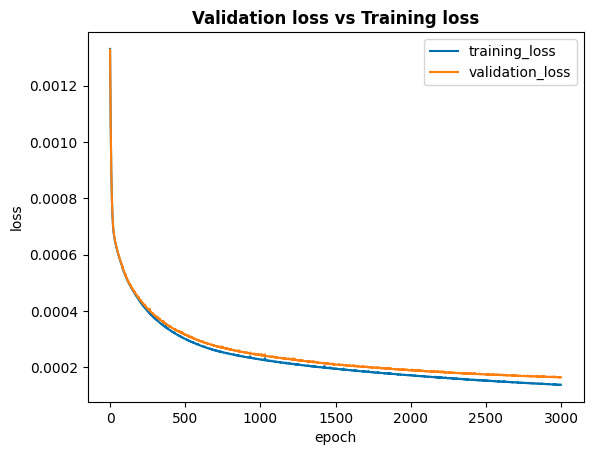

In [432]:
# SUR: PLOT AND SAVE LOSSES

###################################################################################################
########################################  PLOT AND SAVE LOSSES ####################################
###################################################################################################


# PLOT AND SAVE VALIDATION LOSS VS TRAINING LOSS

blue = (0.0, 0.4470588235294118, 0.6980392156862745)
orange = (1.0, 0.4980392156862745, 0.054901960784313725)

if BOOLEAN_plot_sur == True:
    plt.plot(history_sur['loss'],label='training_loss', color = blue)
    plt.plot(history_sur['val_loss'],label='validation_loss', color=orange)
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.title('Validation loss vs Training loss', fontweight='bold')
    if BOOLEAN_load_file_sur == False:
        plt.savefig(os.path.join(save_location_sur,'plot_trn-val_loss.png'), dpi=300)

In [433]:
# SUR: PRINTING SHAPES OF X_TRAIN_SUR,Y_TRAIN_SUR, INPUT_SHAPE_SUR

print(f"input_shape_sur: {input_shape_sur}")
print(f"x_train_sur: {x_train_sur.shape}")
print(f"y_train_sur.shape: {y_train_sur_chosen.shape}")

input_shape_sur: (28,)
x_train_sur: (9925, 28)
y_train_sur.shape: (9925, 1)


In [434]:
# SUR: PLOT NORMALIZAED SSS SCORES VS FREQUENCY 

title = ['Buckling_Load_Factor','Utilization', 'Interstorey_Drift_Ratios']

colour_list_3  = [colour_teal, colour_orange, colour_gold]

if BOOLEAN_model_type not in ['Height', 'Mass']:
    if BOOLEAN_plot_sur == True:
        # Plot values of each axis
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Create subplots for each axis

        for i in range(3):
            axs[i].hist(y_train_sur[:, i], bins=50, color= colour_list_3[i], alpha = 0.5)  # Plot histogram of values along the i-th axis
            axs[i].set_title(f"{title[i]}")  # Set title for the subplot
            axs[i].set_xlabel("Value")  # Set label for x-axis
            axs[i].set_ylabel("Frequency")  # Set label for y-axis

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.savefig(os.path.join(save_location_sur, f'plot_SSS_values.png'), dpi=300)

In [435]:
# SUR: PREDICT SAMPLES
if BOOLEAN_plot_sur == True:

    samples_to_test = x_test_sur
    sample_shape = (x_test_sur.shape[0], x_test_sur.shape[1]) 
    samples_to_test = samples_to_test.reshape(sample_shape) #flattens into a list

    # if BOOLEAN_model_type == 'Buckling_Load_Factor':
    #     calculated_scores = y_test_sur_buck
    # elif BOOLEAN_model_type == 'Utilization':
    #     calculated_scores = y_test_sur_util
    # elif BOOLEAN_model_type == 'Interstorey_Drift_Ratios':
    #     calculated_scores = y_test_sur_drift 
    # elif BOOLEAN_model_type == 'all':
    calculated_scores = y_test_sur_chosen


    predicted_scores = [] 
    predicted_scores.append(sur_model.predict(samples_to_test, batch_size=1)) 

    meshes_to_test = list(remaining_indices)
    meshes_to_test = [f"mesh_{i}" for i in meshes_to_test]
    predicted_scores = predicted_scores[0]

    # Saving the scores
    key_perf=['Buckling_Load_Factor','Utilization','Interstorey_Drift_Ratios']
    key_perf_gap=['Buckling Load Factor','Utilization','Interstorey Drift Ratios']
    
    if BOOLEAN_model_type not in ['all', 'Height', 'Mass']:
        max_val_perf = max_values_sur[key_perf.index(BOOLEAN_model_type)]
        truth_prediction_df_sur_df  =pd.DataFrame({'Test_mesh': meshes_to_test,'Calculated_score_normalized': calculated_scores.flatten(), 'Predicted_score_normalized': predicted_scores.flatten(), 'Calculated_score': calculated_scores.flatten()*max_val_perf, 'Predicted_score': predicted_scores.flatten()*max_val_perf})
    
    elif BOOLEAN_model_type =='all':
        max_val_perf = max_values_sur


        truth_prediction_df_sur_df_1 = pd.DataFrame(data= calculated_scores, columns = [f'Calculated normalized {i}'  for i in key_perf_gap])
        truth_prediction_df_sur_df_3= pd.DataFrame(data= calculated_scores*max_val_perf, columns = [f'Calculated {i}'  for i in key_perf_gap])
        truth_prediction_df_sur_df_1.insert(loc=0, column = 'Test_mesh', value = meshes_to_test )
        truth_prediction_df_sur_df_4= pd.DataFrame(data= predicted_scores*max_val_perf, columns = [f'Predicted {i}'  for i in key_perf_gap])
        truth_prediction_df_sur_df_2= pd.DataFrame(data= predicted_scores, columns = [f'Predicted normalized {i}'  for i in key_perf_gap])
        truth_prediction_df_sur_df = pd.concat([truth_prediction_df_sur_df_1,truth_prediction_df_sur_df_2,truth_prediction_df_sur_df_3,truth_prediction_df_sur_df_4], axis = 1 )
    
    elif BOOLEAN_model_type in ['Height', 'Mass']:
        max_val_perf = max_values_sur
        truth_prediction_df_sur_df  =pd.DataFrame({'Test_mesh': meshes_to_test,'Calculated_score_normalized': calculated_scores.flatten(), 'Predicted_score_normalized': predicted_scores.flatten(), 'Calculated_score': calculated_scores.flatten()*max_val_perf, 'Predicted_score': predicted_scores.flatten()*max_val_perf})
    
    truth_prediction_df_sur_df.to_csv(os.path.join(save_location_sur,'ground_truth_vs_prediction.csv'), index=False)



50/50 [==============================] - 0s 733us/step


In [436]:
# SUR: PREDICT BEST SAMPLES

if BOOLEAN_model_type not in ['Height','Mass']:
    if BOOLEAN_plot_sur == True:

        if BOOLEAN_model_type =='all':
            samples_to_test = x_test_best_sur
            sample_shape = (x_test_best_sur['Buckling_Load_Factor'].shape[0], x_test_best_sur['Buckling_Load_Factor'].shape[1]) 
            
            for key in samples_to_test.keys():
                samples_to_test[key] = samples_to_test[key].reshape(sample_shape)


            calculated_scores_best = y_test_best_sur_chosen

            predicted_scores_best = {}
            for key in sss:
                predicted_scores_best[key] = []
                predicted_scores_best_list = []
                predicted_scores_best_list.append(sur_model.predict(samples_to_test[key], batch_size=1)) 
                predicted_scores_best[key] = predicted_scores_best_list


            meshes_to_test_best = {}
            for i, key in enumerate (sss):
                meshes_to_test_best[key] = list(best_indices_arr_chosen[i,:])
                meshes_to_test_best[key] = [f"mesh_{i}" for i in meshes_to_test_best[key]]
                predicted_scores_best[key] = predicted_scores_best[key][0]

        else:
            samples_to_test = x_test_best_sur
            sample_shape = (x_test_best_sur.shape[0], x_test_best_sur.shape[1]) 
            samples_to_test = samples_to_test.reshape(sample_shape) #flattens into a list


            calculated_scores_best = y_test_best_sur_chosen

            predicted_scores_best = [] 
            predicted_scores_best.append(sur_model.predict(samples_to_test, batch_size=1)) 

            meshes_to_test_best = list(best_indices_arr_chosen)
            meshes_to_test_best = [f"mesh_{i}" for i in meshes_to_test_best]
            predicted_scores_best = predicted_scores_best[0]

        # Saving the scores
        key_perf=['Buckling_Load_Factor','Utilization','Interstorey_Drift_Ratios']
        key_perf_gap=['Buckling Load Factor','Utilization','Interstorey Drift Ratios']
        
        if BOOLEAN_model_type != 'all':
            max_val_perf = max_values_sur[key_perf.index(BOOLEAN_model_type)]
            truth_prediction_df_sur_df  =pd.DataFrame({'Test_mesh_best': meshes_to_test_best,'Calculated_score_normalized_best': calculated_scores_best.flatten(), 'Predicted_score_normalized_best': predicted_scores_best.flatten(), 'Calculated_score_best': calculated_scores_best.flatten()*max_val_perf, 'Predicted_score_best': predicted_scores_best.flatten()*max_val_perf})



        else:
            max_val_perf = max_values_sur


            list_1 = []
            for i, key in enumerate(sss):
                list_1.append(calculated_scores_best[key][:,i].reshape(-1,1))
            calculated_scores_best = np.concatenate((list_1[0],list_1[1], list_1[2]), axis=1)

            list_1 = []
            for i, key in enumerate(sss):
                list_1.append(predicted_scores_best[key][:,i].reshape(-1,1))
            predicted_scores_best = np.concatenate((list_1[0],list_1[1], list_1[2]), axis=1)


            truth_prediction_df_sur_df_1 = pd.DataFrame(data= calculated_scores_best, columns = [f'Calculated normalized best {i}'  for i in key_perf_gap])
            truth_prediction_df_sur_df_3= pd.DataFrame(data= calculated_scores_best*max_val_perf, columns = [f'Calculated best {i}'  for i in key_perf_gap])
            truth_prediction_df_sur_df_1.insert(loc=0, column = 'Test_mesh best', value = meshes_to_test_best )
            truth_prediction_df_sur_df_4= pd.DataFrame(data= predicted_scores_best*max_val_perf, columns = [f'Predicted best {i}'  for i in key_perf_gap])
            truth_prediction_df_sur_df_2= pd.DataFrame(data= predicted_scores_best, columns = [f'Predicted normalized best {i}'  for i in key_perf_gap])
            truth_prediction_df_sur_df = pd.concat([truth_prediction_df_sur_df_1,truth_prediction_df_sur_df_2,truth_prediction_df_sur_df_3,truth_prediction_df_sur_df_4], axis = 1 )
        
        truth_prediction_df_sur_df.to_csv(os.path.join(save_location_sur,'ground_truth_vs_prediction_best.csv'), index=False)



In [437]:
# SUR: PLOT CALCULATED VS PREDICTED SCORES ALL

if BOOLEAN_plot_sur == True:
    if BOOLEAN_model_type == 'all':
        # Create subplots
        fig, axs = plt.subplots(3, 1, figsize=(8, 10))

        # Plot each axis in a separate subplot
        for i in range(3):
            axs[i].plot(calculated_scores[:, i], color='green', linestyle='dotted', label='Calculated Scores')
            axs[i].plot(predicted_scores[:, i], color='red', linestyle='solid', label='Predicted Scores')
            axs[i].set_xlabel('Sample')
            axs[i].set_ylabel(f"{title[i]}")
            axs[i].set_title(f"{title[i]}")
            if y_test_sur_chosen.shape[0] == 10:
                axs[i].set_xticks(range(len(meshes_to_test)),meshes_to_test, rotation=45)
                axs[i].grid(True)
            else:
                axs[i].set_xticks(range(len(meshes_to_test)),meshes_to_test, rotation=90, size=5)     
            axs[i].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [438]:
# SUR: PLOT CALCULATED VS PREDICTED SCORES ALL NOT NORMALIZED

if BOOLEAN_plot_sur == True:
    if BOOLEAN_model_type == 'all':
        # Create subplots
        fig, axs = plt.subplots(3, 1, figsize=(8, 10))

        # Plot each axis in a separate subplot
        for i in range(3):
            axs[i].plot(calculated_scores[:, i]* max_val_perf[i], color='green', linestyle='dotted', label='Calculated Scores')
            axs[i].plot(predicted_scores[:, i]* max_val_perf[i], color='red', linestyle='solid', label='Predicted Scores')
            axs[i].set_xlabel('Sample')
            axs[i].set_ylabel(f"{title[i]}")
            axs[i].set_title(f"{title[i]}")
            if y_test_sur_chosen.shape[0] == 10:
                axs[i].set_xticks(range(len(meshes_to_test)),meshes_to_test, rotation=45)
                axs[i].grid(True)
            else:
                axs[i].set_xticks(range(len(meshes_to_test)),meshes_to_test, rotation=90, size=5)     
            axs[i].legend()

        plt.tight_layout()
        plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth_NOT_normalized.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [439]:
# SUR: PLOT BEST CALCULATED VS PREDICTED SCORES ALL

if BOOLEAN_model_type not in  ['all','Height', 'Mass']:
    if BOOLEAN_plot_sur == True:
        if BOOLEAN_model_type == 'all':
            # Create subplots
            fig, axs = plt.subplots(3, 1, figsize=(12, 10))

            # Plot each axis in a separate subplot
            for i in range(3):
                axs[i].plot(calculated_scores_best[:, i], color=colour_teal, linestyle='dotted', label='Calculated Scores best')
                axs[i].plot(predicted_scores_best[:, i], color=colour_orange, linestyle='solid', label='Predicted Scores best')
                # axs[i].axhline(np.max(y_train_sur_chosen[:, i]) if sss[i]=='Buckling_Load_Factor' else np.min(y_train_sur_chosen[:, i]), color = colour_maroon, linestyle='--', label='Best Score of Training Data')
                # axs[i].axhline(np.mean(y_train_sur_chosen[:, i]), color = 'gray', linestyle='solid', label='Mean of Training Data')
                # axs[i].axhline(np.mean(y_train_sur_chosen[:, i]) + np.std(y_train_sur_chosen[:, i]), color = 'gray', linestyle='--', label='Standard Deviation of Training Data')
                # axs[i].axhline(np.mean(y_train_sur_chosen[:, i]) - np.std(y_train_sur_chosen[:, i]), color = 'gray', linestyle='--')                
                axs[i].set_xlabel('Sample')
                axs[i].set_ylabel(f"{title[i]}")
                axs[i].set_title(f"{title[i]}")
                axs[i].set_xticks(range(len(meshes_to_test_best[sss[i]])))
                axs[i].set_xticklabels(meshes_to_test_best[sss[i]], rotation=45)
                axs[i].legend(bbox_to_anchor=(1.1, 1.05))
                axs[i].grid(True)

            plt.tight_layout()
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth_best.png'), dpi=300, bbox_inches='tight')
            plt.show()

In [440]:
# SUR: PLOT BEST CALCULATED VS PREDICTED SCORES ALL NOT NORMALIZED

if BOOLEAN_model_type not in  ['all','Height', 'Mass']:
    if BOOLEAN_plot_sur == True:
        if BOOLEAN_model_type == 'all':
            # Create subplots
            fig, axs = plt.subplots(3, 1, figsize=(12, 10))

            # Plot each axis in a separate subplot
            for i in range(3):
                axs[i].plot(calculated_scores_best[:, i]* max_val_perf[i], color=colour_teal, linestyle='dotted', label='Calculated Best Scores')
                axs[i].plot(predicted_scores_best[:, i]* max_val_perf[i], color=colour_orange, linestyle='solid', label='Predicted Best Scores')
                # axs[i].axhline(np.max(y_train_sur_chosen[:, i])* max_val_perf[i] if sss[i]=='Buckling_Load_Factor' else np.min(y_train_sur_chosen[:, i])* max_val_perf[i], color = colour_maroon, linestyle='--', label='Best Score of Training Data')
                # axs[i].axhline(np.mean(y_train_sur_chosen[:, i])* max_val_perf[i], color = 'gray', linestyle='solid', label='Mean of Training Data')
                # axs[i].axhline(np.mean(y_train_sur_chosen[:, i])* max_val_perf[i] + np.std(y_train_sur_chosen[:, i])* max_val_perf[i], color = 'gray', linestyle='--', label='Standard Deviation of Training Data')
                # axs[i].axhline(np.mean(y_train_sur_chosen[:, i])* max_val_perf[i] - np.std(y_train_sur_chosen[:, i])* max_val_perf[i], color = 'gray', linestyle='--')                
                axs[i].set_xlabel('Sample')
                axs[i].set_ylabel(f"{title[i]}")
                axs[i].set_title(f"{title[i]}")
                axs[i].set_xticks(range(len(meshes_to_test_best[sss[i]])))
                axs[i].set_xticklabels(meshes_to_test_best[sss[i]], rotation=45)
                axs[i].legend(bbox_to_anchor = (1.1,1.05))
                axs[i].grid(True)

            plt.tight_layout()
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth_best_NOT_normalized.png'), dpi=300, bbox_inches='tight')
            plt.show()

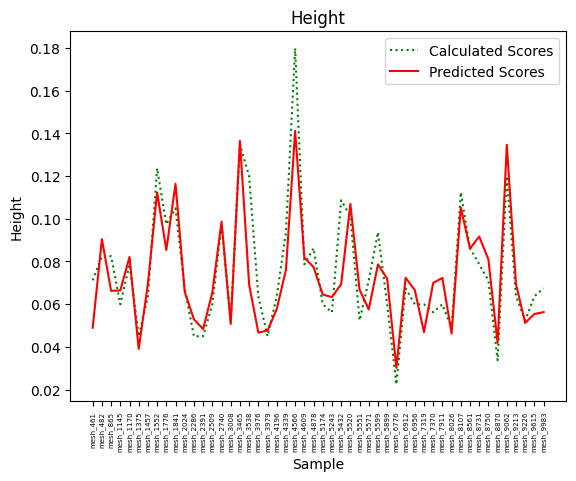

In [441]:
# SUR: PLOT CALCULATED VS PREDICTED SCORES FOR METRIC NORMALIZED

if BOOLEAN_plot_sur == True:
    if BOOLEAN_model_type != 'all':
        plt.plot(calculated_scores, color='green', linestyle='dotted', label='Calculated Scores')
        plt.plot(predicted_scores, color='red', linestyle='solid', label='Predicted Scores')
        plt.xlabel('Sample')
        plt.ylabel(f"{BOOLEAN_model_type}")
        plt.title(f"{BOOLEAN_model_type}")
        if y_test_sur_chosen.shape[0] == 10:
            plt.xticks(range(len(meshes_to_test)),meshes_to_test, rotation=45)
            plt.grid(True)
        else:
            plt.xticks(range(len(meshes_to_test)),meshes_to_test, rotation=90, size=5)            
        plt.legend()
        if y_test_sur_chosen.shape[0] == 10:
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth.png'), dpi=300, bbox_inches='tight')
        else:
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth.png'), dpi=300, bbox_inches='tight')
        plt.show()

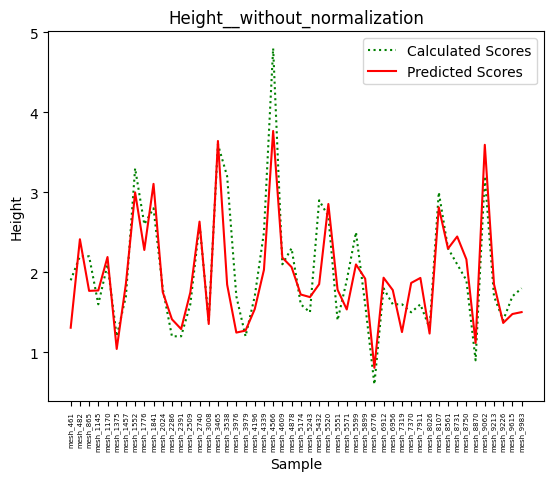

In [442]:
# SUR: PLOT CALCULATED VS PREDICTED SCORES FOR METRIC NOT NORMALIZED

if BOOLEAN_plot_sur == True:
    if BOOLEAN_model_type != 'all':
        plt.plot(calculated_scores*max_val_perf, color='green', linestyle='dotted', label='Calculated Scores')
        plt.plot(predicted_scores*max_val_perf, color='red', linestyle='solid', label='Predicted Scores')
        plt.xlabel('Sample')
        plt.ylabel(f"{BOOLEAN_model_type}")
        plt.title(f"{BOOLEAN_model_type}__without_normalization")
        if y_test_sur_chosen.shape[0] == 10:
            plt.xticks(range(len(meshes_to_test)),meshes_to_test, rotation=45)
            plt.grid(True)
        else:
            plt.xticks(range(len(meshes_to_test)),meshes_to_test, rotation=90, size=5)            
        plt.legend()
        if y_test_sur_chosen.shape[0] == 10:
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth__NOT_normalized.png'), dpi=300, bbox_inches='tight')
        else:
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth__NOT_normalized_50.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [443]:

print('---------------NORMALIZED--------------------------')
print(f'---------thickness----------------')
print(f'mean: {np.mean(thickness_dataset)/np.max(thickness_dataset)}')
print(f'std: {np.std(thickness_dataset)/np.max(thickness_dataset)}')
print(f'max: {np.max(thickness_dataset)/np.max(thickness_dataset)}')
print(f'min: {np.min(thickness_dataset)/np.max(thickness_dataset)}')
print('-------------------------------------------------------')
print(f'---------force densities----------------')
print(f'mean: {np.mean(dataset)/np.max(dataset)}')
print(f'std: {np.std(dataset)/np.max(dataset)}')
print(f'max: {np.max(dataset)/np.max(dataset)}')
print(f'min: {np.min(dataset)/np.max(dataset)}')
print('-------------------------------------------------------')



print('---------------NOT NORMALIZED--------------------------')
print(f'---------thickness----------------')
print(f'mean: {np.mean(thickness_dataset)}')
print(f'std: {np.std(thickness_dataset)}')
print(f'max: {np.max(thickness_dataset)}')
print(f'min: {np.min(thickness_dataset)}')
print('-------------------------------------------------------')

print(f'---------force densities----------------')
print(f'mean: {np.mean(dataset)}')
print(f'std: {np.std(dataset)}')
print(f'max: {np.max(dataset)}')
print(f'min: {np.min(dataset)}')


# print(np.mean(thickness_dataset) - np.std(thickness_dataset))

---------------NORMALIZED--------------------------
---------thickness----------------
mean: 0.6683157894736843
std: 0.2582639462410072
max: 1.0
min: 0.368421052631579
-------------------------------------------------------
---------force densities----------------
mean: 0.0032234205422210817
std: 0.00973586081081827
max: 1.0
min: 9.626492106276474e-05
-------------------------------------------------------
---------------NOT NORMALIZED--------------------------
---------thickness----------------
mean: 0.06349
std: 0.02453507489289568
max: 0.095
min: 0.035
-------------------------------------------------------
---------force densities----------------
mean: 3.3484892592592597
std: 10.113612210278019
max: 1038.8
min: 0.1


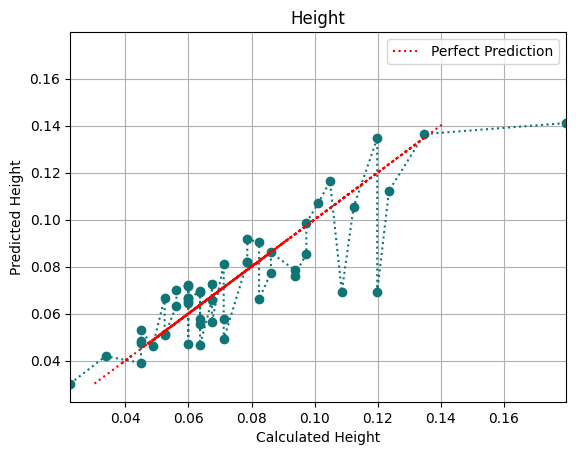

In [444]:
# SUR: PLOT CALCULATED VS PREDICTED SCORES FOR METRIC NORMALIZED

calc_scores = np.sort(calculated_scores.flatten())
sorted_indices_calculated_scores = np.argsort(calculated_scores.flatten())
pred_scores = predicted_scores.reshape(-1)[sorted_indices_calculated_scores]

if BOOLEAN_plot_sur == True:
    if BOOLEAN_model_type != 'all':
        plt.plot(calc_scores, pred_scores, color=colour_teal, linestyle='dotted', marker= 'o')
        plt.plot(pred_scores,pred_scores, color='red', linestyle='dotted', label='Perfect Prediction')
        plt.xlabel(f'Calculated {BOOLEAN_model_type}')
        plt.ylabel(f"Predicted {BOOLEAN_model_type}")
        plt.title(f"{BOOLEAN_model_type}")
        plt.legend()
        plt.grid(True)

        # Set symmetrical x and y ticks
        max_value = max(max(calc_scores), max(pred_scores))
        min_value = min(min(calc_scores), min(pred_scores))
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)
        
        if y_test_sur_chosen.shape[0] == 10:        
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth_relationship.png'), dpi=300, bbox_inches='tight')
        else:
            plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth_relationship_50.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [445]:
(np.sum(calc_scores)-np.sum(pred_scores))/calc_scores.shape[0]

0.0023974455251229453

In [446]:
# SUR: PLOT BEST CALCULATED VS PREDICTED SCORES FOR METRIC NORMALIZED

if BOOLEAN_plot_sur == True:
    if BOOLEAN_model_type not in  ['all','Height', 'Mass']:
        plt.plot(calculated_scores_best, color= colour_teal, linestyle='dotted', label='Calculated Best Scores')
        plt.plot(predicted_scores_best, color= colour_orange, linestyle='solid', label='Predicted Best Scores')
        plt.axhline(np.max(y_train_sur_chosen) if BOOLEAN_model_type=='Buckling_Load_Factor' else np.min(y_train_sur_chosen), color = colour_maroon, linestyle='--', label='Best Score of Training Data')
        plt.axhline(np.mean(y_train_sur_chosen), color = 'gray', linestyle='solid', label='Mean of Training Data')
        # plt.axhline(np.mean(y_train_sur_chosen) + np.std(y_train_sur_chosen), color = 'gray', linestyle='--', label='Standard Deviation of Training Data')
        plt.axhline(np.mean(y_train_sur_chosen) - np.std(y_train_sur_chosen), color = 'gray', linestyle='--')        
        plt.xlabel('Sample')
        plt.ylabel(f"{BOOLEAN_model_type}")
        plt.title(f"{BOOLEAN_model_type}")
        plt.xticks(range(len(meshes_to_test_best)),meshes_to_test_best, rotation=45)
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth_best.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [447]:
# SUR: PLOT BEST CALCULATED VS PREDICTED SCORES FOR METRIC NOT NORMALIZED

if BOOLEAN_plot_sur == True:
    if BOOLEAN_model_type not in  ['all','Height', 'Mass']:
        plt.plot(calculated_scores_best*max_val_perf, color=colour_teal, linestyle='dotted', label='Calculated Best Scores')
        plt.plot(predicted_scores_best*max_val_perf, color=colour_orange, linestyle='solid', label='Predicted Best Scores')
        plt.axhline(np.max(y_train_sur_chosen)*max_val_perf if BOOLEAN_model_type=='Buckling_Load_Factor' else np.min(y_train_sur_chosen)*max_val_perf, color = colour_maroon, linestyle='--', label='Best Score of Training Data')
        plt.axhline(np.mean(y_train_sur_chosen)*max_val_perf, color = 'gray', linestyle='solid', label='Mean of Training Data')
        plt.axhline(np.mean(y_train_sur_chosen)*max_val_perf + np.std(y_train_sur_chosen)*max_val_perf, color = 'gray', linestyle='--', label='Standard Deviation of Training Data')
        plt.axhline(np.mean(y_train_sur_chosen)*max_val_perf - np.std(y_train_sur_chosen)*max_val_perf, color = 'gray', linestyle='--')      
        plt.xlabel('Sample')
        plt.ylabel(f"{BOOLEAN_model_type}")
        plt.title(f"{BOOLEAN_model_type}__without_normalization")
        plt.xticks(range(len(meshes_to_test_best)),meshes_to_test_best, rotation=45)
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(save_location_sur, f'plot_prediction_ground_truth_best__NOT_normalized.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [448]:
# VAE: HEIGHT DISTRIBUTION
from collections import Counter

labels_cvae_dict.keys()

item_counts = Counter(height_dataset.reshape([-1]))

labels_cvae_df = {}
for i in labels_cvae_dict.keys():
    labels_cvae_df[str(f'{i}')] = item_counts[i]*100/height_dataset.shape[0]

print(labels_cvae_df)
print(sum(labels_cvae_df.values()))
pd.DataFrame

{'0.5': 0.12, '0.6': 0.32, '0.7': 0.74, '0.8': 1.38, '0.9': 2.32, '1.0': 3.22, '1.1': 4.28, '1.2': 5.49, '1.3': 5.52, '1.4': 6.37, '1.5': 6.54, '1.6': 6.58, '1.7': 6.1, '1.8': 5.9, '1.9': 5.7, '2.0': 4.7, '2.1': 4.33, '2.2': 4.64, '2.3': 3.71, '2.4': 2.9, '2.5': 2.91, '2.6': 2.45, '2.7': 2.11, '2.8': 1.73, '2.9': 1.49, '3.0': 1.19, '3.1': 1.2, '3.2': 0.91, '3.3': 0.96, '3.4': 0.66, '3.5': 0.58, '3.6': 0.45, '3.7': 0.38, '3.8': 0.37, '3.9': 0.24, '4.0': 0.3, '4.1': 0.12, '4.2': 0.24, '4.3': 0.17, '4.4': 0.13, '4.5': 0.09, '4.6': 0.06, '4.7': 0.08, '4.8': 0.06, '4.9': 0.04, '5.0': 0.02, '5.1': 0.02, '5.3': 0.03, '5.4': 0.04, '5.5': 0.02, '5.6': 0.02, '5.8': 0.01, '6.0': 0.01, '6.7': 0.01, '7.6': 0.01, '8.9': 0.01, '13.3': 0.01, '26.7': 0.01}
100.00000000000001


pandas.core.frame.DataFrame

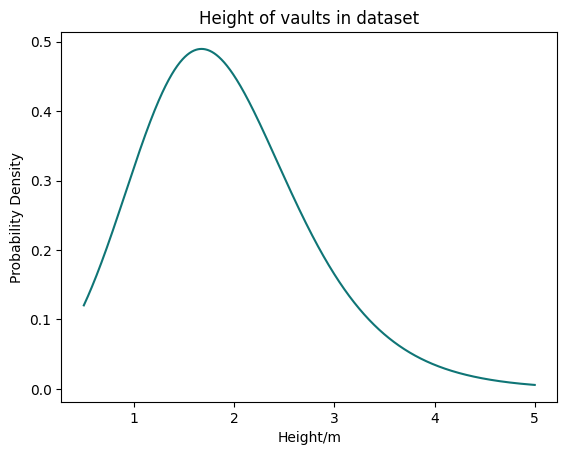

In [449]:
# VAE: PLOTTING HEIGHTS OF VAULTS IN THE DATASET

from sklearn.neighbors import KernelDensity

# Create a KDE model
kde = KernelDensity(bandwidth=0.5).fit(height_dataset)

# Evaluate the PDF at various points


x_vals = np.linspace(min(height_dataset), 5, 1000)
log_dens = kde.score_samples(x_vals.reshape(-1, 1))

# Plot the estimated PDF
plt.plot(x_vals, np.exp(log_dens), label="Estimated PDF", color= colour_teal)
# plt.hist(height_dataset, bins=10, density=True, alpha=0.5, label="Histogram")
plt.xlabel("Height/m")
plt.ylabel("Probability Density")
plt.title("Height of vaults in dataset")
plt.show()


In [450]:
haa = height_dataset.reshape(-1,)
haa

array([1.6, 1.5, 1.6, ..., 1.7, 1.2, 1. ])

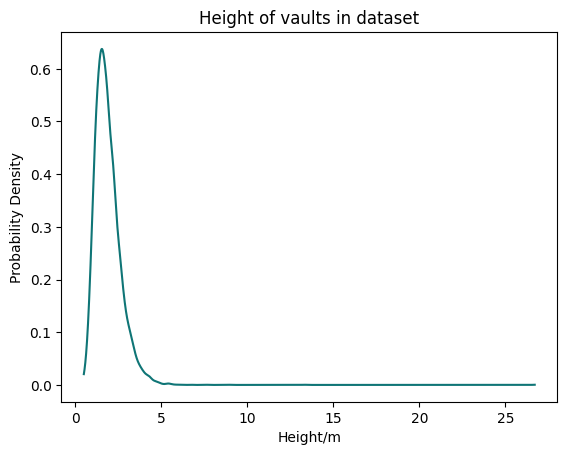

In [451]:
from scipy.stats import gaussian_kde


# haa = np.array([1,1,2,2,3,3,4,4,5,5])

# Example array of heights
unique_heights, counts = np.unique(haa, return_counts=True)
# Create a density estimate
density = gaussian_kde(haa)

# Generate a range of values over which to plot the density
x = np.linspace(min(haa), max(haa), 10000)
y = density(x)

# Plot the density curve
# plt.plot(unique_heights, counts, label='Density', color = colour_teal)
# plt.figure(figsize=(10,4))
plt.plot(x, y, label='Density', color = colour_teal)
# plt.xlim(0,5)
plt.xlabel("Height/m")
plt.ylabel("Probability Density")
plt.title("Height of vaults in dataset")
plt.show()

In [452]:
# SELECT THE LABEL TO BE SAMPLED
labels_cvae_value = 3.8

1/1 [==============================] - 0s 16ms/step


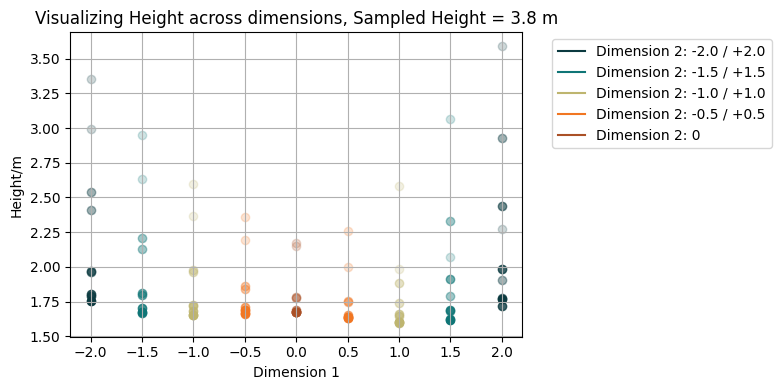

In [453]:
# VAE/SUR: VISUALIZING HEIGHT ACROSS DIMENSIONS: CENTRE

#######################################################################################################


if BOOLEAN_plot_vae == True:

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)

    alpha_list = [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2]
    n = 9
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)
    # Set the desired figure size (adjust as needed)
    fig, ax = plt.subplots(figsize=(8, 4))  # Width: 10 inches, Height: 6 inches
    # # ACROSS DIMENSION 2

     # decoder for each square in the grid
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample,c_height])
            x_decoded_reshaped = x_decoded.reshape(1,28)      
            # Predicting on the samples
            # sample_shape = (sampled_meshes.shape[0], sampled_meshes.shape[1]) 
            # x_decoded_reshaped = x_decoded_reshaped.reshape(sample_shape) #flattens into a list
            height = sur_model_dict['Height'].predict(x_decoded_reshaped, batch_size=1)*max_values_sur_height



            plt.scatter(xi, height, color = colour_list_10[i], alpha= alpha_list[j])
    plt.xlabel(f'Dimension 1')
    plt.ylabel('Height/m')
    plt.title(f'Visualizing Height across dimensions, Sampled Height = {labels_cvae_value} m')
    plt.grid(True)
    plt.xticks(list(grid_x))
    custom_legend = [
        plt.Line2D([0], [0], color= colour_dark_blue, linestyle='solid', label='Dimension 2: -2.0 / +2.0'),
        plt.Line2D([0], [0], color= colour_teal, linestyle='solid', label='Dimension 2: -1.5 / +1.5'),
        plt.Line2D([0], [0], color= colour_gold, linestyle='solid', label='Dimension 2: -1.0 / +1.0'),
        plt.Line2D([0], [0], color= colour_orange, linestyle='solid', label='Dimension 2: -0.5 / +0.5'),
        plt.Line2D([0], [0], color= colour_maroon, linestyle='solid', label='Dimension 2: 0')
    ]
    plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add overall title and adjust layout
    plt.tight_layout()

    # Save or display the plot
    plt.savefig(os.path.join(save_location_vae,f'plot_height_across_dimension_height={labels_cvae_value}.png'), dpi=300, bbox_inches='tight')
    plt.show()


1/1 [==============================] - 0s 18ms/step


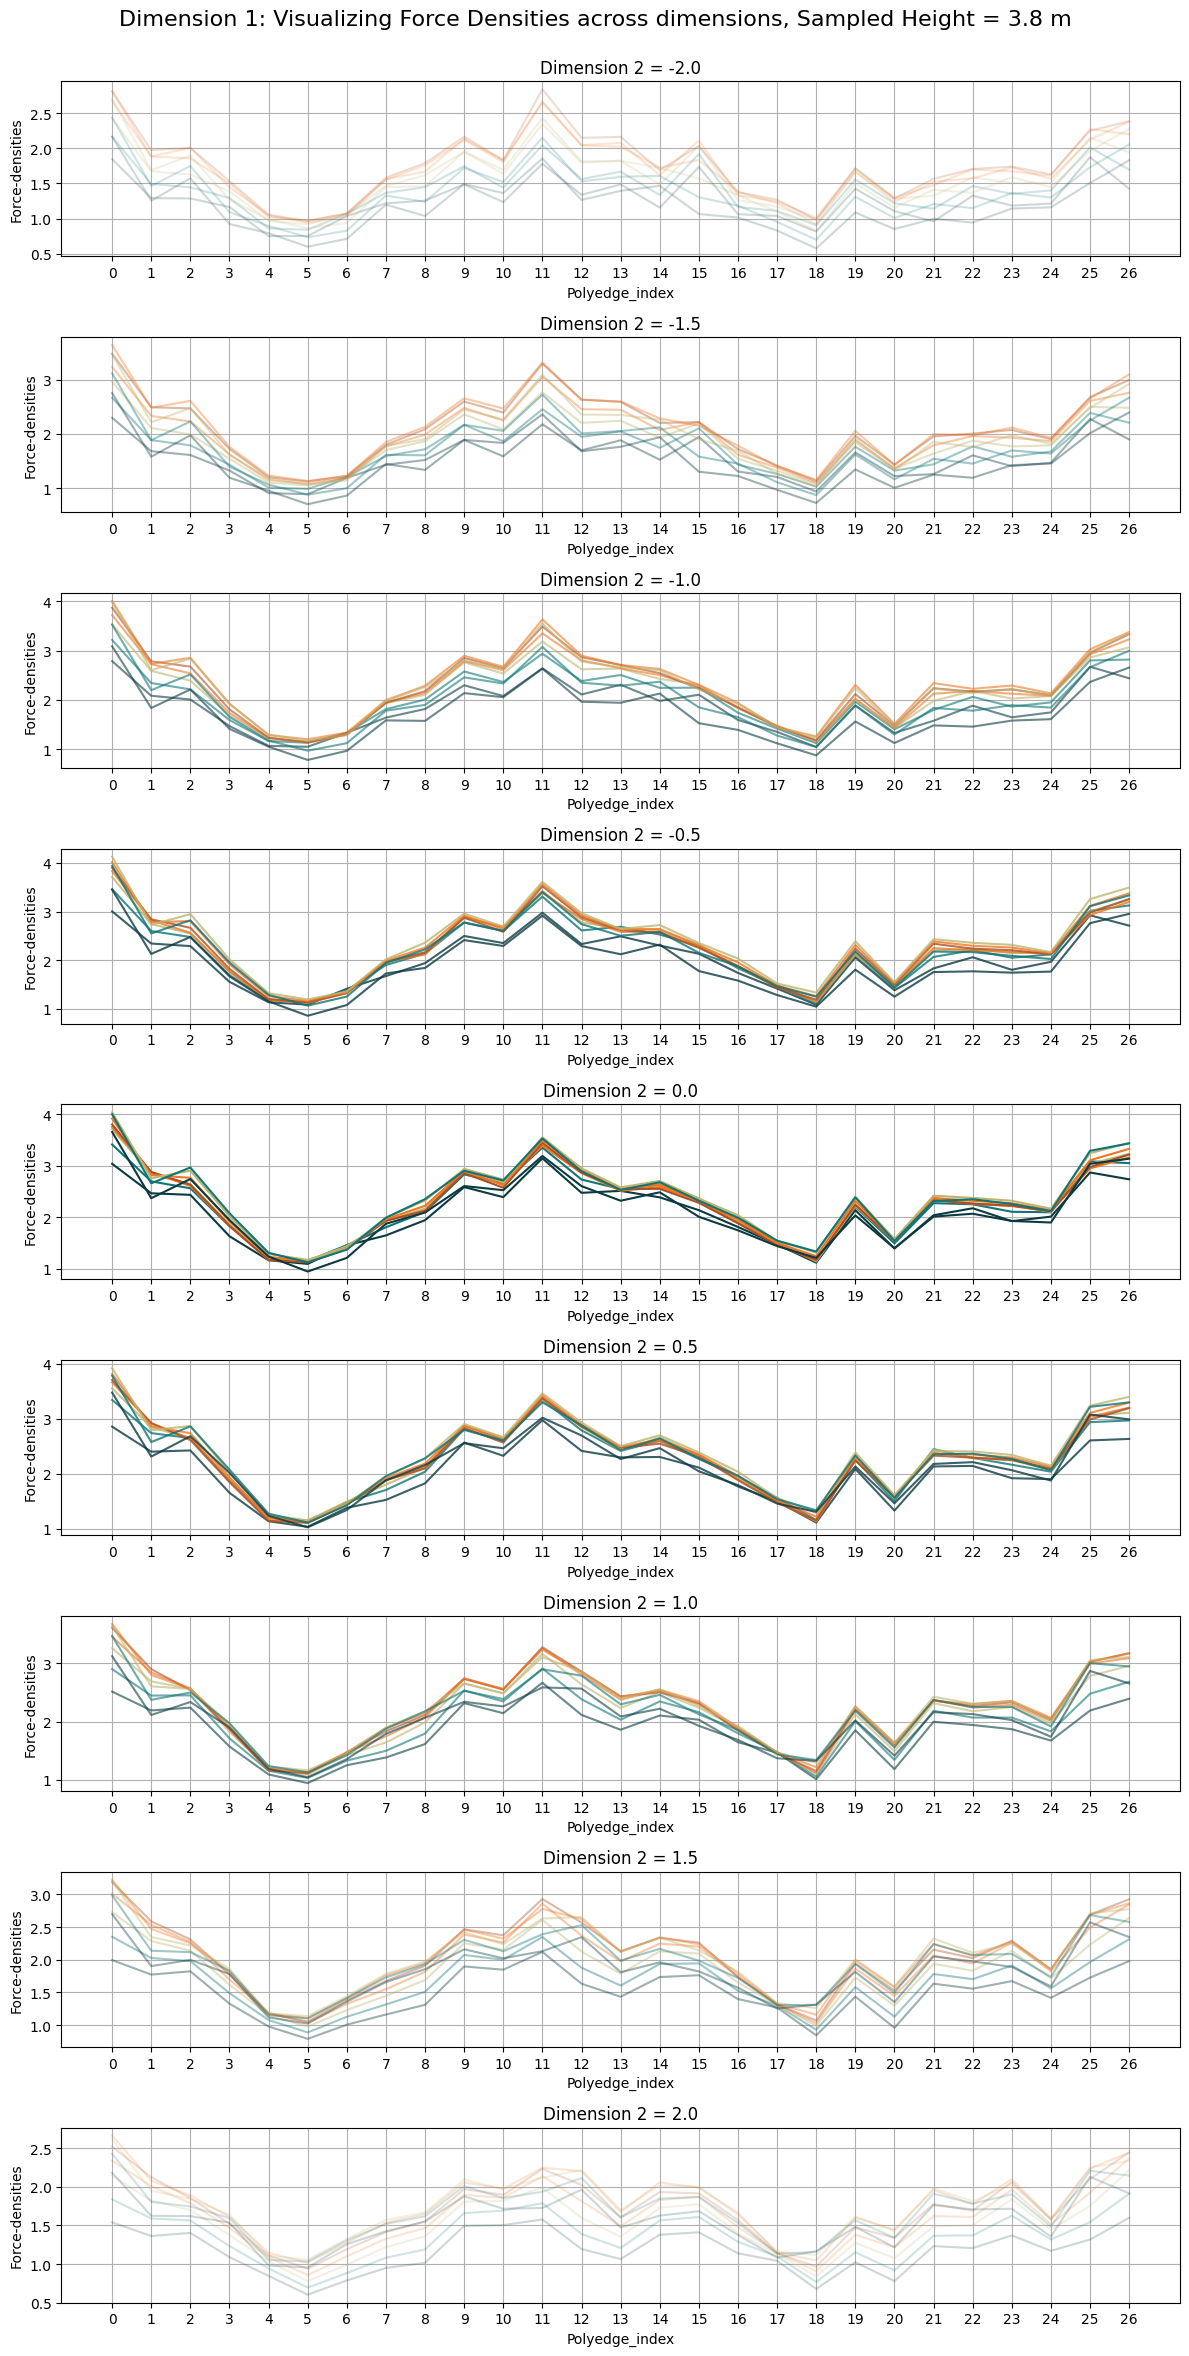

1/1 [==============================] - 0s 18ms/step


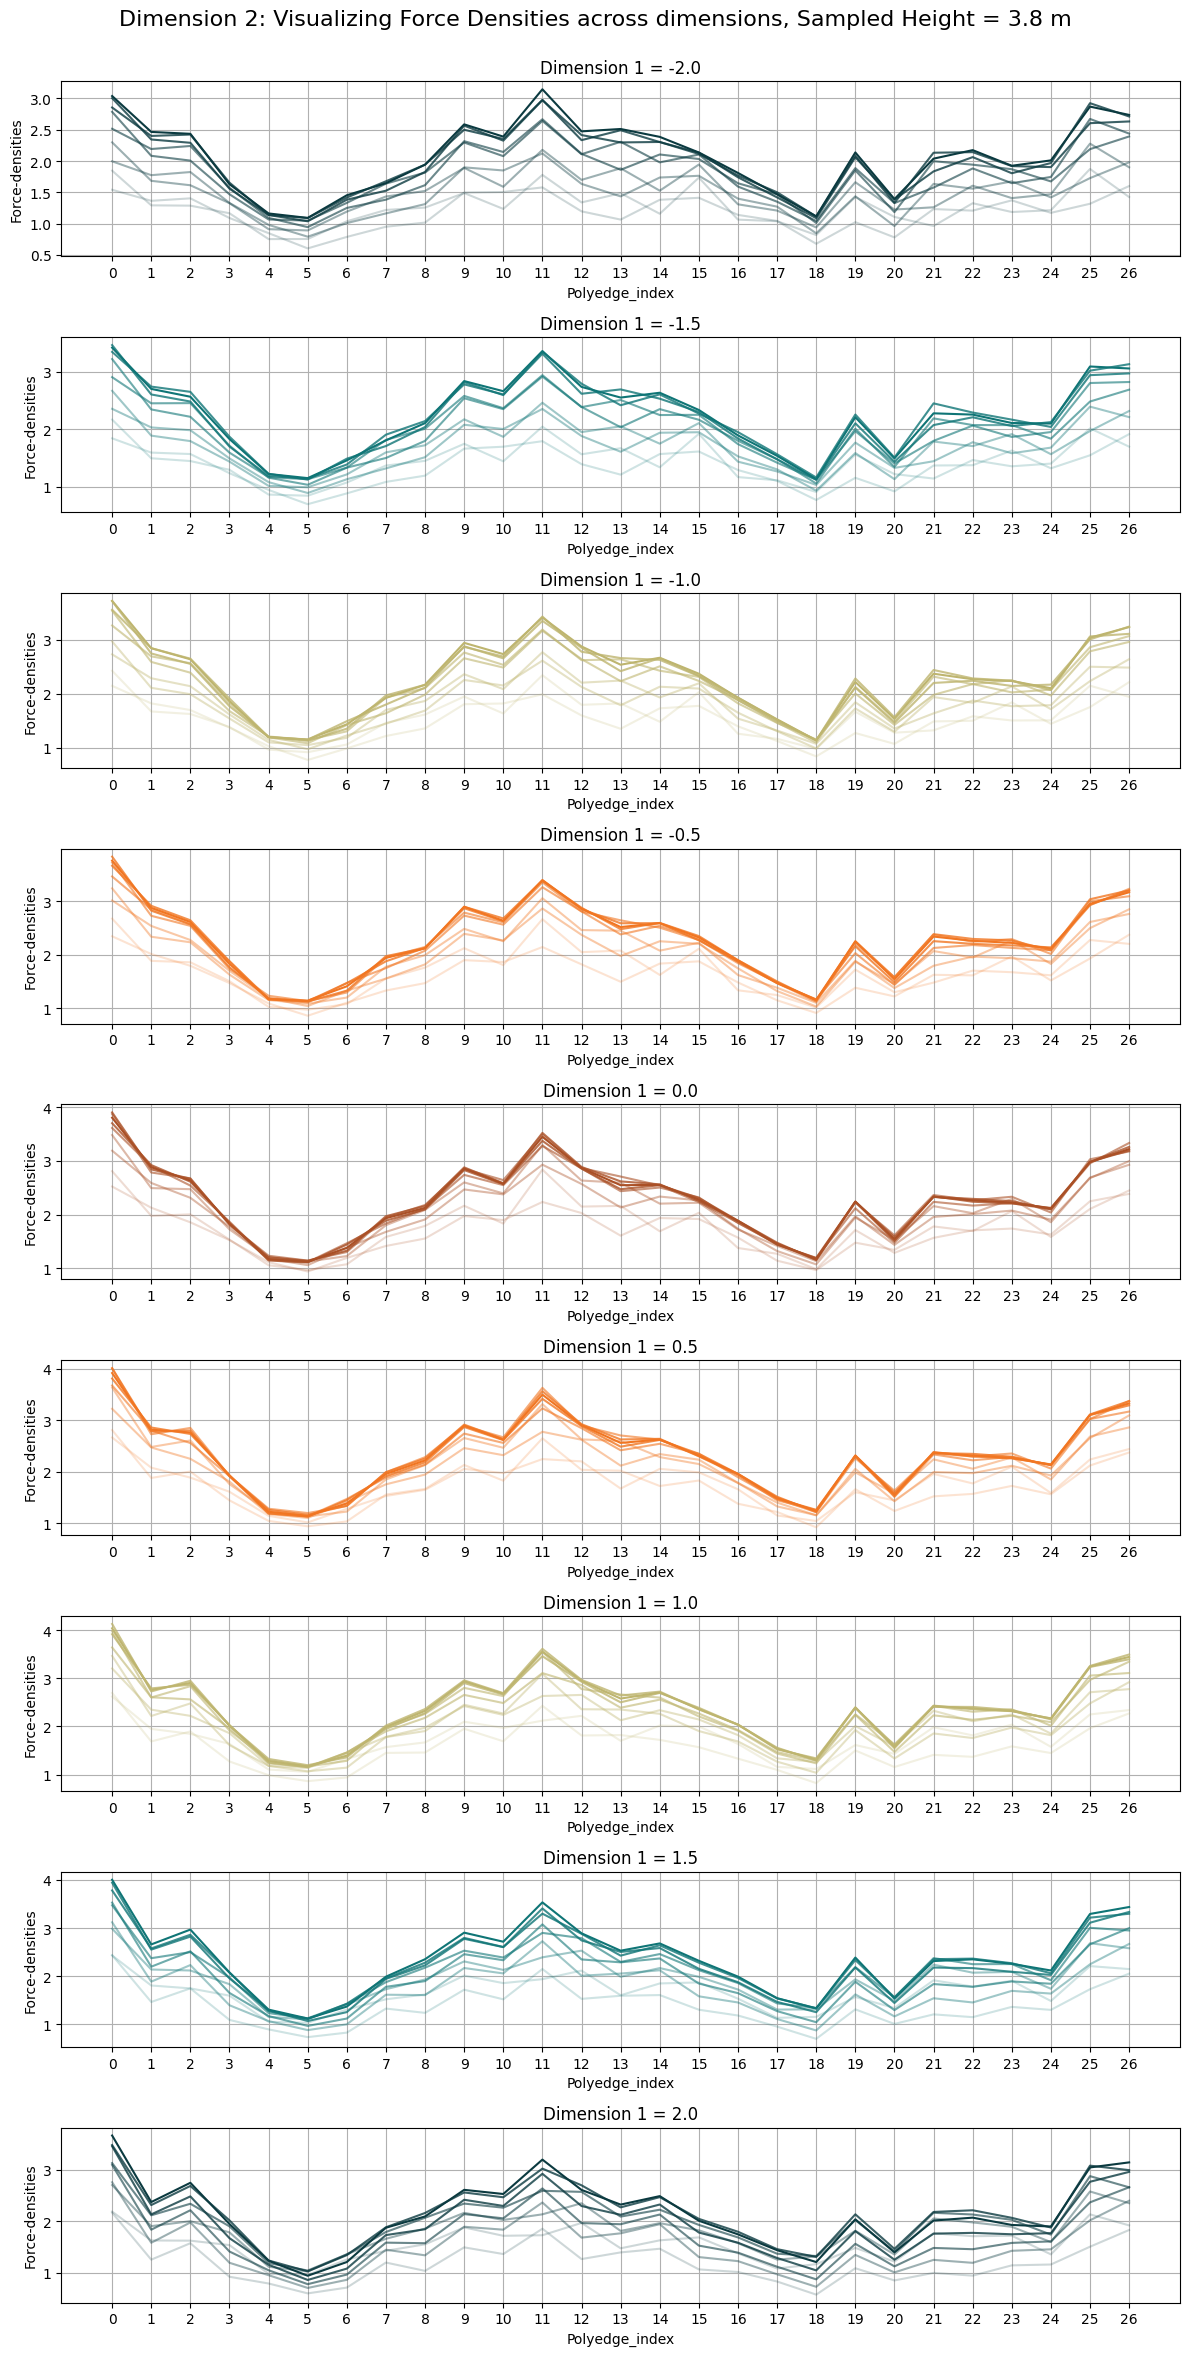

In [454]:
# VAE: SCROLLING ACROSS LATENT SPACE CENTRE 


if BOOLEAN_plot_vae == True:

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)


    img_width = 28
    alpha_list = [0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2]
    n = 9  # generate 15x15 digits
    # figure = np.zeros((img_width * n, 1 * n, num_channels))
    #Create a Grid of latent variables, to be provided as inputs to decoder.predict
    #Creating vectors within range -5 to 5 as that seems to be the range in latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    #######################################################################################################

    # ACROSS DIMENSION 1

    # Create a 5x5 grid of subplots
    fig, axs = plt.subplots(n, 1, figsize=(12, 24))


    # decoder for each square in the grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample,c_height])
            mesh_sample = x_decoded[0].reshape(28)[:-1]*np.max(dataset)
            thickness = x_decoded[0].reshape(28)[-1]

            axs[i].plot(range(len(mesh_sample)), mesh_sample, label=f'Dimension {i+1}-{1}', color = colour_list_10[j], alpha=alpha_list[i])
            axs[i].set_xlabel('Polyedge_index')
            axs[i].set_ylabel('Force-densities')
            axs[i].set_title(f'Dimension 2 = {yi}')
            axs[i].grid(True)
            axs[i].set_xticks(list(range(len(mesh_sample))))


    # Add overall title and adjust layout
    fig.suptitle(f'Dimension 1: Visualizing Force Densities across dimensions, Sampled Height = {labels_cvae_value} m', fontsize=16,y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust the rect parameter to leave space for the suptitle

    # Save or display the plot
    plt.savefig(os.path.join(save_location_vae,f'plot_fd_across_dimension_1_height={labels_cvae_value}.png'), dpi=300)
    plt.show()

    #######################################################################################################


    # ACROSS DIMENSION 2

    # Create a 5x5 grid of subplots
    fig, axs = plt.subplots(n, 1, figsize=(12, 24))

    # decoder for each square in the grid
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, c_height])
            mesh_sample = x_decoded[0].reshape(28)[:-1]*np.max(dataset)
            thickness = x_decoded[0].reshape(28)[-1]


            axs[i].plot(range(len(mesh_sample)), mesh_sample, label=f'Dimension {i+1}-{1}', color = colour_list_10[i], alpha=alpha_list[j])
            axs[i].set_xlabel('Polyedge_index')
            axs[i].set_ylabel('Force-densities')
            axs[i].set_title(f'Dimension 1 = {xi}')
            axs[i].grid(True)
            axs[i].set_xticks(list(range(len(mesh_sample))))


    # Add overall title and adjust layout
    fig.suptitle(f'Dimension 2: Visualizing Force Densities across dimensions, Sampled Height = {labels_cvae_value} m', fontsize=16,y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust the rect parameter to leave space for the suptitle

    # Save or display the plot
    plt.savefig(os.path.join(save_location_vae,f'plot_fd_across_dimension_2_height={labels_cvae_value}.png'), dpi=300)
    plt.show()

1/1 [==============================] - 0s 24ms/step


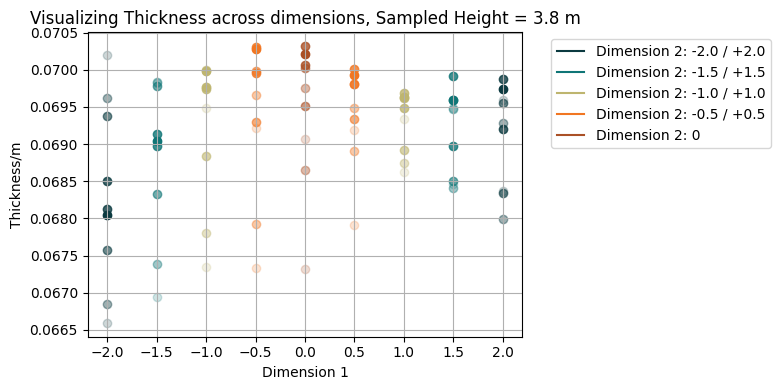

In [455]:
# VAE: VISUALIZING THICKNESS ACROSS DIMENSIONS: CENTRE

#######################################################################################################


if BOOLEAN_plot_vae == True:

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)

    n = 9
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)
    # Set the desired figure size (adjust as needed)
    fig, ax = plt.subplots(figsize=(8, 4))  # Width: 10 inches, Height: 6 inches
    # # ACROSS DIMENSION 2

     # decoder for each square in the grid
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample,c_height])
            thickness = x_decoded[0].reshape(28)[-1]*np.max(thickness_dataset) if BOOLEAN_thickness_normalization == 'separate' else x_decoded[0].reshape(28)[-1]*np.max(dataset)

            plt.scatter(xi, thickness, color = colour_list_10[i], alpha= alpha_list[j])
    plt.xlabel(f'Dimension 1')
    plt.ylabel('Thickness/m')
    plt.title(f'Visualizing Thickness across dimensions, Sampled Height = {labels_cvae_value} m')
    plt.grid(True)
    plt.xticks(list(grid_x))
    custom_legend = [
        plt.Line2D([0], [0], color= colour_dark_blue, linestyle='solid', label='Dimension 2: -2.0 / +2.0'),
        plt.Line2D([0], [0], color= colour_teal, linestyle='solid', label='Dimension 2: -1.5 / +1.5'),
        plt.Line2D([0], [0], color= colour_gold, linestyle='solid', label='Dimension 2: -1.0 / +1.0'),
        plt.Line2D([0], [0], color= colour_orange, linestyle='solid', label='Dimension 2: -0.5 / +0.5'),
        plt.Line2D([0], [0], color= colour_maroon, linestyle='solid', label='Dimension 2: 0')
    ]
    plt.legend(handles=custom_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add overall title and adjust layout
    plt.tight_layout()

    # Save or display the plot
    plt.savefig(os.path.join(save_location_vae,f'plot_thickness_across_dimension_height={labels_cvae_value}.png'), dpi=300, bbox_inches='tight')
    plt.show()


In [462]:
# VAE: Sampling from VAE

labels_cvae_value = 1.5
if BOOLEAN_cvae_label == 'one_hot_encoded':
    c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
else:
    c_height = np.array([8]).reshape(1,1)

sampled_meshes = []
for i in range(10):
    sample_vector = np.random.uniform(low=-2,high=2,size=(1,2))
    decoded_example = decoder.predict([sample_vector,c_height])[:,:]
    decoded_example_reshaped = decoded_example.reshape(28)*np.max(dataset)
    sampled_meshes.append(decoded_example_reshaped) 

sampled_meshes = np.array(sampled_meshes)

# Predicting Height on the samples
samples_to_test = sampled_meshes/np.max(dataset)
sample_shape = (sampled_meshes.shape[0], sampled_meshes.shape[1]) 
samples_to_test = samples_to_test.reshape(sample_shape) #flattens into a list

calculated_scores = y_test_sur_chosen


predicted_scores = [] 
predicted_scores = (sur_model_dict['Height'].predict(samples_to_test, batch_size=1)) 


h = np.round(predicted_scores*max_values_sur_height,1)
print(f'{np.round(predicted_scores*max_values_sur_height,1)}')








10/10 [==============================] - 0s 887us/step
[[1.1]
 [1.1]
 [1.1]
 [1.1]
 [1.1]
 [1.1]
 [1.1]
 [1.1]
 [1.1]
 [1.1]]


In [483]:
# VAE: Sampling from VAE

num_samples = 100  
h_dict = {}
labels_cvae_value_list = [0.5,0.8,1.0,1.5,1.8]

for l in labels_cvae_value_list:
    c_height = labels_cvae_dict[l].reshape([1,-1])

    sampled_meshes = []
    for i in range(num_samples):
        sample_vector = np.random.uniform(low=-2,high=2,size=(1,2))
        decoded_example = decoder.predict([sample_vector,c_height])[:,:]
        decoded_example_reshaped = decoded_example.reshape(28)*np.max(dataset)
        sampled_meshes.append(decoded_example_reshaped) 

    sampled_meshes = np.array(sampled_meshes)

    # Predicting Height on the samples
    samples_to_test = sampled_meshes/np.max(dataset)
    sample_shape = (sampled_meshes.shape[0], sampled_meshes.shape[1]) 
    samples_to_test = samples_to_test.reshape(sample_shape) #flattens into a list

    predicted_scores = (sur_model_dict['Height'].predict(samples_to_test, batch_size=1)) 


    h_dict[l] = np.round(predicted_scores*max_values_sur_height,1)
# print(f'{np.round(predicted_scores*max_values_sur_height,1)}')


100/100 [==============================] - 0s 675us/step


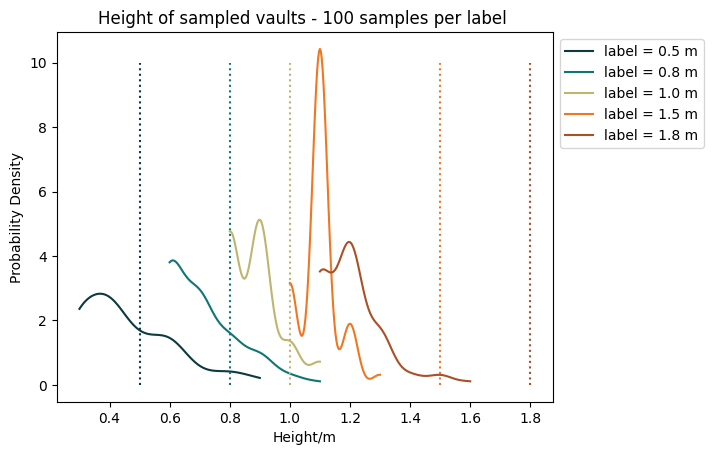

In [490]:
from scipy.stats import gaussian_kde

# fig, axs = plt.subplots(num_rows, 2, figsize=(12, num_rows*6))

y_values = range(0,10+1)

counter = 0
for l,h in h_dict.items():
    h = h.reshape(-1,)
    # Example array of heights
    unique_heights, counts = np.unique(h, return_counts=True)
    # Create a density estimate
    density = gaussian_kde(h)

    # Generate a range of values over which to plot the density
    x = np.linspace(min(h), max(h), 100)
    y = density(x)

    # probability density
    plt.plot(x, y, label= f'label = {l} m', color = colour_list_5[counter]) 
    plt.plot([l] * len(y_values), y_values, linestyle='dotted', color = colour_list_5[counter])

    # # number of occurrences
    # plt.plot(unique_heights, counts, label= f'{labels_cvae_value} m', color = colour_list_5[counter])
    # # sample vs height 
    # plt.scatter(range(h.shape[0]), h, label= f'{labels_cvae_value} m', color = colour_teal)

    counter += 1

plt.xlabel("Height/m")
plt.ylabel("Probability Density")
plt.title(f"Height of sampled vaults - {num_samples} samples per label ")
plt.legend(loc='upper left',bbox_to_anchor =(1,1))
plt.show()

In [457]:
# Assuming you have a decoder model and c_height (condition) available
sample_vector = np.random.uniform(low=-1, high=1, size=(1, 2))

# Set the desired temperature (e.g., 0.5 for exploitation, 1.0 for exploration)
temperature = 0.5

# Decode the sample with adjusted temperature
logits = decoder.predict([sample_vector, c_height])[:, :]
softmax_probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature), axis=-1, keepdims=True)

h_pred= (sur_model_dict['Height'].predict(softmax_probs, batch_size=1)) 
print(h_pred*max_values_sur_height)

1/1 [==============================] - 0s 16ms/step
[[0.]]


In [458]:
no =
# # train data
# x_train_vae_1 = dataset[random_indices]
# # test data
# x_test_vae_1 = dataset[remaining_indices]
# print(f'remaining_indices:{remaining_indices}')
# print('--------------------------')
# print(x_test_vae_1[0][:-1])
# print('---------------------------')
# x_test_vae_1 = x_test_vae_1 / np.max(dataset)
# print(x_test_vae_1[0])
# print('---------------------------')
# print(x_test_vae_1[0][:-1].reshape(27) * np.max(dataset))
# print('---------------------------')
# print(x_test_vae[0][-1].reshape(27)* np.max(dataset))
# print('---------------------------')
# # print(dataset[237])



SyntaxError: invalid syntax (3785863052.py, line 1)

In [ ]:
# GRADIENT DESCENT

# =======================================================================================

############################################ INPUTS ###########################################

# Determines whether Initial sample is from 'test_data' or 'new'
BOOLEAN_sample_grd = 'new'

# Determines whether the old gradient descent algorithm is used 
BOOLEAN_old_grd = False

# learning_rate
learn_rate_gd = 1e-1
# Select a mesh
mesh_gd = 'mesh_237'
# Select desired height
labels_cvae_value = 3.0

# number of iterations
iterations_gd = 1000

# metric to gradient descent -  'Buckling_Load_Factor', 'Utilization' , 'Interstorey_Drift_Ratios', 'all', 'Height', 'Mass'
gd_metric = ['Utilization','Mass']

# weight list (to add weights to gradient descent)
weight_metric = [1.0,0.2]

# main path
main_path_gd = os.path.join(os.getcwd(),'DATASETS',datasets[0],'grd_results')
# Create a results folder in the main directory if it doesn't exist
os.makedirs(main_path_gd, exist_ok=True)

In [ ]:
# SUR: DEFINE INPUT MESH
############################################ INPUT MESH ###########################################

if BOOLEAN_sample_grd != 'new':

    mesh_gd = int(mesh_gd[5:])
    check_mesh_in_x_train_vae = np.isin(random_indices,mesh_gd)
    check_mesh_in_x_test_vae = np.isin(remaining_indices,mesh_gd)


    if any(check_mesh_in_x_train_vae)== True:
        index_gd = np.where(random_indices==mesh_gd)
        print(f'index in X_TRAIN = {index_gd}')
        input_mesh = x_train_vae[index_gd]

    elif any(check_mesh_in_x_test_vae)== True:
        index_gd = np.where(remaining_indices==mesh_gd)
        print(f'index is in X-TEST = {index_gd}')
        input_mesh = x_test_vae[index_gd]


    if BOOLEAN_thickness_vae == 'feature':
        if np.allclose(input_mesh.reshape(x_train_vae.shape[1])[:-1]*np.max(dataset),dataset[mesh_gd]):
            print('Array from test/train sample is the SAME as from the dataset')
        else:
            print('Arrays DO NOT match')

    else:
        if np.allclose(input_mesh.reshape(x_train_vae.shape[1])*np.max(dataset),dataset[mesh_gd]):
            print('Array from test/train sample is the SAME as from the dataset')
        else:
            print('Arrays DO NOT match')


    print('--------------------------------------------------')
    print(f'test_mesh:{input_mesh.reshape(x_train_vae.shape[1])[:-1]*np.max(dataset)}')
    print('--------------------------------------------------')
    print(f'dataset_mesh:{dataset[mesh_gd]}')

else: 
    print('input_mesh is new')

input_mesh is new


In [ ]:
# VAE: Sampling from VAE

if BOOLEAN_sample_grd == 'new':

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)

    sample_vector = np.random.uniform(low=-5,high=5,size=(1,2))
    decoded_example = decoder.predict([sample_vector,c_height])[:,:]
    decoded_example_reshaped = decoded_example.reshape(28)[:-1]*np.max(dataset)

    sample_to_test = decoded_example.reshape(1,-1) #flattens into a list
    initial_sample_NEW = sample_to_test
    initial_height_NEW= sur_model_dict['Height'].predict(sample_to_test, batch_size=1)[0]*max_values_sur_height[0] 
    initial_thickness_NEW = decoded_example[0][-1]*np.max(thickness_dataset)
    initial_fd_NEW = decoded_example_reshaped
    initial_mass_NEW = sur_model_dict['Mass'].predict(sample_to_test, batch_size=1)[0]*max_values_sur_mass[0]

    input_mesh = initial_sample_NEW

    # print(predicted_scores*max_values_sur_height)

    print(f'desired_height = {labels_cvae_value} m')
    print(f'sample height = {round(initial_height_NEW[0], 3)} m')
    print(f'sample mass = {round(initial_mass_NEW[0])} kg')
    print(f'sample thickness = {round(initial_thickness_NEW, 4)} m')
    print(f'sample fd= {np.round(initial_fd_NEW,2)}')
    print(f'sample latent vector= {sample_vector}')

1/1 [==============================] - 0s 17ms/step
desired_height = 3.0 m
sample height = 3.068000078201294 m
sample mass = 38135 kg
sample thickness = 0.0705 m
sample fd= [2.08 1.24 1.34 0.98 0.9  0.93 0.89 1.19 1.43 1.53 1.49 1.82 1.49 1.46
 1.33 1.01 1.1  0.92 0.87 1.28 1.23 1.02 1.   1.27 1.43 1.59 1.54]
sample latent vector= [[ 1.62987264 -2.20371594]]


In [ ]:
# sur_model_dict['Mass']([decoded_example]).numpy().flatten()*max_values_sur_sss[0]
sur_model_dict['Mass']([decoded_example]).numpy().flatten()*max_values_sur_mass

array([38135.4843032])

In [ ]:
# OLD: RUNNING GRADIENT DESCENT

if BOOLEAN_old_grd == True:

    BOOLEAN_model_type = 'Mass'
    gd_metric = BOOLEAN_model_type

    gradients = []

    performance = []
    generated_meshes = []
    decoded_tensor_list = []

    # input_mesh = x_train_vae[input_mesh_ID]
    # input_mesh = input_mesh.astype('float32')
    # input_mesh = input_mesh.reshape(mesh_shape)

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)


    x = vae.encoder([input_mesh, c_height])
    z = x[2]

    if BOOLEAN_sample_grd != 'new':
        x = vae.encoder([input_mesh, c_height])
        z = x[2]
    elif BOOLEAN_sample_grd == 'new':
        z= tf.convert_to_tensor(sample_vector)    

    for i in range(iterations_gd):
        with tf.GradientTape() as tape:     
            tape.watch(z)                   # watches the tensor z so gradients can be calculated later
            decoded_tensor = vae.decoder([z,c_height]) # decodes to get mesh
            decoded_tensor = tf.reshape(decoded_tensor,(1,i_shape_flat_vae))        # reshapes mesh to flattened form
            # decoded_tensor = tf.multiply(decoded_tensor, np.max(dataset))
            decoded_tensor_list.append(decoded_tensor)

            y = sur_model(decoded_tensor)   # predicts performance

            if BOOLEAN_model_type=='all':
                
                if gd_metric == 'Buckling_Load_Factor':
                    y = y[0,0]   
                    y=tf.reshape(y,(1,1))       
                if gd_metric == 'Utilization':
                    y = y[0,1]     
                    y=tf.reshape(y,(1,1))         
                if gd_metric == 'Interstorey_Drift_Ratios':
                    y = y[0,2]
                    y=tf.reshape(y,(1,1)) 

            
            
            gradient = tape.gradient(y, z)  # gradient is calculated of predicted performance with respect to z
        
        # GRADIENTS
        gradients_array = gradient.numpy().reshape(latent_dim)          # gradients converted into numpy array and reshaped to latent dimension
        rms = np.sqrt(np.mean((gradients_array ** 2)))              # room mean square of gradients
        gradients.append(rms)
        # In summary, these lines calculate the RMS of gradients, which provides a measure of the overall magnitude of the gradients and can be useful for 
        # monitoring the optimization process and diagnosing potential issues such as gradient explosion or vanishing gradients.
        

        # PREDICTED PERFORMANCE
        if gd_metric != 'all':
            y_arr = y.numpy().reshape(1)  
        else:
            y_arr = y.numpy().reshape(3)  
            
        performance.append(y_arr)    
        
        decoded_tensor = vae.decoder([z,c_height])
        # decoded_tensor = tf.round(decoded_tensor)
        decoded_tensor_save = tf.reshape(decoded_tensor,(1, i_shape_flat_vae))
            
        generated_meshes.append(decoded_tensor_save)

        if BOOLEAN_model_type in ['Utilization','Interstorey_Drift_Ratios']: 
            z = z - (learn_rate_gd * gradient)
        elif BOOLEAN_model_type in ['Buckling_Load_Factor']: 
            z = z + (learn_rate_gd * gradient)
        # if len(performance) > 100 and (abs(performance[i - 1] - performance[i]) / performance[i - 1]) * 100 < 0.0001:
        #     break

    generated_meshes = np.asarray(generated_meshes)
    mesh_shape = (len(generated_meshes), i_shape_flat_vae)
    generated_meshes = generated_meshes.reshape(mesh_shape)
    
    performance_dict = {}
    performance_dict[gd_metric] = performance

    gd_metric = [gd_metric]
    BOOLEAN_model_type = [BOOLEAN_model_type]

    print('OLD Gradient descent algorithm has run')


In [ ]:
# RUNNING GRADIENT DESCENT

if BOOLEAN_old_grd == False:

    gradients = []

    performance_dict = {}
    generated_meshes = []
    decoded_tensor_list = []

    # input_mesh = x_train_vae[input_mesh_ID]
    # input_mesh = input_mesh.astype('float32')
    # input_mesh = input_mesh.reshape(mesh_shape)

    for i,val in enumerate(gd_metric):
        performance_dict[val]=[]

    if BOOLEAN_cvae_label == 'one_hot_encoded':
        c_height = labels_cvae_dict[labels_cvae_value].reshape([1,-1])
    else:
        c_height = np.array([8]).reshape(1,1)

    if BOOLEAN_sample_grd != 'new':
        x = vae.encoder([input_mesh, c_height])
        z = x[2]
    elif BOOLEAN_sample_grd == 'new':
        z= tf.convert_to_tensor(sample_vector)    

    for i in range(iterations_gd):
        with tf.GradientTape(persistent=True) as tape:     
            tape.watch(z)                   # watches the tensor z so gradients can be calculated later
            decoded_tensor = vae.decoder([z, c_height]) # decodes to get mesh
            decoded_tensor = tf.reshape(decoded_tensor,(1,i_shape_flat_vae))        # reshapes mesh to flattened form
            # decoded_tensor = tf.multiply(decoded_tensor, np.max(dataset))
            decoded_tensor_list.append(decoded_tensor)

            if gd_metric!='all':
                y_dict = {}
                gradient_list = []
                for ii,val in enumerate(gd_metric):
                    y_dict[val] = sur_model_dict[gd_metric[ii]](decoded_tensor)   # predicts performance
                    
                    gradient_list.append(tape.gradient(y_dict[val], z))  # gradient is calculated of predicted performance with respect to z

                if len(weight_metric)==1 :
                    gradient = weight_metric[0]*gradient_list[0] 
                elif len(weight_metric)==2:
                    gradient = weight_metric[0]*gradient_list[0] + weight_metric[1]*gradient_list[1]
                elif len(weight_metric)==3:                
                    gradient = weight_metric[0]*gradient_list[0] + weight_metric[1]*gradient_list[1] +  weight_metric[2]*gradient_list[2]           
                # gradient = weight_metric[0]*gradient_list[0] 
                    # y = y_dict[val]

                    
            if gd_metric=='all':
                
                if gd_metric == 'Buckling_Load_Factor':
                    y = y[0,0]   
                    y=tf.reshape(y,(1,1))       
                if gd_metric == 'Utilization':
                    y = y[0,1]     
                    y=tf.reshape(y,(1,1))         
                if gd_metric == 'Interstorey_Drift_Ratios':
                    y = y[0,2]
                    y=tf.reshape(y,(1,1)) 

                gradient = tape.gradient(y, z)  # gradient is calculated of predicted performance with respect to z
        

        # GRADIENTS
        gradients_array = gradient.numpy().reshape(latent_dim)          # gradients converted into numpy array and reshaped to latent dimension
        rms = np.sqrt(np.mean((gradients_array ** 2)))              # room mean square of gradients
        gradients.append(rms)
        # In summary, these lines calculate the RMS of gradients, which provides a measure of the overall magnitude of the gradients and can be useful for 
        # monitoring the optimization process and diagnosing potential issues such as gradient explosion or vanishing gradients.
        



        # PREDICTED PERFORMANCE
        for i,val in enumerate(gd_metric):
            y_arr = y_dict[val].numpy().reshape(1)  
            # if gd_metric[0] in ['Buckling_Load_Factor','Utilization','Interstorey_Drift_Ratios']:
            #     y_arr = y.numpy().reshape(1)  
            # elif gd_metric == 'all':
            #     y_arr = y.numpy().reshape(3)  
                
            performance_dict[val].append(y_arr)    
        
        decoded_tensor = vae.decoder([z, c_height])
        # decoded_tensor = tf.round(decoded_tensor)
        decoded_tensor_save = tf.reshape(decoded_tensor,(1, i_shape_flat_vae))
            
        generated_meshes.append(decoded_tensor_save)

        # if gd_metric[0] in ['Utilization','Interstorey_Drift_Ratios']: 
        #     z = z - (learn_rate_gd * gradient)
        # elif gd_metric[0] in ['Buckling_Load_Factor']: 
        #     z = z + (learn_rate_gd * gradient)

        z = z - (learn_rate_gd * gradient)

        # if len(performance) > 100 and (abs(performance[i - 1] - performance[i]) / performance[i - 1]) * 100 < 0.0001:
        #     break

    generated_meshes = np.asarray(generated_meshes)
    mesh_shape = (len(generated_meshes), i_shape_flat_vae)
    generated_meshes = generated_meshes.reshape(mesh_shape)

    print('NEW Gradient descent algorithm has run')

NEW Gradient descent algorithm has run


In [ ]:
# DESCRIPTION / HYPERPARAMETERS

desc_gd=[]
desc_gd.append(f'lr-{learn_rate_gd}')
desc_gd.append(f'iter-{iterations_gd}')




if BOOLEAN_thickness_vae =='feature':
    desc_gd.append('vae-thick-feature')  

# SURROGATE 
# thickness added in train data or not?
if BOOLEAN_thickness_normalization == 'separate':
    desc_gd.append('sur-thick-separate')
if BOOLEAN_thickness_normalization == 'together':
    desc_gd.append('sur-thick-together')
if BOOLEAN_thickness_normalization == 'off':
    desc_gd.append('sur-thick-off') 
# type of SSS
if 'Buckling_Load_Factor' in gd_metric:
    desc_gd.append(f"sur-BUCK_W{weight_metric[gd_metric.index('Buckling_Load_Factor')]}")
if 'Utilization' in gd_metric:
    desc_gd.append(f"sur-UTIL-W{weight_metric[gd_metric.index('Utilization')]}")
if 'Interstorey_Drift_Ratios' in gd_metric:
    desc_gd.append(f"sur-DRIFT-W{weight_metric[gd_metric.index('Interstorey_Drift_Ratios')]}")
if 'Height' in gd_metric:
    desc_gd.append(f"sur-HEIGHT-W{weight_metric[gd_metric.index('Height')]}")
if 'Mass' in gd_metric:
    desc_gd.append(f"sur-MASS-W{weight_metric[gd_metric.index('Mass')]}")

desc_gd.append('CVAE')   

if BOOLEAN_old_grd == True:
    desc_gd.append('OLD')  

desc_gd='___'.join(desc_gd)
print(desc_gd)

save_location_gd= os.path.join(main_path_gd,desc_gd)
os.makedirs(save_location_gd, exist_ok=True)

lr-0.1___iter-1000___vae-thick-feature___sur-thick-separate___sur-UTIL-W1.0___sur-MASS-W0.2___CVAE


In [ ]:
# MAKING THE DIRECTORY FOR THE MESH

count = 0
name_of_mesh = f'mesh_{mesh_gd}_{count}' if BOOLEAN_sample_grd != 'new' else f'mesh_ht_{labels_cvae_value}_{count}'
# os.makedirs()
grd_path = os.path.join(save_location_gd, name_of_mesh)



while os.path.exists(grd_path) == True:
    # count = os.path.normpath(grd_path).split(os.path.sep)[-1].split('_')[-1]
    count += 1
    name_of_mesh = f'mesh_{mesh_gd}_{count}' if BOOLEAN_sample_grd != 'new' else f'mesh_ht_{labels_cvae_value}_{count}'
    grd_path = os.path.join(save_location_gd, name_of_mesh)
os.makedirs(grd_path,exist_ok=True)
save_location_gd = grd_path

In [ ]:
# TESTING TO SEE IF THE SURROGATE MODEL AND GRADIENT DESCENT GIVE THE SAME PREDICTION


key_perf=['Buckling_Load_Factor','Utilization','Interstorey_Drift_Ratios']

with open(os.path.join(main_path_sur,'train_labels_dict_max.json')) as file:
    train_labels_dict_max = json.load(file)


ti= -1
sample_to_test_gd = generated_meshes[ti]

print(f'iteration number = last' if ti==-1 else ti)
print('------------------------------------------------------------------------------')
print((sample_to_test_gd[:-1]*np.max(dataset) if BOOLEAN_thickness_vae=='feature' else sample_to_test_gd*np.max(dataset)))
print('------------------------------------------------------------------------------')




for i,val in enumerate(gd_metric):
    
    ti= -1
    sample_to_test_gd = generated_meshes[ti]

    print('------------------------------------------------------------------------------')
    print(f'-----------------------{gd_metric[i]}-------------------------------')
    print('------------------------------------------------------------------------------')

    if val in sss:
        max_values_sur_grd = max_values_sur_sss[key_perf.index(gd_metric[i])]
    elif val == 'Height':
        max_values_sur_grd = max_values_sur_height
    elif val == 'Mass':
        max_values_sur_grd = max_values_sur_mass


    print(f'predicted_score_gd:{performance_dict[val][ti]*max_values_sur_grd}                                 normalized: {performance_dict[val][ti]}')

    sample_to_test_gd = sample_to_test_gd.reshape(1,sample_to_test_gd.shape[0])

    predicted_score_gd_validation = sur_model_dict[gd_metric[i]](sample_to_test_gd).numpy().flatten()
    print(f'predicted_score_surrogate: {predicted_score_gd_validation*max_values_sur_grd}                 normalized: {predicted_score_gd_validation}')


    if BOOLEAN_sample_grd != 'new':

        if val in sss:
            actual_score_non_optimized = train_labels_dict_max['without_failure'][f'mesh_{mesh_gd}'][key_perf.index(gd_metric[i])]  
        elif val == 'Height': 
            actual_score_non_optimized = height_dataset[mesh_gd][0]     
        elif val == 'Mass': 
            actual_score_non_optimized = mass_dataset[mesh_gd][0]       

    else: 
        actual_score_non_optimized = sur_model_dict[gd_metric[i]](initial_sample_NEW).numpy().flatten()*max_values_sur_grd


    print(f'actual_initial_score_pre-optimization:{actual_score_non_optimized}                 normalized: {actual_score_non_optimized/max_values_sur_grd}')






iteration number = last
------------------------------------------------------------------------------
[0.7080947  0.4582239  0.5087833  0.3888557  0.3917169  0.3712417
 0.3726286  0.55253977 0.525764   0.59491026 0.49716243 0.6158527
 0.5035571  0.51949656 0.4816932  0.3766381  0.4041258  0.4237704
 0.32291582 0.47137195 0.4948873  0.43120018 0.3705607  0.46595523
 0.5628145  0.50745744 0.5465284 ]
------------------------------------------------------------------------------
------------------------------------------------------------------------------
-----------------------Utilization-------------------------------
------------------------------------------------------------------------------
predicted_score_gd:[2.8168347]                                 normalized: [0.05627535]
predicted_score_surrogate: [2.8168347]                 normalized: [0.05627535]
actual_initial_score_pre-optimization:[4.159679]                 normalized: [0.08310299]
------------------------------------

In [ ]:
# SAVING GENERATED MESHES, GRADIENT, PERFORMANCES


new_meshes = generated_meshes[:,:-1]*np.max(dataset)
gd_result = {}
for ii,val in enumerate(gd_metric):
    performance =  performance_dict[val]
    new_performance_normalized = [i[0] for i in performance] 

    if val in sss:
        new_performance = [i*max_values_sur_sss[key_perf.index(gd_metric[ii])] for i in new_performance_normalized]
    elif val == 'Height':
        new_performance = [i*max_values_sur_height[0] for i in new_performance_normalized]
    elif val == 'Mass':
        new_performance = [i*max_values_sur_mass[0] for i in new_performance_normalized]

    if BOOLEAN_thickness_vae =='feature':
        new_meshes = generated_meshes[:,:-1]*np.max(dataset)
        
        initial_thickness = thickness_dataset[mesh_gd] if BOOLEAN_sample_grd != 'new' else initial_thickness_NEW
        new_thickness = generated_meshes[:,-1]*np.max(thickness_dataset) if BOOLEAN_thickness_normalization=='separate' else generated_meshes[:,-1]*np.max(dataset)
        new_thickness_normalized = generated_meshes[:,-1] 

        new_thickness = np.insert(new_thickness,0,initial_thickness)
        new_thickness_normalized = np.insert(new_thickness_normalized,0,(initial_thickness/np.max(thickness_dataset)))  if BOOLEAN_thickness_normalization=='separate' else np.insert(new_thickness_normalized,0,(initial_thickness/np.max(dataset)))  

        new_thickness_all_df = pd.DataFrame({'thickness/m': new_thickness, 'thickness_normalized':new_thickness_normalized})
        new_thickness_all_df.to_csv(os.path.join(save_location_gd, 'thickness.csv'))

    else:
        new_meshes = generated_meshes*np.max(dataset)



    initial_height = height_dataset[mesh_gd] if BOOLEAN_sample_grd != 'new' else initial_height_NEW 
    new_height = sur_model_dict['Height'](generated_meshes)*np.max(height_dataset) 
    new_height_normalized = sur_model_dict['Height'](generated_meshes)

    new_height = np.insert(new_height,0,initial_height)
    new_height_normalized = np.insert(new_height_normalized,0,(initial_height/np.max(height_dataset))) 

    new_height_all_df = pd.DataFrame({'height/m': new_height, 'height_normalized':new_height_normalized})
    new_height_all_df.to_csv(os.path.join(save_location_gd, 'height.csv'))


    new_performance_normalized = [i[0] for i in performance] 

    if val in sss:
        new_performance = [i*max_values_sur_sss[key_perf.index(gd_metric[ii])] for i in new_performance_normalized]
    elif val == 'Height':
        new_performance = [i*max_values_sur_height[0] for i in new_performance_normalized]        
    elif val == 'Mass':
        new_performance = [i*max_values_sur_mass[0] for i in new_performance_normalized]        


    initial_mesh = dataset[mesh_gd] if BOOLEAN_sample_grd != 'new' else initial_fd_NEW 


    if val in sss:
        
        if BOOLEAN_sample_grd != 'new': 
            initial_performance = train_labels_dict_max['without_failure'][f'mesh_{mesh_gd}'][key_perf.index(gd_metric[ii])] 
        else: 
            initial_performance = sur_model_dict[gd_metric[ii]](initial_sample_NEW).numpy().flatten()[0]*max_values_sur_sss[key_perf.index(gd_metric[ii])]
        
        initial_performance_normalized = initial_performance/max_values_sur_sss[key_perf.index(gd_metric[ii])]

    elif val == 'Height':
        initial_performance = height_dataset[mesh_gd][0] if BOOLEAN_sample_grd != 'new' else initial_height_NEW[0] 
        initial_performance_normalized = initial_performance/max_values_sur_height[0]
        
    elif val == 'Mass':
        initial_performance = mass_dataset[mesh_gd][0] if BOOLEAN_sample_grd != 'new' else initial_mass_NEW[0] 
        initial_performance_normalized = initial_performance/max_values_sur_mass[0]

    performance_all_gd = copy.deepcopy(new_performance)
    performance_all_gd.insert(0,initial_performance)

    performance_all_gd_normzalized = copy.deepcopy(new_performance_normalized)
    performance_all_gd_normzalized.insert(0,initial_performance_normalized)


    meshes_all_gd = np.vstack((initial_mesh,new_meshes))
    meshes_all_gd = np.concatenate(([initial_mesh], new_meshes), axis=0)

    # dataframe named mesh_0,...
    meshes_all_gd_keys = list(range(meshes_all_gd.shape[0]))
    meshes_all_gd_keys = np.array([f'mesh_{i}' for i in meshes_all_gd_keys])
    meshes_all_gd = np.transpose(meshes_all_gd)
    meshes_all_gd_df = pd.DataFrame(data=meshes_all_gd, columns=meshes_all_gd_keys)
    meshes_all_gd_df.to_csv(os.path.join(save_location_gd,'fd_meshes.csv'),index=False)
    # dataframe named iteration_0,...

    meshes_all_gd_keys = list(range(meshes_all_gd.shape[1]))
    meshes_all_gd_keys = np.array([f'iteration_{i}' for i in meshes_all_gd_keys])
    meshes_all_gd_df = pd.DataFrame(data=meshes_all_gd, columns=meshes_all_gd_keys)
    meshes_all_gd_df.to_csv(os.path.join(save_location_gd, 'fd_iterations.csv'),index=False)


    performance_all_gd_df = pd.DataFrame({f'{val}':performance_all_gd,f'{val} normalized':performance_all_gd_normzalized})
    performance_all_gd_df.set_index(meshes_all_gd_keys,inplace=True)
    performance_all_gd_df.to_csv(os.path.join(save_location_gd,f'performance_iterations_{val}.csv'))





    # ITERATION PERFORMANCES
    print('------------------------------------------------------------')
    print(f'-----------------------{val}-------------------------------------')
    print('------------------------------------------------------------')
    
    print(f"performance_actual: {initial_performance}                 normalized: {initial_performance_normalized} ")
    print(f"performance_first: {new_performance[0]}          normalized: {new_performance_normalized[0]} ")
    print(f"performance_last: {new_performance[-1]}          normalized: {new_performance_normalized[-1]}")
    print(f"Percentage_change in performance: {round(((new_performance[-1] - initial_performance)*100/initial_performance),2)} %")



    
    gd_result[f'performance_actual_{val}']=initial_performance
    gd_result[f'performance_first_{val}']=new_performance[0]
    gd_result[f'performance_last_{val}']=new_performance[-1]
    gd_result[f'Percentage_change in performance_{val}']= round(((new_performance[-1] - initial_performance)*100/initial_performance),2)
    gd_result['thickness_actual']=thickness_dataset[mesh_gd][0] if BOOLEAN_sample_grd != 'new' else initial_thickness_NEW
    gd_result['thickness_first']=new_thickness[1]
    gd_result['thickness_last']=new_thickness[-1]
    gd_result['height_actual']=height_dataset[mesh_gd][0] if BOOLEAN_sample_grd != 'new' else initial_height_NEW
    gd_result['height_first']=new_height[1]
    gd_result['height_last']=new_height[-1]


    gd_result_df = pd.DataFrame(gd_result, index=[0]).T
    gd_result_df.to_csv(os.path.join(save_location_gd,'summary.csv'), index=True)

print('------------------------------------------------------------')
print(f'-----------------------Thickness-------------------------------------')
print('------------------------------------------------------------')
print(f"thickness_actual: {thickness_dataset[mesh_gd][0] if BOOLEAN_sample_grd != 'new' else initial_thickness_NEW}")    
print(f"thickness_first: {new_thickness[1]}")
print(f"thickness_last: {new_thickness[-1]}")
print('------------------------------------------------------------')
print(f'-----------------------Height-------------------------------------')
print('------------------------------------------------------------')
print(f"height_actual: {height_dataset[mesh_gd][0] if BOOLEAN_sample_grd != 'new' else initial_height_NEW[0]}")      
print(f"height_first: {new_height[1]}")
print(f"height_last: {new_height[-1]}")

------------------------------------------------------------
-----------------------Utilization-------------------------------------
------------------------------------------------------------
performance_actual: 4.159678788774727                 normalized: 0.0831029862165451 
performance_first: 4.159678788774727          normalized: 0.0831029862165451 
performance_last: 2.816834709348541          normalized: 0.056275349110364914
Percentage_change in performance: -32.28 %
------------------------------------------------------------
-----------------------Mass-------------------------------------
------------------------------------------------------------
performance_actual: 38135.4921875                 normalized: 0.3127463212484643 
performance_first: 38135.48430319759          normalized: 0.3127462565898895 
performance_last: 43699.82956205006          normalized: 0.3583790361881256
Percentage_change in performance: 14.59 %
--------------------------------------------------------

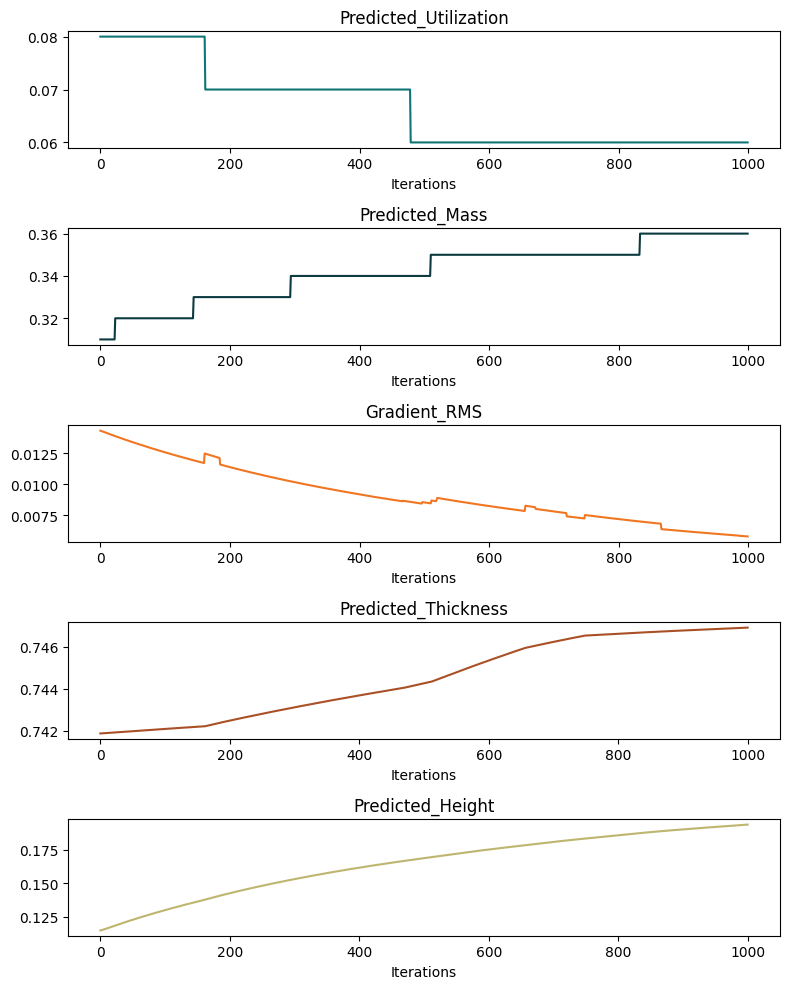

In [ ]:
# PLOT PERFORMANCE AND GRADIENTS VS ITERATIONS 



colour_list_4 = [colour_teal, colour_dark_blue, colour_orange, colour_maroon, colour_gold, colour_olive_green]

list_to_plot = []
perf_dict = {}
for i, val in enumerate(gd_metric):
    perf_dict[val] = np.array([i[0] for i in performance_dict[val]])
    list_to_plot.append(np.round(perf_dict[val],2))

list_to_plot.append(gradients)
list_to_plot.append(new_thickness_normalized)
list_to_plot.append(new_height_normalized)

fig, axs = plt.subplots(len(list_to_plot),1,figsize=(8,len(list_to_plot)*2))

for i,val in enumerate(list_to_plot):

    axs[i].plot(range(len(val)), val, color=colour_list_4[i])
    axs[i].set_xlabel('Iterations')
    axs[i].set_title('Gradient_RMS' if i==len(list_to_plot)-3 else f'Predicted_Thickness' if i==len(list_to_plot)-2 else f'Predicted_Height'if i==len(list_to_plot)-1 else f'Predicted_{gd_metric[i]}')
    axs[i].grid(False)

plt.tight_layout()
plt.savefig(os.path.join(save_location_gd,f'plot_{name_of_mesh}_{gd_metric}_normalized.png'))
plt.show()

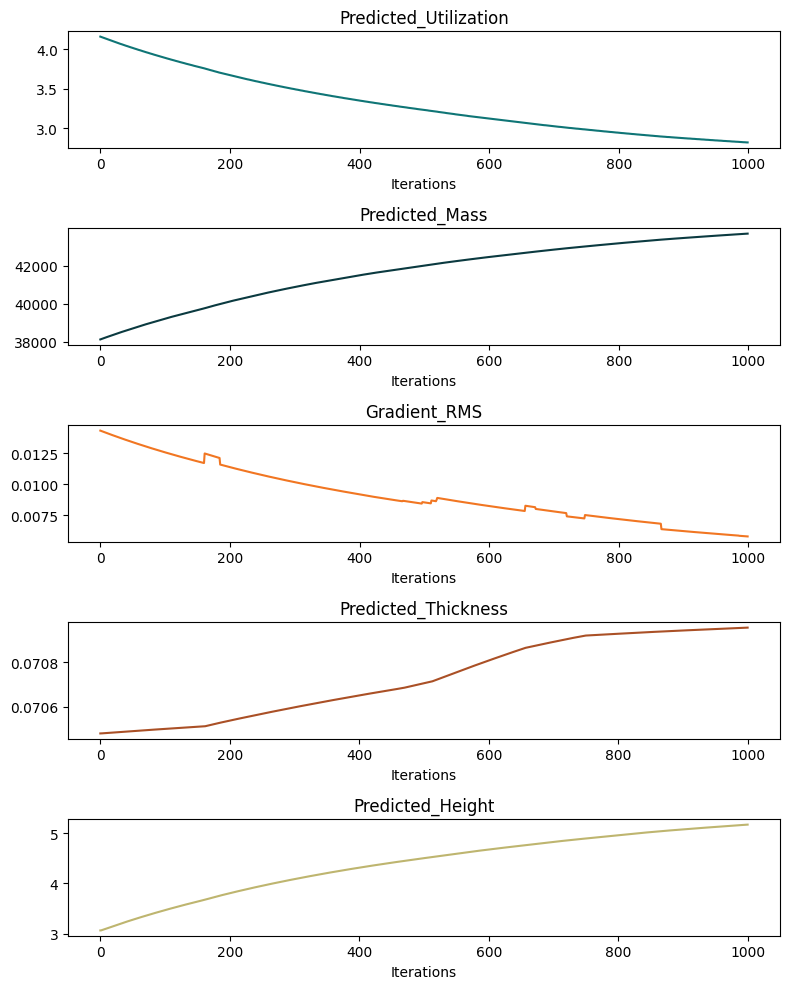

In [ ]:
# PLOT PERFORMANCE AND GRADIENTS VS ITERATIONS NOT NORMALIZED


list_to_plot = []
perf_dict = {}
for i, val in enumerate(gd_metric):
    perf_dict[val] = np.array([i[0] for i in performance_dict[val]])
    if val in sss:
        perf_dict[val] = np.round(perf_dict[val]*max_values_sur_sss[key_perf.index(gd_metric[i])],3) if val != 'Interstorey_Drift_Ratios' else perf_dict[val]*max_values_sur_sss[key_perf.index(gd_metric[i])]
    elif val == 'Height':
        perf_dict[val] = np.round(perf_dict[val]*max_values_sur_height,3)
    elif val == 'Mass':
        perf_dict[val] = np.round(perf_dict[val]*max_values_sur_mass,0)
    list_to_plot.append(perf_dict[val])

list_to_plot.append(gradients)
list_to_plot.append(new_thickness)
list_to_plot.append(new_height)

fig, axs = plt.subplots(len(list_to_plot),1,figsize=(8,len(list_to_plot)*2))

for i,val in enumerate(list_to_plot):

    axs[i].plot(range(len(val)), val, color=colour_list_4[i])
    axs[i].set_xlabel('Iterations')
    axs[i].set_title('Gradient_RMS' if i==len(list_to_plot)-3 else f'Predicted_Thickness' if i==len(list_to_plot)-2 else f'Predicted_Height'if i==len(list_to_plot)-1 else f'Predicted_{gd_metric[i]}') 
    axs[i].grid(False)

plt.tight_layout()
plt.savefig(os.path.join(save_location_gd,f'plot_{name_of_mesh}_{gd_metric}_NOT_normalized.png')) 
plt.show()